In [1]:
%matplotlib inline
%pylab inline

import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
import random
import time
import sys
import os
from itertools import groupby

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw

import pymongo
from bson.binary import Binary
from bson.objectid import ObjectId
from pymongo import MongoClient

Populating the interactive namespace from numpy and matplotlib


# Connection to Mongo client and DB creation

In [2]:
client = MongoClient()
db = client.watermelon

# Similarity functions

In [3]:
def similarity_search_fp(smiles, threshold=0.8):
    """Perform a similarity search using aggregation framework."""
    if not smiles:
        return
    mol = Chem.MolFromSmiles(smiles)
    if not mol:
        return
    qfp = list(AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048,useFeatures=True).GetOnBits())    
    qn = len(qfp)                           # Number of bits in query fingerprint
    qmin = int(ceil(qn * threshold))        # Minimum number of bits in results fingerprints
    qmax = int(qn / threshold)              # Maximum number of bits in results fingerprints
    ncommon = qn - qmin + 1                 # Number of fingerprint bits in which at least 1 must be in common
    if db.mfp_counts:
        reqbits = [count['_id'] for count in db.mfp_counts.find({'_id': {'$in': qfp}}).sort('count', 1).limit(ncommon)]
    else:
        reqbits = qfp[:ncommon]
    aggregate = [
        {'$match': {'mfp.count': {'$gte': qmin, '$lte': qmax}, 'mfp.bits': {'$in': reqbits}}},
        {'$project': {
            'tanimoto': {'$let': {
                'vars': {'common': {'$size': {'$setIntersection': ['$mfp.bits', qfp]}}},
                'in': {'$divide': ['$$common', {'$subtract': [{'$add': [qn, '$mfp.count']}, '$$common']}]}
            }},
        'unique_smiles': 1,
        'afc_id': 1,
        'compound_name':1
        }},
        {'$match': {'tanimoto': {'$gte': threshold}}}
    ]
    response = db.wmolecules.aggregate(aggregate)
    return [(r['tanimoto'], r['unique_smiles'], r['compound_name'], r['afc_id']) for r in response]

In [4]:
def similarity_search_zinc(smiles, threshold=0.8):
    """Perform a similarity search using aggregation framework."""
    if not smiles:
        return
    mol = Chem.MolFromSmiles(smiles)
    if not mol:
        return
    qfp = list(AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048,useFeatures=True).GetOnBits())    
    qn = len(qfp)                           # Number of bits in query fingerprint
    qmin = int(ceil(qn * threshold))        # Minimum number of bits in results fingerprints
    qmax = int(qn / threshold)              # Maximum number of bits in results fingerprints
    ncommon = qn - qmin + 1                 # Number of fingerprint bits in which at least 1 must be in common
    if db.mfp_counts_zinc:
        reqbits = [count['_id'] for count in db.mfp_counts_zinc.find({'_id': {'$in': qfp}}).sort('count', 1).limit(ncommon)]
    else:
        reqbits = qfp[:ncommon]
    aggregate = [
        {'$match': {'mfp.count': {'$gte': qmin, '$lte': qmax}, 'mfp.bits': {'$in': reqbits}}},
        {'$project': {
            'tanimoto': {'$let': {
                'vars': {'common': {'$size': {'$setIntersection': ['$mfp.bits', qfp]}}},
                'in': {'$divide': ['$$common', {'$subtract': [{'$add': [qn, '$mfp.count']}, '$$common']}]}
            }},
        'smiles': 1,
        'zinc_id': 1
        }},
        {'$match': {'tanimoto': {'$gte': threshold}}}
    ]
    response = db.zinc_active.aggregate(aggregate)
    return [(r['tanimoto'], r['smiles'], r['zinc_id']) for r in response]

In [5]:
def similarity_search_drugbank(smiles, threshold=0.8):
    """Perform a similarity search using aggregation framework."""
    if not smiles:
        return
    mol = Chem.MolFromSmiles(smiles)
    if not mol:
        return
    qfp = list(AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048,useFeatures=True).GetOnBits())    
    qn = len(qfp)                           # Number of bits in query fingerprint
    qmin = int(ceil(qn * threshold))        # Minimum number of bits in results fingerprints
    qmax = int(qn / threshold)              # Maximum number of bits in results fingerprints
    ncommon = qn - qmin + 1                 # Number of fingerprint bits in which at least 1 must be in common
    if db.mfp_counts_zinc:
        reqbits = [count['_id'] for count in db.mfp_counts_drugbank.find({'_id': {'$in': qfp}}).sort('count', 1).limit(ncommon)]
    else:
        reqbits = qfp[:ncommon]
    aggregate = [
        {'$match': {'mfp.count': {'$gte': qmin, '$lte': qmax}, 'mfp.bits': {'$in': reqbits}}},
        {'$project': {
            'tanimoto': {'$let': {
                'vars': {'common': {'$size': {'$setIntersection': ['$mfp.bits', qfp]}}},
                'in': {'$divide': ['$$common', {'$subtract': [{'$add': [qn, '$mfp.count']}, '$$common']}]}
            }},
        'smiles': 1,
        'drugbank_id': 1
        }},
        {'$match': {'tanimoto': {'$gte': threshold}}}
    ]
    response = db.drugbank.aggregate(aggregate)
    return [(r['tanimoto'], r['smiles'], r['drugbank_id']) for r in response]

# Reading watermelon data

In [5]:
# read the curated molecules tsv and load to mongoDB

wmdf = pd.read_csv("data/curated_watermelon_molecules.tsv", sep='\t', header=0)
wmdf


compoundName iupacName        cas  \
0                           1-chloro-2,4-dinitrobenzene       NaN    97-00-7   
1                        2,3-dihydroxy-3-methylvalerate       NaN   562-43-6   
2                             2,3-dihydroxybenzoic acid       NaN   303-38-8   
3                            2-aceto-2-hydroxybutanoate       NaN  3142-65-2   
4                                     2-dehydropantoate       NaN   470-30-4   
...                                                 ...       ...        ...   
1535  5,7-dihydroxy-8-[(4-hydroxyphenyl)methyl]-6-[(...       NaN        NaN   
1536  (1R,2R,3aS,3bS,9aR,9bR,11aR)-2-hydroxy-3a,6,6,...       NaN        NaN   
1537  (1S,2S,4R,6S,9R,10R,11R,14R,15R)-9,17-dihydrox...       NaN        NaN   
1538                                   myristoleic acid       NaN        NaN   
1539                            p-(methoxymethyl)phenol       NaN        NaN   

        kegg         hmdb pubchem  chebi      foodb     lipidmaps  \
0     C14397          NaN       6  34718  FDB030243           NaN   
1     C04104  HMDB0012140       8    882  FDB030296  LMFA01050469   
2     C00196  HMDB0000397      19  18026  FDB012200           NaN   
3     C00659  HMDB0006900      21    982  FDB024147  LMFA01050501   
4     C00966          NaN      38  17094  FDB030332           NaN   
...      ...          ...     ...    ...        ...           ...   
1535     NaN          NaN     NaN    NaN        NaN           NaN   
1536     NaN          NaN     NaN    NaN        NaN           NaN   
1537     NaN          NaN     NaN    NaN        NaN           NaN   
1538     NaN          NaN     NaN    NaN        NaN           NaN   
1539     NaN          NaN     NaN    NaN        NaN           NaN   

     molecularFormula  ...  eccentricConnectivityIndexDescriptor  \
0          C6H3ClN2O4  ...                                   123   
1             C6H12O4  ...                                    68   
2              C7H6O4  ...                                    87   
3             C6H10O4  ...                                    55   
4             C6H10O4  ...                                    68   
...               ...  ...                                   ...   
1535        C34H36O16  ...                                  1705   
1536        C36H54O13  ...                                  1485   
1537         C31H44O7  ...                                   867   
1538         C14H26O2  ...                                   321   
1539          C8H10O2  ...                                   102   

     fmfDescriptor      fsp3 fragmentComplexityDescriptor numberSpiroAtoms  \
0         0.375000  0.000000                       100.07                0   
1         0.000000  0.833333                       351.04                0   
2         0.352941  0.000000                       179.04                0   
3         0.000000  0.666667                       271.04                0   
4         0.000000  0.666667                       271.04                0   
...            ...       ...                          ...              ...   
1535      0.418605  0.382353                      5831.16                0   
1536      0.233010  0.805556                      9097.13                0   
1537      0.268293  0.774194                      5990.07                0   
1538      0.000000  0.785714                      1441.02                0   
1539      0.300000  0.250000                       310.02                0   

      lipinskiRuleOf5Failures  xlogp  zagrebIndex  topoPSA  tpsaEfficiency  
0                           0  1.827         62.0    86.28        0.427175  
1                           0 -0.488         44.0    77.76        0.525144  
2                           0  0.777         52.0    77.76        0.504848  
3                           0 -0.153         44.0    74.60        0.510756  
4                           0 -0.811         44.0    74.60        0.510756  
...                       ...    ... 

# Filling database with watermelon data and preparing for search

In [6]:
# populating the MongoDB database

if 'wmolecules'in db.list_collection_names():
    db.wmolecules.drop() 

print('populating mongodb collection with compounds from watermelon molecules...')

wmolecules = db.wmolecules

#count_inserted = 0

for index, row in wmdf.iterrows():

    try:
        rdmol = Chem.MolFromSmiles(row["Canonical_Smiles"])
    except:
        continue
    if not rdmol:
        continue

    mol_data = {
        'smiles': Chem.MolToSmiles(rdmol, isomericSmiles=True),
        'unique_smiles':row["Canonical_Smiles"],
        'original_smiles':row["original_smiles"],
        'molecular_formula':row["molecularFormula"],
        'compound_name': row["compoundName"],
        'iupac_name':row["iupacName"],
        'cas':row["cas"],
        'kegg':row["kegg"],
        'lipidmaps':row["lipidmaps"],
        'pubchem':row["pubchem"],
        'hmdb':row["hmdb"],
        'chebi':row["chebi"],
        'foodb':row["foodb"],
        "afc_id":row["afc_id"],
        'molecular_weight':row["molecularWeight"],
        'rdmol': Binary(rdmol.ToBinary()),
    }
    wmolecules.insert_one(mol_data)
    #count_inserted++

print(str(wmolecules.count_documents({}))+' molecules loaded successfully')

populating mongodb collection with compounds from watermelon molecules...
1540 molecules loaded successfully


In [7]:
#Fingerprints

print('precalculating fingerprints...')

for wm in db.wmolecules.find({}):
    rdmol = Chem.Mol(wm['rdmol'])
    mfp = list(AllChem.GetMorganFingerprintAsBitVect(rdmol, 2, nBits=2048,useFeatures=True).GetOnBits())
    db.wmolecules.update_one({'_id': wm['_id']}, {"$set":{"mfp":{'bits': mfp, 'count': len(mfp)}}} )
print('...done')


precalculating fingerprints...
...done


In [8]:
print ('computing fingerprint bit counts...')

counts = {}

for wmolecule in db.wmolecules.find({}):

    for bit in wmolecule['mfp']['bits']:
        counts[bit] = counts.get(bit, 0) + 1

        
        
if 'mfp_counts'in db.list_collection_names():
    db.mfp_counts.drop()

for bit in counts.keys():
    db.mfp_counts.insert_one({'_id': bit, 'count':counts[bit] })
print("...done")

computing fingerprint bit counts...
...done


In [9]:
db.wmolecules.create_index('mfp.bits')
db.wmolecules.create_index('mfp.count')

'mfp.count_1'

# Filling and preparing ZINC active

In [11]:
# read zinc

zinc = pd.read_csv("data/ZINC_in-vitro_subset_2020_Okt_30.txt", sep=' ', header=None)
#C[N+]1(CC2CCCCCC2)CCC(NC(=O)C2c3cc(Cl)ccc3Oc3ccc(Cl)cc32)CC1 ZINC000032011198
zinc.columns = ['smiles',"zinc_id"]


zinc

smiles           zinc_id
0       C[N+]1(CC2CCCCCC2)CCC(NC(=O)C2c3cc(Cl)ccc3Oc3c...  ZINC000032011198
1                                    COc1ccc(C=O)c(Br)c1O  ZINC000000057109
2       OC[C@@H](O)[C@@H](O)[C@H](O)[C@@H](O)c1nc2cc(C...  ZINC000004353694
3                                      CC(C)CN(CC(C)C)N=O  ZINC000004352937
4       CC(C)c1ccc2c(c1)CC[C@H]1[C@](C)(C(N)=O)CCC[C@@...  ZINC000003171687
...                                                   ...               ...
306342  CC(=O)O[C@]1(C(C)=O)CC[C@H]2[C@@H]3C[C@H](C)C4...  ZINC001083817471
306343  NC(=O)c1cc(S(=O)(=O)Nc2ccc3cc(C4CC4)[nH]c3c2)c...  ZINC001083818488
306344  COc1cc2c(cc1OC)[C@@]13CCN4CC5=CCO[C@H]6CC(=O)N...  ZINC000001069090
306345                COc1ccc([C@H]2CNC(=O)C2)cc1OC1CCCC1  ZINC000002000919
306346               CCOC(=O)c1ccc(OC(=O)CCCCCNC(=N)N)cc1  ZINC000002002226

[306347 rows x 2 columns]

In [12]:
# populating the MongoDB database

if 'zinc_active'in db.list_collection_names():
    db.zinc_active.drop() 

print('populating mongodb collection with compounds from ZINC active molecules...')

zinc_active = db.zinc_active


for index, row in zinc.iterrows():

    try:
        rdmol = Chem.MolFromSmiles(row["smiles"])
    except:
        continue
    if not rdmol:
        continue

    mol_data = {
        'smiles': Chem.MolToSmiles(rdmol, isomericSmiles=True),
        'ori_smiles':row["smiles"],
        "zinc_id":row["zinc_id"],
        'rdmol': Binary(rdmol.ToBinary()),
    }
    zinc_active.insert_one(mol_data)
    #count_inserted++

print(str(zinc_active.count_documents({}))+' molecules from ZINC loaded successfully')

#Fingerprints

print('precalculating fingerprints...')

for z in db.zinc_active.find({}):
    rdmol = Chem.Mol(z['rdmol'])
    mfp = list(AllChem.GetMorganFingerprintAsBitVect(rdmol, 2, nBits=2048, useFeatures=True).GetOnBits())
    db.zinc_active.update_one({'_id': z['_id']}, {"$set":{"mfp":{'bits': mfp, 'count': len(mfp)}}} )
print('...done')


print ('computing fingerprint bit counts...')

counts = {}

for z in db.zinc_active.find({}):

    for bit in z['mfp']['bits']:
        counts[bit] = counts.get(bit, 0) + 1

        
        
if 'mfp_counts_zinc'in db.list_collection_names():
    db.mfp_counts_zinc.drop()

for bit in counts.keys():
    db.mfp_counts_zinc.insert_one({'_id': bit, 'count':counts[bit] })
print("...done")

db.zinc_active.create_index('mfp.bits')
db.zinc_active.create_index('mfp.count')

populating mongodb collection with compounds from ZINC active molecules...


RDKit WARNING: [13:48:03] Conflicting single bond directions around double bond at index 1.
RDKit WARNING: [13:48:03]   BondStereo set to STEREONONE and single bond directions set to NONE.
RDKit WARNING: [13:48:09] Conflicting single bond directions around double bond at index 1.
RDKit WARNING: [13:48:09]   BondStereo set to STEREONONE and single bond directions set to NONE.
RDKit WARNING: [13:48:13] Conflicting single bond directions around double bond at index 1.
RDKit WARNING: [13:48:13]   BondStereo set to STEREONONE and single bond directions set to NONE.
RDKit WARNING: [13:49:27] Conflicting single bond directions around double bond at index 1.
RDKit WARNING: [13:49:27]   BondStereo set to STEREONONE and single bond directions set to NONE.
RDKit WARNING: [13:50:09] Conflicting single bond directions around double bond at index 1.
RDKit WARNING: [13:50:09]   BondStereo set to STEREONONE and single bond directions set to NONE.


306347 molecules from ZINC loaded successfully
precalculating fingerprints...
...done
computing fingerprint bit counts...
...done


'mfp.count_1'

# Filling and preparing DrugBank (all 3D)

In [13]:
drugbank_list = Chem.SDMolSupplier('data/3D structures.sdf')


In [14]:
# populating the MongoDB database with DRUGBANK

if 'drugbank'in db.list_collection_names():
    db.drugbank.drop() 

print('populating mongodb collection with compounds from drugbank molecules...')

drugbank = db.drugbank


for rdmol in drugbank_list:

    mol_data = {
        'smiles': Chem.MolToSmiles(rdmol, isomericSmiles=True),
        "drugbank_id":rdmol.GetProp('DATABASE_ID'),
        "ori_smiles":rdmol.GetProp('SMILES'),
        'rdmol': Binary(rdmol.ToBinary()),
    }
    drugbank.insert_one(mol_data)
    #count_inserted++

print(str(drugbank.count_documents({}))+' molecules from DRUGBANK loaded successfully')

#Fingerprints

print('precalculating fingerprints...')

for z in db.drugbank.find({}):
    rdmol = Chem.Mol(z['rdmol'])
    mfp = list(AllChem.GetMorganFingerprintAsBitVect(rdmol, 2, nBits=2048, useFeatures=True).GetOnBits())
    db.drugbank.update_one({'_id': z['_id']}, {"$set":{"mfp":{'bits': mfp, 'count': len(mfp)}}} )
print('...done')


print ('computing fingerprint bit counts...')

counts = {}

for z in db.drugbank.find({}):

    for bit in z['mfp']['bits']:
        counts[bit] = counts.get(bit, 0) + 1

        
        
if 'mfp_counts_drugbank'in db.list_collection_names():
    db.mfp_counts_drugbank.drop()

for bit in counts.keys():
    db.mfp_counts_drugbank.insert_one({'_id': bit, 'count':counts[bit] })
print("...done")

db.mfp_counts_drugbank.create_index('mfp.bits')
db.mfp_counts_drugbank.create_index('mfp.count')

populating mongodb collection with compounds from drugbank molecules...


RDKit WARNING: [14:01:03] Warning: molecule is tagged as 3D, but all Z coords are zero
RDKit WARNING: [14:01:04] Warning: molecule is tagged as 3D, but all Z coords are zero
RDKit WARNING: [14:01:04] Warning: molecule is tagged as 3D, but all Z coords are zero
RDKit WARNING: [14:01:07] Warning: molecule is tagged as 3D, but all Z coords are zero
RDKit WARNING: [14:01:07] Warning: molecule is tagged as 3D, but all Z coords are zero
RDKit WARNING: [14:01:07] Warning: molecule is tagged as 3D, but all Z coords are zero
RDKit WARNING: [14:01:07] Warning: molecule is tagged as 3D, but all Z coords are zero
RDKit WARNING: [14:01:07] Warning: molecule is tagged as 3D, but all Z coords are zero
RDKit WARNING: [14:01:07] Warning: molecule is tagged as 3D, but all Z coords are zero
RDKit WARNING: [14:01:07] Warning: molecule is tagged as 3D, but all Z coords are zero
RDKit WARNING: [14:01:07] Warning: molecule is tagged as 3D, but all Z coords are zero
RDKit WARNING: [14:01:08] Warning: molecule

9137 molecules from DRUGBANK loaded successfully
precalculating fingerprints...
...done
computing fingerprint bit counts...
...done


'mfp.count_1'

# Filling and preparing Chembl

## Comparison to self

Checking for the disversity/similarity of watermelon compounds with Tanimoto

In [75]:


ft = open("data/test_sim.txt", "w")
ft.write("id1\tname1\tname2\tid2\ttanimoto\n")
for index, row in wmdf.iterrows():
    res = similarity_search_fp(row["Canonical_Smiles"],0.75)
    if len(res)>0 :
        for restuple in res:
            if row["afc_id"]!=restuple[3]:
                print(str(row["afc_id"])+"\t"+str(row["compoundName"])+"\t"+str(restuple[2])+"\t"+str(restuple[3])+"\t"+str(restuple[0]))
                ft.write(str(row["afc_id"])+"\t"+str(row["compoundName"])+"\t"+str(restuple[2])+"\t"+str(restuple[3])+"\t"+str(restuple[0])+"\n")
    
ft.close() 



AFC000003	2,3-dihydroxybenzoic acid	3,4-dihydroxybenzoic acid	AFC000010	0.7619047619047619
AFC000004	2-aceto-2-hydroxybutanoate	(S)-2-acetolactate	AFC000726	0.7894736842105263
AFC000010	3,4-dihydroxybenzoic acid	4-hydroxybenzoic acid	AFC000019	0.8421052631578947
AFC000010	3,4-dihydroxybenzoic acid	gallic acid	AFC000060	0.8421052631578947
AFC000010	3,4-dihydroxybenzoic acid	2,3-dihydroxybenzoic acid	AFC000003	0.7619047619047619
AFC000013	3-mercaptopyruvate	hydroxypyruvate	AFC000145	1.0
AFC000014	3-methylcrotonyl-CoA	propanoyl-CoA	AFC000485	0.9402985074626866
AFC000014	3-methylcrotonyl-CoA	isobutyryl-CoA	AFC000851	0.9117647058823529
AFC000014	3-methylcrotonyl-CoA	butanoyl-CoA	AFC000531	0.9264705882352942
AFC000014	3-methylcrotonyl-CoA	(S)-3-hydroxybutanoyl-CoA	AFC001127	0.9264705882352942
AFC000014	3-methylcrotonyl-CoA	(R)-3-hydroxybutanoyl-CoA	AFC001184	0.9264705882352942
AFC000014	3-methylcrotonyl-CoA	acetoacetyl-CoA	AFC000480	0.9130434782608695
AFC000014	3-methylcrotonyl-CoA	stearoyl-

AFC000117	L-aspartyl-4-phosphate	L-glutamate-5-phosphate	AFC000616	0.875
AFC000118	leucine	selenocysteine	AFC001083	0.7777777777777778
AFC000118	leucine	L-leucine	AFC000239	1.0
AFC000118	leucine	S-methyl-L-methionine	AFC000554	0.8421052631578947
AFC000122	tartaric acid	(R)-lactate	AFC000421	0.8461538461538461
AFC000122	tartaric acid	(S)-lactate	AFC000511	0.8461538461538461
AFC000122	tartaric acid	lactic acid	AFC001770	0.8461538461538461
AFC000123	methionine	L-methionine	AFC000245	1.0
AFC000123	methionine	L-cystathionine	AFC000655	0.8095238095238095
AFC000129	N1-acetylspermine	N(1)-acetylspermidine	AFC000071	0.9545454545454546
AFC000131	naringenin	liquiritigenin	AFC000516	0.8571428571428571
AFC000131	naringenin	(2S)-pinocembrin	AFC000443	0.9285714285714286
AFC000131	naringenin	eriodictyol	AFC000721	0.9310344827586207
AFC000131	naringenin	pinostrobin	AFC001118	0.75
AFC000142	1-octanol	1-pentanol	AFC000255	1.0
AFC000142	1-octanol	1-hexanol	AFC000300	1.0
AFC000142	1-octanol	1-heptanol	AFC0

AFC000223	aspartic acid	3-sulfinoalanine	AFC000841	1.0
AFC000225	sucrose	melezitose	AFC000488	0.8
AFC000225	sucrose	raffinose	AFC000652	0.8461538461538461
AFC000225	sucrose	stachyose	AFC000687	0.8461538461538461
AFC000225	sucrose	ajugose	AFC000733	0.8461538461538461
AFC000225	sucrose	verbascose	AFC000734	0.8461538461538461
AFC000226	progesterone	androst-4-en-3,17-dione	AFC000240	0.8
AFC000226	progesterone	cholest-4-en-3-one	AFC000471	0.8076923076923077
AFC000227	cholesterol	campesterol	AFC000601	0.8846153846153846
AFC000227	cholesterol	22,23-dihydrobrassicasterol	AFC000980	0.8846153846153846
AFC000227	cholesterol	7-dehydrocholesterol	AFC000675	0.7857142857142857
AFC000227	cholesterol	desmosterol	AFC000689	0.8518518518518519
AFC000227	cholesterol	brassicasterol	AFC000940	0.7857142857142857
AFC000227	cholesterol	crinosterol	AFC000984	0.7857142857142857
AFC000227	cholesterol	24-methyldesmosterol	AFC000619	0.8214285714285714
AFC000227	cholesterol	beta-sitosterol	AFC000623	0.821428571428571

AFC000303	decanal	octanal	AFC000067	1.0
AFC000303	decanal	hexadecanal	AFC000151	1.0
AFC000303	decanal	hexanal	AFC000249	1.0
AFC000303	decanal	pentanal	AFC000297	1.0
AFC000303	decanal	heptanal	AFC000302	1.0
AFC000303	decanal	dodecanal	AFC000306	1.0
AFC000303	decanal	octadecanal	AFC000359	1.0
AFC000303	decanal	tridecanal	AFC000396	1.0
AFC000303	decanal	nonanal	AFC000411	1.0
AFC000303	decanal	4-oxononanal	AFC000564	0.7692307692307693
AFC000303	decanal	4-nonenal	AFC000974	0.7692307692307693
AFC000304	1-undecanol	1-octanol	AFC000142	1.0
AFC000304	1-undecanol	1-pentanol	AFC000255	1.0
AFC000304	1-undecanol	1-hexanol	AFC000300	1.0
AFC000304	1-undecanol	1-heptanol	AFC000301	1.0
AFC000304	1-undecanol	1-dodecanol	AFC000305	1.0
AFC000304	1-undecanol	tetradecanol	AFC000307	1.0
AFC000304	1-undecanol	1-nonanol	AFC000317	1.0
AFC000304	1-undecanol	1-pentadecanol	AFC000354	1.0
AFC000304	1-undecanol	1-octacosanol	AFC000444	1.0
AFC000305	1-dodecanol	1-octanol	AFC000142	1.0
AFC000305	1-dodecanol	1-pentanol

AFC000364	deoxyadenosine	adenosine	AFC000417	0.8157894736842105
AFC000366	2'-deoxycytidine-5'-monophosphate	deoxycytidine diphosphate	AFC000558	0.8837209302325582
AFC000366	2'-deoxycytidine-5'-monophosphate	2'-deoxycytidine-5'-triphosphate	AFC000429	0.8636363636363636
AFC000368	alpha-tocopherol	gamma-tocopherol	AFC000482	0.8181818181818182
AFC000368	alpha-tocopherol	beta-tocopherol	AFC001115	0.8181818181818182
AFC000370	2'-deoxyadenosine-5'-triphosphate	2'-deoxyadenosine-5'-diphosphate	AFC000610	0.9777777777777777
AFC000372	2-methylbutyl-2-methylbutanoate	ethyl 2-methylbutyrate	AFC000389	0.8125
AFC000372	2-methylbutyl-2-methylbutanoate	isobutyl 2-methylbutyrate	AFC000505	0.875
AFC000373	uridine diphosphate glucuronic acid	UDP-xylose	AFC000379	0.7962962962962963
AFC000373	uridine diphosphate glucuronic acid	UDP-L-rhamnose	AFC001185	0.7818181818181819
AFC000373	uridine diphosphate glucuronic acid	uridine-5'-diphosphate-glucose	AFC000312	0.7678571428571429
AFC000373	uridine diphosphate gl

AFC000459	(+)-pinoresinol	(-)-pinoresinol	AFC001197	1.0
AFC000463	D-glyceraldehyde	D-threose	AFC000494	0.7692307692307693
AFC000463	D-glyceraldehyde	D-(-)-threose	AFC000694	0.7692307692307693
AFC000464	alpha-D-glucose	alpha-L-arabinofuranose	AFC000778	0.9375
AFC000464	alpha-D-glucose	beta-D-ribofuranose	AFC000789	0.9375
AFC000464	alpha-D-glucose	glucose	AFC000214	1.0
AFC000464	alpha-D-glucose	D-galactose	AFC000233	1.0
AFC000464	alpha-D-glucose	beta-D-glucose	AFC000424	1.0
AFC000464	alpha-D-glucose	alpha-D-mannose	AFC000606	1.0
AFC000464	alpha-D-glucose	beta-D-galactose	AFC000667	1.0
AFC000464	alpha-D-glucose	alpha-D-galactose	AFC000668	1.0
AFC000464	alpha-D-glucose	beta-D-mannose	AFC000695	1.0
AFC000464	alpha-D-glucose	beta-D-altropyranose	AFC000793	1.0
AFC000464	alpha-D-glucose	beta-L-galactopyranose	AFC001119	1.0
AFC000464	alpha-D-glucose	alpha-D-altropyranose	AFC001124	1.0
AFC000464	alpha-D-glucose	L-gulopyranose	AFC001147	1.0
AFC000466	(S)-(-)-2-hydroxyisocaproic acid	2-hydroxyisoc

AFC000515	isoorientin	isovitexin	AFC000585	0.9333333333333333
AFC000515	isoorientin	isovitexin 2''-O-glucoside	AFC000607	0.7843137254901961
AFC000515	isoorientin	5,7-dihydroxy-2-(4-hydroxyphenyl)-8-[(4-hydroxyphenyl)methyl]-6-[(2S,3R,4R,5S,6R)-3,4,5-trihydroxy-6-(hydroxymethyl)oxan-2-yl]chromen-4-one	nan	0.75
AFC000515	isoorientin	5,7-dihydroxy-2-(4-methoxyphenyl)-6-[(2S,3R,4R,5S,6R)-3,4,5-trihydroxy-6-(hydroxymethyl)oxan-2-yl]chromen-4-one	nan	0.82
AFC000515	isoorientin	isoscoparin	nan	0.8235294117647058
AFC000515	isoorientin	5,7-dihydroxy-6-[(2S,3R,4R,5S,6R)-3,4,5-trihydroxy-6-(hydroxymethyl)oxan-2-yl]-2-(4-{[(2S,3R,4S,5S,6R)-3,4,5-trihydroxy-6-(hydroxymethyl)oxan-2-yl]oxy}phenyl)chromen-4-one	nan	0.7735849056603774
AFC000516	liquiritigenin	naringenin	AFC000131	0.8571428571428571
AFC000516	liquiritigenin	(2S)-pinocembrin	AFC000443	0.7931034482758621
AFC000516	liquiritigenin	eriodictyol	AFC000721	0.8
AFC000517	soyasapogenol B	beta-amyrin	AFC000454	0.7741935483870968
AFC000517	soyasapo

AFC000541	alpha-D-galactose 1-phosphate	alpha-D-ribose-1-phosphate	AFC000651	0.9545454545454546
AFC000541	alpha-D-galactose 1-phosphate	alpha-D-glucose 1-phosphate	AFC000437	1.0
AFC000541	alpha-D-galactose 1-phosphate	beta-D-glucose 1-phosphate	AFC000530	1.0
AFC000541	alpha-D-galactose 1-phosphate	alpha-D-mannose 1-phosphate	AFC000659	1.0
AFC000541	alpha-D-galactose 1-phosphate	mannose 1-phosphate	AFC000830	1.0
AFC000541	alpha-D-galactose 1-phosphate	L-gulose-1-phosphate	AFC001284	1.0
AFC000541	alpha-D-galactose 1-phosphate	L-galactose-1-phosphate	AFC001376	1.0
AFC000541	alpha-D-galactose 1-phosphate	alpha-L-galactose-1-phosphate	AFC001399	1.0
AFC000541	alpha-D-galactose 1-phosphate	2-(alpha-D-galactosyl)-sn-glycerol 3-phosphate	AFC001241	0.8076923076923077
AFC000541	alpha-D-galactose 1-phosphate	trehalose-6-phosphate	AFC000533	0.7777777777777778
AFC000545	beta-D-xylopyranose	pentose	AFC000035	1.0
AFC000545	beta-D-xylopyranose	alpha-D-xylopyranose	AFC000229	1.0
AFC000545	beta-D-xylopyr

AFC000607	isovitexin 2''-O-glucoside	isovitexin	AFC000585	0.8367346938775511
AFC000607	isovitexin 2''-O-glucoside	isoorientin	AFC000515	0.7843137254901961
AFC000607	isovitexin 2''-O-glucoside	5,7-dihydroxy-6-[(2S,3R,4R,5S,6R)-3,4,5-trihydroxy-6-(hydroxymethyl)oxan-2-yl]-2-(4-{[(2S,3R,4S,5S,6R)-3,4,5-trihydroxy-6-(hydroxymethyl)oxan-2-yl]oxy}phenyl)chromen-4-one	nan	0.7636363636363637
AFC000608	D-arabinose 5-phosphate	D-glyceraldehyde 3-phosphate	AFC000638	0.7894736842105263
AFC000608	D-arabinose 5-phosphate	D-erythrose-4-phosphate	AFC000534	0.9444444444444444
AFC000610	2'-deoxyadenosine-5'-diphosphate	2'-deoxyadenosine-5'-triphosphate	AFC000370	0.9777777777777777
AFC000612	3,7,3'-tri-methylquercetagetin	3',4',5,6-tetrahydroxy-3,7-dimethoxyflavone	AFC000557	0.8857142857142857
AFC000612	3,7,3'-tri-methylquercetagetin	3,7,4'-tri-O-methylquercetin	AFC000906	0.7631578947368421
AFC000612	3,7,3'-tri-methylquercetagetin	3,6,7,3'-tetra-methylquercetagetin	AFC000949	0.8611111111111112
AFC000613	

AFC000682	D-myo-inositol (1,3,4)-trisphosphate	D-myo-inositol (1,3,4,6)-tetrakisphosphate	AFC000527	0.8823529411764706
AFC000682	D-myo-inositol (1,3,4)-trisphosphate	D-myo-inositol (1,4)-bisphosphate	AFC000679	0.8823529411764706
AFC000682	D-myo-inositol (1,3,4)-trisphosphate	1D-myo-inositol 5-phosphate	AFC000576	0.8333333333333334
AFC000682	D-myo-inositol (1,3,4)-trisphosphate	D-myo-inositol (1,3,4,5,6)-pentakisphosphate	AFC000684	0.8333333333333334
AFC000682	D-myo-inositol (1,3,4)-trisphosphate	D-myo-inositol (1,2,4,5,6)-pentakisphosphate	AFC000712	0.8333333333333334
AFC000682	D-myo-inositol (1,3,4)-trisphosphate	D-myo-inositol (1,4,5,6)-tetrakisphosphate	AFC000750	0.8333333333333334
AFC000682	D-myo-inositol (1,3,4)-trisphosphate	D-myo-inositol (1,2,5,6) tetrakisphosphate	AFC001215	0.8333333333333334
AFC000682	D-myo-inositol (1,3,4)-trisphosphate	D-myo-inositol (1,4,5)-trisphosphate	AFC000683	1.0
AFC000683	D-myo-inositol (1,4,5)-trisphosphate	D-myo-inositol (1,3,4,6)-tetrakisphosphate

AFC000710	fecosterol	zymostenol	AFC000504	0.8214285714285714
AFC000710	fecosterol	4alpha-methyl-5alpha-ergosta-8,24-dien-3beta-ol	AFC000618	0.8214285714285714
AFC000710	fecosterol	zymosterol	AFC000484	0.7666666666666667
AFC000710	fecosterol	episterol	AFC000985	0.7666666666666667
AFC000710	fecosterol	26,27-dehydrozymosterol	AFC001505	0.7666666666666667
AFC000711	Mg-protoporphyrin IX 13-monomethyl ester	protoheme IX	AFC000762	0.8085106382978723
AFC000712	D-myo-inositol (1,2,4,5,6)-pentakisphosphate	D-myo-inositol (1,3,4,6)-tetrakisphosphate	AFC000527	0.9375
AFC000712	D-myo-inositol (1,2,4,5,6)-pentakisphosphate	D-myo-inositol (1,3,4,5,6)-pentakisphosphate	AFC000684	1.0
AFC000712	D-myo-inositol (1,2,4,5,6)-pentakisphosphate	D-myo-inositol (1,4,5,6)-tetrakisphosphate	AFC000750	0.8823529411764706
AFC000712	D-myo-inositol (1,2,4,5,6)-pentakisphosphate	D-myo-inositol (1,2,5,6) tetrakisphosphate	AFC001215	0.8823529411764706
AFC000712	D-myo-inositol (1,2,4,5,6)-pentakisphosphate	D-myo-inositol 

AFC000753	gibberellin A24	gibberellin A12	AFC000752	0.8571428571428571
AFC000753	gibberellin A24	gibberellin A36	AFC000754	0.775
AFC000753	gibberellin A24	gibberellin A19	AFC001049	0.7560975609756098
AFC000754	gibberellin A36	gibberellin A24	AFC000753	0.775
AFC000755	gibberellin A51	gibberellin A9	AFC000956	0.7804878048780488
AFC000755	gibberellin A51	gibberellin A4	AFC000475	0.8095238095238095
AFC000755	gibberellin A51	gibberellin A34	AFC000957	0.8536585365853658
AFC000755	gibberellin A51	gibberellin A29	AFC001226	0.813953488372093
AFC000760	soyasaponin II	soyasapogenol B-3-O-beta-glucuronide	AFC001208	0.8727272727272727
AFC000760	soyasaponin II	soyasaponin I	AFC000529	0.9122807017543859
AFC000762	protoheme IX	Mg-protoporphyrin	AFC001238	0.825
AFC000762	protoheme IX	Mg-protoporphyrin IX 13-monomethyl ester	AFC000711	0.8085106382978723
AFC000765	cinnamic acid	4-coumarate	AFC001452	0.7727272727272727
AFC000765	cinnamic acid	3-hydroxycinnamic acid	AFC000805	0.75
AFC000766	arachidonate	oc

AFC000785	all-trans-lycopene	phytoene	AFC000908	0.8571428571428571
AFC000785	all-trans-lycopene	15-cis-phytoene	AFC001144	0.8571428571428571
AFC000785	all-trans-lycopene	zeta-carotene	AFC000909	1.0
AFC000785	all-trans-lycopene	neurosporene	AFC000910	1.0
AFC000785	all-trans-lycopene	phytofluene	AFC001095	1.0
AFC000785	all-trans-lycopene	9,9'-di-cis-zeta-carotene	AFC001097	1.0
AFC000785	all-trans-lycopene	prolycopene	AFC001156	1.0
AFC000785	all-trans-lycopene	9,15,9'-tri-cis-zeta-carotene	AFC001293	1.0
AFC000785	all-trans-lycopene	7,9,9’-tri-cis-neurosporene	AFC001339	1.0
AFC000785	all-trans-lycopene	15,9'-di-cis-phytofluene	AFC001431	1.0
AFC000785	all-trans-lycopene	7-cis-lycopene	AFC001785	1.0
AFC000786	S-(hydroxymethyl)glutathione	S-formylglutathione	AFC000613	0.7894736842105263
AFC000786	S-(hydroxymethyl)glutathione	S-lactoylglutathione	AFC000523	0.7804878048780488
AFC000788	geranylgeranyl diphosphate	dimethylallyl diphosphate	AFC000085	0.7916666666666666
AFC000788	geranylgeranyl dip

AFC000827	sucrose-6-phosphate	2-(alpha-D-galactosyl)-sn-glycerol 3-phosphate	AFC001241	0.75
AFC000827	sucrose-6-phosphate	trehalose-6-phosphate	AFC000533	0.78125
AFC000827	sucrose-6-phosphate	raffinose	AFC000652	0.78125
AFC000827	sucrose-6-phosphate	stachyose	AFC000687	0.78125
AFC000827	sucrose-6-phosphate	ajugose	AFC000733	0.78125
AFC000827	sucrose-6-phosphate	verbascose	AFC000734	0.78125
AFC000829	palmitoyl-CoA	propanoyl-CoA	AFC000485	0.9402985074626866
AFC000829	palmitoyl-CoA	isobutyryl-CoA	AFC000851	0.9117647058823529
AFC000829	palmitoyl-CoA	butanoyl-CoA	AFC000531	0.9848484848484849
AFC000829	palmitoyl-CoA	(S)-3-hydroxybutanoyl-CoA	AFC001127	0.9264705882352942
AFC000829	palmitoyl-CoA	(R)-3-hydroxybutanoyl-CoA	AFC001184	0.9264705882352942
AFC000829	palmitoyl-CoA	3-methylcrotonyl-CoA	AFC000014	0.9130434782608695
AFC000829	palmitoyl-CoA	acetoacetyl-CoA	AFC000480	0.9130434782608695
AFC000829	palmitoyl-CoA	stearoyl-CoA	AFC000493	1.0
AFC000829	palmitoyl-CoA	methylacrylyl-CoA	AFC000591	0.

AFC000858	leucopelargonidin	leucodelphinidin	AFC000853	0.8333333333333334
AFC000858	leucopelargonidin	leucocyanidin	AFC000452	0.9310344827586207
AFC000859	2-oxobutanoate	pyruvate	AFC000512	0.7692307692307693
AFC000861	vanilloside	4-{[(2S,3R,4R,5S,6R)-3,4,5-trihydroxy-6-(hydroxymethyl)oxan-2-yl]oxy}benzaldehyde	nan	0.84375
AFC000861	vanilloside	4-{[(2S,3R,4S,5S,6R)-3,4,5-trihydroxy-6-(hydroxymethyl)oxan-2-yl]oxy}benzaldehyde	nan	0.84375
AFC000861	vanilloside	coniferin	AFC000873	0.7567567567567568
AFC000862	indole-3-acetyl-L-leucine	indole-3-acetyl-L-alanine	AFC000831	0.8461538461538461
AFC000863	dodecanoate	docosanedioate	AFC001266	0.8571428571428571
AFC000863	dodecanoate	octanoate	AFC000521	1.0
AFC000863	dodecanoate	stearate	AFC000850	1.0
AFC000863	dodecanoate	behenate	AFC001062	1.0
AFC000864	alpha-carotene	epsilon-carotene	AFC000782	0.782608695652174
AFC000864	alpha-carotene	delta-carotene	AFC000930	0.76
AFC000866	salicylic acid glucoside	protocatechuic acid 4-glucoside	AFC001502	0.76

AFC000900	(2E,6E)-farnesal	citral	AFC000810	1.0
AFC000900	(2E,6E)-farnesal	neral	AFC000820	1.0
AFC000900	(2E,6E)-farnesal	(6E)-8-oxogeranial	AFC001158	0.8235294117647058
AFC000901	gibberellin A8	gibberellin A34	AFC000957	0.813953488372093
AFC000901	gibberellin A8	gibberellin A20	AFC000884	0.7954545454545454
AFC000901	gibberellin A8	gibberellin A1	AFC000874	0.8604651162790697
AFC000901	gibberellin A8	gibberellin A29	AFC001226	0.8604651162790697
AFC000903	all-trans-nonaprenyl diphosphate	dimethylallyl diphosphate	AFC000085	0.7916666666666666
AFC000903	all-trans-nonaprenyl diphosphate	geranyl diphosphate	AFC000779	1.0
AFC000903	all-trans-nonaprenyl diphosphate	geranylgeranyl diphosphate	AFC000788	1.0
AFC000903	all-trans-nonaprenyl diphosphate	all-trans-hexaprenyl diphosphate	AFC000878	1.0
AFC000903	all-trans-nonaprenyl diphosphate	all-trans-octaprenyl diphosphate	AFC000904	1.0
AFC000904	all-trans-octaprenyl diphosphate	dimethylallyl diphosphate	AFC000085	0.7916666666666666
AFC000904	all-t

AFC000932	beta-cryptoxanthin	zeaxanthin	AFC000921	0.8636363636363636
AFC000933	lactucaxanthin	lutein	AFC000934	0.8076923076923077
AFC000934	lutein	lactucaxanthin	AFC000933	0.8076923076923077
AFC000934	lutein	zeinoxanthin	AFC000931	0.8275862068965517
AFC000935	neoxanthin	9'-cis-neoxanthin	AFC000961	1.0
AFC000936	cucurbitacin A	cucurbitacin B	AFC000937	0.9069767441860465
AFC000937	cucurbitacin B	cucurbitacin E	AFC000938	0.8
AFC000937	cucurbitacin B	cucurbitacin A	AFC000936	0.9069767441860465
AFC000938	cucurbitacin E	cucurbitacin I	AFC001776	0.7906976744186046
AFC000938	cucurbitacin E	cucurbitacin B	AFC000937	0.8
AFC000939	fucosterol	campesterol	AFC000601	0.8518518518518519
AFC000939	fucosterol	22,23-dihydrobrassicasterol	AFC000980	0.8518518518518519
AFC000939	fucosterol	cholesterol	AFC000227	0.8214285714285714
AFC000939	fucosterol	desmosterol	AFC000689	0.8214285714285714
AFC000939	fucosterol	brassicasterol	AFC000940	0.7586206896551724
AFC000939	fucosterol	crinosterol	AFC000984	0.75862068

AFC000973	2-nonenal	trans-2,cis-6-nonadienal	AFC000818	0.7857142857142857
AFC000973	2-nonenal	2-hexenal	AFC000928	0.9230769230769231
AFC000973	2-nonenal	(Z)-2-hexenal	AFC001090	0.9230769230769231
AFC000973	2-nonenal	(E,E)-2,6-nonadienal	AFC001481	0.7857142857142857
AFC000973	2-nonenal	undecenal	AFC000422	1.0
AFC000973	2-nonenal	2-trans-hexadecenal	AFC000893	1.0
AFC000973	2-nonenal	2-heptenal	AFC000970	1.0
AFC000973	2-nonenal	2-octenal	AFC000972	1.0
AFC000973	2-nonenal	2-decenal	AFC000976	1.0
AFC000973	2-nonenal	(Z)-2-nonenal	AFC001011	1.0
AFC000973	2-nonenal	(Z)-2-decenal	AFC001012	1.0
AFC000973	2-nonenal	(Z)-2-heptenal	AFC001015	1.0
AFC000973	2-nonenal	(Z)-2-octenal	AFC001088	1.0
AFC000973	2-nonenal	(E,E)-2,4-decadienal	AFC000977	0.9285714285714286
AFC000973	2-nonenal	(E,Z)-2,4-decadienal	AFC001089	0.9285714285714286
AFC000973	2-nonenal	(E,Z)-2,4-nonadienal	AFC001092	0.9285714285714286
AFC000973	2-nonenal	(E,E)-2,4-nonadienal	AFC001539	0.9285714285714286
AFC000974	4-nonenal	octanal	AF

AFC000990	1D-myo-inositol (3)-monophosphate	1D-myo-inositol (1)-monophosphate	AFC000989	1.0
AFC000990	1D-myo-inositol (3)-monophosphate	D-myo-inositol (3,4)-bisphosphate	AFC001254	0.875
AFC000990	1D-myo-inositol (3)-monophosphate	1D-myo-inositol (4)-monophosphate	AFC001301	1.0
AFC000990	1D-myo-inositol (3)-monophosphate	D-myo-inositol (3,4,5,6)-tetrakisphosphate	AFC001310	0.7647058823529411
AFC000990	1D-myo-inositol (3)-monophosphate	D-myo-inositol (1,2,3,6) tetrakisphosphate	AFC001312	0.7647058823529411
AFC000990	1D-myo-inositol (3)-monophosphate	D-myo-inositol (1,2,3,4) tetrakisphosphate	AFC001330	0.7647058823529411
AFC000990	1D-myo-inositol (3)-monophosphate	D-myo-inositol (1,2) bisphosphate	AFC001353	0.875
AFC000990	1D-myo-inositol (3)-monophosphate	D-myo-inositol (3,4,6)-trisphosphate	AFC001306	0.8235294117647058
AFC000990	1D-myo-inositol (3)-monophosphate	D-myo-inositol (2,3,4) trisphosphate	AFC001328	0.8235294117647058
AFC000990	1D-myo-inositol (3)-monophosphate	D-myo-inositol (

AFC001035	(E)-indol-3-ylacetaldoxime	indole acetaldehyde	AFC000114	0.75
AFC001035	(E)-indol-3-ylacetaldoxime	(Z)-indol-3-ylacetaldoxime	AFC001045	1.0
AFC001037	p-coumaroyltyramine	cinnamoyltyramine	AFC000997	0.9642857142857143
AFC001037	p-coumaroyltyramine	moupinamide	AFC000892	0.7941176470588235
AFC001037	p-coumaroyltyramine	sinapoyltyramine	AFC001345	0.7941176470588235
AFC001042	(3S)-2,3-epoxy-2,3-dihydrosqualene	2,3-oxidosqualene	AFC001031	1.0
AFC001043	5alpha-cholesta-7,24-dien-3beta-ol	gamma-ergostenol	AFC001503	0.8846153846153846
AFC001043	5alpha-cholesta-7,24-dien-3beta-ol	24-methyl-lathosterol	AFC001634	0.8846153846153846
AFC001043	5alpha-cholesta-7,24-dien-3beta-ol	lathosterol	AFC000438	0.8518518518518519
AFC001043	5alpha-cholesta-7,24-dien-3beta-ol	7-dehydrodesmosterol	AFC000716	0.7586206896551724
AFC001043	5alpha-cholesta-7,24-dien-3beta-ol	25-dehydrofungisterol	AFC001471	0.8214285714285714
AFC001043	5alpha-cholesta-7,24-dien-3beta-ol	24-ethyl-5alpha-cholest-7-en-3beta-ol	AF

AFC001080	elaterinide	khekadaengoside K	nan	0.7592592592592593
AFC001080	elaterinide	khekadaengoside K	nan	0.7592592592592593
AFC001080	elaterinide	cucurbitacin I 2-O-beta-D-glucopyranoside	AFC001654	0.8518518518518519
AFC001080	elaterinide	bryoamaride	AFC001786	0.7857142857142857
AFC001080	elaterinide	(1R,2R,3aS,3bS,9aR,9bR,11aR)-2-hydroxy-3a,6,6,9b,11a-pentamethyl-8-{[(2S,3R,4S,5S,6R)-3,4,5-trihydroxy-6-(hydroxymethyl)oxan-2-yl]oxy}-1-[(2R,5R)-2,5,6-trihydroxy-6-methyl-3-oxoheptan-2-yl]-1H,2H,3H,3bH,4H,9aH,11H-cyclopenta[a]phenanthrene-7,10-dione	nan	0.7857142857142857
AFC001080	elaterinide	(1R,2R,3aS,3bS,9aR,9bR,11aR)-2-hydroxy-3a,6,6,9b,11a-pentamethyl-8-{[(2S,3R,4S,5S,6R)-3,4,5-trihydroxy-6-(hydroxymethyl)oxan-2-yl]oxy}-1-[(2R,3R,4E)-2,3,6-trihydroxy-6-methylhept-4-en-2-yl]-1H,2H,3H,3bH,4H,9aH,11H-cyclopenta[a]phenanthrene-7,10-dione	nan	0.7543859649122807
AFC001080	elaterinide	(1R,2R,3aS,3bS,9aR,9bR,11aR)-2-hydroxy-3a,6,6,9b,11a-pentamethyl-8-{[(2S,3R,4S,5S,6R)-3,4,5-trihydroxy-6

AFC001105	4alpha-methyl-cholesta-8-enol	zymostenol	AFC000504	0.8148148148148148
AFC001105	4alpha-methyl-cholesta-8-enol	4alpha-methyl-5alpha-ergosta-8,24-dien-3beta-ol	AFC000618	0.8148148148148148
AFC001105	4alpha-methyl-cholesta-8-enol	4,4-dimethyl-5alpha-cholesta-8-en-3-beta-ol	AFC001192	0.8148148148148148
AFC001105	4alpha-methyl-cholesta-8-enol	4alpha-methylzymosterol	AFC001267	0.7857142857142857
AFC001105	4alpha-methyl-cholesta-8-enol	4alpha-hydroxymethyl-5alpha-cholesta-8-en-3beta-ol	AFC001386	0.8518518518518519
AFC001105	4alpha-methyl-cholesta-8-enol	4alpha-hydroxymethyl-4beta-methyl-5alpha-cholesta-8-en-3beta-ol	AFC001385	0.7586206896551724
AFC001105	4alpha-methyl-cholesta-8-enol	4alpha-formyl-5alpha-cholesta-8-en-3beta-ol	AFC001384	0.7931034482758621
AFC001106	allolactose	lactose	AFC000244	0.7692307692307693
AFC001106	allolactose	maltose	AFC000251	0.7692307692307693
AFC001106	allolactose	alpha-maltose	AFC000665	0.7692307692307693
AFC001106	allolactose	maltotriose	AFC000690	0.76

AFC001133	3-hydroxyadipyl-CoA	propanoyl-CoA	AFC000485	0.8513513513513513
AFC001133	3-hydroxyadipyl-CoA	isobutyryl-CoA	AFC000851	0.8266666666666667
AFC001133	3-hydroxyadipyl-CoA	butanoyl-CoA	AFC000531	0.84
AFC001133	3-hydroxyadipyl-CoA	(S)-3-hydroxybutanoyl-CoA	AFC001127	0.8648648648648649
AFC001133	3-hydroxyadipyl-CoA	(R)-3-hydroxybutanoyl-CoA	AFC001184	0.8648648648648649
AFC001133	3-hydroxyadipyl-CoA	3-methylcrotonyl-CoA	AFC000014	0.8289473684210527
AFC001133	3-hydroxyadipyl-CoA	acetoacetyl-CoA	AFC000480	0.8289473684210527
AFC001133	3-hydroxyadipyl-CoA	stearoyl-CoA	AFC000493	0.8289473684210527
AFC001133	3-hydroxyadipyl-CoA	methylacrylyl-CoA	AFC000591	0.8289473684210527
AFC001133	3-hydroxyadipyl-CoA	isovaleryl-CoA	AFC000592	0.8289473684210527
AFC001133	3-hydroxyadipyl-CoA	octanoyl-CoA	AFC000771	0.8289473684210527
AFC001133	3-hydroxyadipyl-CoA	palmitoyl-CoA	AFC000829	0.8289473684210527
AFC001133	3-hydroxyadipyl-CoA	eicosanoyl-CoA	AFC000854	0.8289473684210527
AFC001133	3-hydroxyadipyl-Co

AFC001169	L-methionine-(R)-S-oxide	L-methionine-(S)-S-oxide	AFC001170	1.0
AFC001170	L-methionine-(S)-S-oxide	L-methionine-(R)-S-oxide	AFC001169	1.0
AFC001171	isomultiflorenol	bryonolol	AFC001235	0.8461538461538461
AFC001171	isomultiflorenol	bryonolal	AFC001641	0.8461538461538461
AFC001171	isomultiflorenol	3-epi-bryonolol	AFC001783	0.8461538461538461
AFC001172	alpha-D-glucuronate	alpha-D-galacturonate	AFC001173	1.0
AFC001173	alpha-D-galacturonate	alpha-D-glucuronate	AFC001172	1.0
AFC001174	picroside II	catalposide	AFC000491	0.8627450980392157
AFC001175	3-hexaprenyl-4-hydroxybenzoate	3-octaprenyl-4-hydroxybenzoate	AFC000916	1.0
AFC001175	3-hexaprenyl-4-hydroxybenzoate	nonaprenyl-4-hydroxybenzoate	AFC001103	1.0
AFC001178	2-trans-dodecenoyl-CoA	propanoyl-CoA	AFC000485	0.8732394366197183
AFC001178	2-trans-dodecenoyl-CoA	isobutyryl-CoA	AFC000851	0.8732394366197183
AFC001178	2-trans-dodecenoyl-CoA	butanoyl-CoA	AFC000531	0.8873239436619719
AFC001178	2-trans-dodecenoyl-CoA	(S)-3-hydroxybutanoyl

AFC001187	chenodeoxycholoyl-CoA	propanoyl-CoA	AFC000485	0.8181818181818182
AFC001187	chenodeoxycholoyl-CoA	isobutyryl-CoA	AFC000851	0.8181818181818182
AFC001187	chenodeoxycholoyl-CoA	butanoyl-CoA	AFC000531	0.8311688311688312
AFC001187	chenodeoxycholoyl-CoA	(S)-3-hydroxybutanoyl-CoA	AFC001127	0.8076923076923077
AFC001187	chenodeoxycholoyl-CoA	(R)-3-hydroxybutanoyl-CoA	AFC001184	0.8076923076923077
AFC001187	chenodeoxycholoyl-CoA	3-methylcrotonyl-CoA	AFC000014	0.7974683544303798
AFC001187	chenodeoxycholoyl-CoA	acetoacetyl-CoA	AFC000480	0.7974683544303798
AFC001187	chenodeoxycholoyl-CoA	stearoyl-CoA	AFC000493	0.8205128205128205
AFC001187	chenodeoxycholoyl-CoA	methylacrylyl-CoA	AFC000591	0.7974683544303798
AFC001187	chenodeoxycholoyl-CoA	isovaleryl-CoA	AFC000592	0.8205128205128205
AFC001187	chenodeoxycholoyl-CoA	octanoyl-CoA	AFC000771	0.8205128205128205
AFC001187	chenodeoxycholoyl-CoA	palmitoyl-CoA	AFC000829	0.8205128205128205
AFC001187	chenodeoxycholoyl-CoA	eicosanoyl-CoA	AFC000854	0.82051

AFC001209	codisterol	campesterol	AFC000601	0.8518518518518519
AFC001209	codisterol	22,23-dihydrobrassicasterol	AFC000980	0.8518518518518519
AFC001209	codisterol	cholesterol	AFC000227	0.8214285714285714
AFC001209	codisterol	desmosterol	AFC000689	0.8214285714285714
AFC001209	codisterol	brassicasterol	AFC000940	0.7586206896551724
AFC001209	codisterol	crinosterol	AFC000984	0.7586206896551724
AFC001209	codisterol	24-methyldesmosterol	AFC000619	0.7931034482758621
AFC001209	codisterol	beta-sitosterol	AFC000623	0.7931034482758621
AFC001209	codisterol	fucosterol	AFC000939	0.7931034482758621
AFC001209	codisterol	24-methylenecholesterol	AFC000477	0.8275862068965517
AFC001209	codisterol	clerosterol	AFC000981	0.8928571428571429
AFC001209	codisterol	24-ethylcholesta-5,24-dien-3beta-ol	AFC000983	0.7666666666666667
AFC001209	codisterol	25-dehydroporiferasterol	AFC001603	0.8
AFC001210	verbasoside	salidroside	AFC000566	0.7837837837837838
AFC001212	maltoheptaose	lactose	AFC000244	1.0
AFC001212	maltohepta

AFC001244	25-dehydrochondrillasterol	25-dehydrofungisterol	AFC001471	0.8
AFC001244	25-dehydrochondrillasterol	stigmasta-7,25-dien-3β-ol	AFC000803	0.8333333333333334
AFC001244	25-dehydrochondrillasterol	stigmasta-7,22-dien-3β-ol	AFC000941	0.8333333333333334
AFC001244	25-dehydrochondrillasterol	stigmasta-7,22,25-trien-3β-ol	AFC001005	1.0
AFC001244	25-dehydrochondrillasterol	25-dehydroporiferasterol	AFC001603	0.75
AFC001246	UDP-N-acetyl-alpha-D-glucosamine	UDP-3-O-(3-hydroxytetradecanoyl)-N-acetylglucosamine	AFC001343	0.7846153846153846
AFC001248	22-hydroxydocosanoate	4-hydroxybutyrate	AFC000852	0.7777777777777778
AFC001248	22-hydroxydocosanoate	18-hydroxyoleate	AFC001476	0.85
AFC001251	9,10-epoxystearate	9,10-epoxyoctadeca-12,15-dienoate	AFC001435	0.75
AFC001253	12,13(S)-epoxylinolenate	(9Z)-(13S)-12,13-epoxyoctadeca-9,11-dienoate	AFC001406	0.8571428571428571
AFC001254	D-myo-inositol (3,4)-bisphosphate	1D-myo-inositol (1)-monophosphate	AFC000989	0.875
AFC001254	D-myo-inositol (3,4)-bisph

AFC001282	primary fluorescent chlorophyll catabolite	red chlorophyll catabolite	AFC001591	0.8405797101449275
AFC001283	5-dehydroavenasterol	7-dehydrocholesterol	AFC000675	0.8214285714285714
AFC001283	5-dehydroavenasterol	7-dehydrodesmosterol	AFC000716	0.7931034482758621
AFC001283	5-dehydroavenasterol	fucosterol	AFC000939	0.7931034482758621
AFC001283	5-dehydroavenasterol	5-dehydroepisterol	AFC001155	0.8928571428571429
AFC001283	5-dehydroavenasterol	delta7-avenasterol	AFC001202	0.7666666666666667
AFC001283	5-dehydroavenasterol	5,7,24(28)-ergostatrienol	AFC001404	0.8928571428571429
AFC001284	L-gulose-1-phosphate	alpha-D-ribose-1-phosphate	AFC000651	0.9545454545454546
AFC001284	L-gulose-1-phosphate	alpha-D-glucose 1-phosphate	AFC000437	1.0
AFC001284	L-gulose-1-phosphate	beta-D-glucose 1-phosphate	AFC000530	1.0
AFC001284	L-gulose-1-phosphate	alpha-D-galactose 1-phosphate	AFC000541	1.0
AFC001284	L-gulose-1-phosphate	alpha-D-mannose 1-phosphate	AFC000659	1.0
AFC001284	L-gulose-1-phosphate	man

AFC001301	1D-myo-inositol (4)-monophosphate	1D-myo-inositol (1)-monophosphate	AFC000989	1.0
AFC001301	1D-myo-inositol (4)-monophosphate	1D-myo-inositol (3)-monophosphate	AFC000990	1.0
AFC001301	1D-myo-inositol (4)-monophosphate	D-myo-inositol (3,4)-bisphosphate	AFC001254	0.875
AFC001301	1D-myo-inositol (4)-monophosphate	D-myo-inositol (3,4,5,6)-tetrakisphosphate	AFC001310	0.7647058823529411
AFC001301	1D-myo-inositol (4)-monophosphate	D-myo-inositol (1,2,3,6) tetrakisphosphate	AFC001312	0.7647058823529411
AFC001301	1D-myo-inositol (4)-monophosphate	D-myo-inositol (1,2,3,4) tetrakisphosphate	AFC001330	0.7647058823529411
AFC001301	1D-myo-inositol (4)-monophosphate	D-myo-inositol (1,2) bisphosphate	AFC001353	0.875
AFC001301	1D-myo-inositol (4)-monophosphate	D-myo-inositol (3,4,6)-trisphosphate	AFC001306	0.8235294117647058
AFC001301	1D-myo-inositol (4)-monophosphate	D-myo-inositol (2,3,4) trisphosphate	AFC001328	0.8235294117647058
AFC001301	1D-myo-inositol (4)-monophosphate	D-myo-inositol (

AFC001325	gibberellin A44 open lactone	gibberellin A15 (open lactone form)	AFC001354	0.7948717948717948
AFC001326	gibberellin A110	gibberellin A97	AFC001321	0.7894736842105263
AFC001327	3-oxo-2-(cis-2'-pentenyl)-cyclopentane-1-octanoate	(+)-7-iso-jasmonate	AFC001125	0.7777777777777778
AFC001327	3-oxo-2-(cis-2'-pentenyl)-cyclopentane-1-octanoate	12-oxo-cis-10,15-phytodienoate	AFC001391	0.7586206896551724
AFC001328	D-myo-inositol (2,3,4) trisphosphate	1D-myo-inositol (1)-monophosphate	AFC000989	0.8235294117647058
AFC001328	D-myo-inositol (2,3,4) trisphosphate	1D-myo-inositol (3)-monophosphate	AFC000990	0.8235294117647058
AFC001328	D-myo-inositol (2,3,4) trisphosphate	D-myo-inositol (3,4)-bisphosphate	AFC001254	0.9375
AFC001328	D-myo-inositol (2,3,4) trisphosphate	1D-myo-inositol (4)-monophosphate	AFC001301	0.8235294117647058
AFC001328	D-myo-inositol (2,3,4) trisphosphate	D-myo-inositol (3,4,5,6)-tetrakisphosphate	AFC001310	0.9375
AFC001328	D-myo-inositol (2,3,4) trisphosphate	D-myo-inosi

AFC001340	UDP-3-O-[(3R)-3-hydroxytetradecanoyl]-alpha-D-glucosamine(1-)	UDP-3-O-(3-hydroxytetradecanoyl)-N-acetylglucosamine	AFC001343	0.8059701492537313
AFC001341	D-myo-inositol (1,2,3) trisphosphate	1D-myo-inositol (1)-monophosphate	AFC000989	0.8235294117647058
AFC001341	D-myo-inositol (1,2,3) trisphosphate	1D-myo-inositol (3)-monophosphate	AFC000990	0.8235294117647058
AFC001341	D-myo-inositol (1,2,3) trisphosphate	D-myo-inositol (3,4)-bisphosphate	AFC001254	0.9375
AFC001341	D-myo-inositol (1,2,3) trisphosphate	1D-myo-inositol (4)-monophosphate	AFC001301	0.8235294117647058
AFC001341	D-myo-inositol (1,2,3) trisphosphate	D-myo-inositol (3,4,5,6)-tetrakisphosphate	AFC001310	0.9375
AFC001341	D-myo-inositol (1,2,3) trisphosphate	D-myo-inositol (1,2,3,6) tetrakisphosphate	AFC001312	0.9375
AFC001341	D-myo-inositol (1,2,3) trisphosphate	D-myo-inositol (1,2,3,4) tetrakisphosphate	AFC001330	0.9375
AFC001341	D-myo-inositol (1,2,3) trisphosphate	D-myo-inositol (1,2) bisphosphate	AFC001353	0.9375

AFC001355	DIMBOA-glc	DIBOA-beta-D-glucoside	AFC000999	0.8611111111111112
AFC001355	DIMBOA-glc	TRIBOA-beta-D-glucoside	AFC001460	0.775
AFC001357	ADP ribose 1'',2''-cyclic phosphate	5',5'''-diadenosine triphosphate	AFC001309	0.851063829787234
AFC001357	ADP ribose 1'',2''-cyclic phosphate	diadenosine tetraphosphate	AFC001324	0.851063829787234
AFC001357	ADP ribose 1'',2''-cyclic phosphate	adenosine diphosphate glucose	AFC001371	0.8113207547169812
AFC001358	D-myo-inositol (1,2,3,4,5)-pentakisphosphate	D-myo-inositol (3,4)-bisphosphate	AFC001254	0.7647058823529411
AFC001358	D-myo-inositol (1,2,3,4,5)-pentakisphosphate	D-myo-inositol (3,4,5,6)-tetrakisphosphate	AFC001310	0.875
AFC001358	D-myo-inositol (1,2,3,4,5)-pentakisphosphate	D-myo-inositol (1,2,3,6) tetrakisphosphate	AFC001312	0.875
AFC001358	D-myo-inositol (1,2,3,4,5)-pentakisphosphate	D-myo-inositol (1,2,3,4) tetrakisphosphate	AFC001330	0.875
AFC001358	D-myo-inositol (1,2,3,4,5)-pentakisphosphate	D-myo-inositol (1,2) bisphosphate	AFC0

AFC001386	4alpha-hydroxymethyl-5alpha-cholesta-8-en-3beta-ol	4alpha-methyl-cholesta-8-enol	AFC001105	0.8518518518518519
AFC001386	4alpha-hydroxymethyl-5alpha-cholesta-8-en-3beta-ol	zymostenol	AFC000504	0.7586206896551724
AFC001386	4alpha-hydroxymethyl-5alpha-cholesta-8-en-3beta-ol	4,4-dimethyl-5alpha-cholesta-8-en-3-beta-ol	AFC001192	0.7586206896551724
AFC001386	4alpha-hydroxymethyl-5alpha-cholesta-8-en-3beta-ol	4alpha-hydroxymethyl-4beta-methyl-5alpha-cholesta-8-en-3beta-ol	AFC001385	0.7666666666666667
AFC001386	4alpha-hydroxymethyl-5alpha-cholesta-8-en-3beta-ol	4alpha-hydroxymethyl-5alpha-cholesta-8,24-dien-3beta-ol	AFC001273	0.8
AFC001387	4alpha-methyl-5alpha-cholesta-8-en-3-one	5alpha-cholesta-8-en-3-one	AFC001388	0.8148148148148148
AFC001387	4alpha-methyl-5alpha-cholesta-8-en-3-one	3-keto-4-methylzymosterol	AFC001272	0.7857142857142857
AFC001388	5alpha-cholesta-8-en-3-one	4alpha-methyl-5alpha-cholesta-8-en-3-one	AFC001387	0.8148148148148148
AFC001388	5alpha-cholesta-8-en-3-one	5al

AFC001429	6-methoxy-3-methyl-2-all-trans-nonaprenyl-1,4-benzoquinol	ubiquinol-8	AFC001298	0.84375
AFC001429	6-methoxy-3-methyl-2-all-trans-nonaprenyl-1,4-benzoquinol	ubiquinol-9	AFC001396	0.84375
AFC001429	6-methoxy-3-methyl-2-all-trans-nonaprenyl-1,4-benzoquinol	3-demethylubiquinol-9	AFC001478	0.7941176470588235
AFC001429	6-methoxy-3-methyl-2-all-trans-nonaprenyl-1,4-benzoquinol	6-methoxy-3-methyl-2-all-trans-octaprenyl-1,4-benzoquinol	AFC001423	1.0
AFC001431	15,9'-di-cis-phytofluene	phytoene	AFC000908	0.8571428571428571
AFC001431	15,9'-di-cis-phytofluene	15-cis-phytoene	AFC001144	0.8571428571428571
AFC001431	15,9'-di-cis-phytofluene	all-trans-lycopene	AFC000785	1.0
AFC001431	15,9'-di-cis-phytofluene	zeta-carotene	AFC000909	1.0
AFC001431	15,9'-di-cis-phytofluene	neurosporene	AFC000910	1.0
AFC001431	15,9'-di-cis-phytofluene	phytofluene	AFC001095	1.0
AFC001431	15,9'-di-cis-phytofluene	9,9'-di-cis-zeta-carotene	AFC001097	1.0
AFC001431	15,9'-di-cis-phytofluene	prolycopene	AFC001156	1.0
AF

AFC001452	4-coumarate	cinnamic acid	AFC000765	0.7727272727272727
AFC001453	3,4-dihydroxy-5-all-trans-nonaprenylbenzoate	3,4-dihydroxy-5-all-trans-hexaprenylbenzoate	AFC001451	1.0
AFC001453	3,4-dihydroxy-5-all-trans-nonaprenylbenzoate	3,4-dihydroxy-5-all-trans-octaprenylbenzoate	AFC001455	1.0
AFC001454	3-methoxy-4-hydroxy-5-all-trans-nonaprenylbenzoate	3-methoxy-4-hydroxy-5-all-trans-hexaprenylbenzoate	AFC001450	1.0
AFC001454	3-methoxy-4-hydroxy-5-all-trans-nonaprenylbenzoate	3-methoxy-4-hydroxy-5-all-trans-octaprenylbenzoate	AFC001456	1.0
AFC001455	3,4-dihydroxy-5-all-trans-octaprenylbenzoate	3,4-dihydroxy-5-all-trans-hexaprenylbenzoate	AFC001451	1.0
AFC001455	3,4-dihydroxy-5-all-trans-octaprenylbenzoate	3,4-dihydroxy-5-all-trans-nonaprenylbenzoate	AFC001453	1.0
AFC001456	3-methoxy-4-hydroxy-5-all-trans-octaprenylbenzoate	3-methoxy-4-hydroxy-5-all-trans-hexaprenylbenzoate	AFC001450	1.0
AFC001456	3-methoxy-4-hydroxy-5-all-trans-octaprenylbenzoate	3-methoxy-4-hydroxy-5-all-trans-nonapren

AFC001476	18-hydroxyoleate	octadecenedioate	AFC001486	0.75
AFC001476	18-hydroxyoleate	22-hydroxydocosanoate	AFC001248	0.85
AFC001478	3-demethylubiquinol-9	ubiquinol-8	AFC001298	0.8709677419354839
AFC001478	3-demethylubiquinol-9	ubiquinol-9	AFC001396	0.8709677419354839
AFC001478	3-demethylubiquinol-9	6-methoxy-3-methyl-2-all-trans-octaprenyl-1,4-benzoquinol	AFC001423	0.7941176470588235
AFC001478	3-demethylubiquinol-9	6-methoxy-3-methyl-2-all-trans-nonaprenyl-1,4-benzoquinol	AFC001429	0.7941176470588235
AFC001479	4-phospho-hydroxy-L-threonine	3-phospho-L-serine	AFC000445	0.75
AFC001481	(E,E)-2,6-nonadienal	2-pentenal	AFC001023	0.9166666666666666
AFC001481	(E,E)-2,6-nonadienal	trans-2,cis-6-nonadienal	AFC000818	1.0
AFC001481	(E,E)-2,6-nonadienal	2-hexenal	AFC000928	0.8461538461538461
AFC001481	(E,E)-2,6-nonadienal	2,4-heptadienal	AFC000971	0.8461538461538461
AFC001481	(E,E)-2,6-nonadienal	(Z)-2-hexenal	AFC001090	0.8461538461538461
AFC001481	(E,E)-2,6-nonadienal	(E,Z)-2,4-heptadienal	AFC00

AFC001509	(Z,Z)-2,6-nonadienol	cis-2-penten-1-ol	AFC001024	0.9166666666666666
AFC001509	(Z,Z)-2,6-nonadienol	2-penten-1-ol	AFC001025	0.9166666666666666
AFC001509	(Z,Z)-2,6-nonadienol	2-hexen-1-ol	AFC001000	0.8461538461538461
AFC001509	(Z,Z)-2,6-nonadienol	(2E,6Z)-nona-2,6-dien-1-ol	AFC001020	1.0
AFC001509	(Z,Z)-2,6-nonadienol	trans-2-octen-1-ol	AFC001002	0.7857142857142857
AFC001509	(Z,Z)-2,6-nonadienol	(E)-2-nonen-1-ol	AFC001026	0.7857142857142857
AFC001509	(Z,Z)-2,6-nonadienol	(E)-2-decen-1-ol	AFC001027	0.7857142857142857
AFC001512	dihydrokaempferol 7-glucoside	eriodictyol 7-glucoside	AFC001542	0.7872340425531915
AFC001514	dTDP-alpha-L-rhamnose	dTDP-4-dehydro-6-deoxy-alpha-D-glucose	AFC000662	0.8679245283018868
AFC001514	dTDP-alpha-L-rhamnose	2'deoxy-thymidine-5'-diphospho-alpha-D-glucose	AFC000746	0.9038461538461539
AFC001514	dTDP-alpha-L-rhamnose	dTDP-4-dehydro-beta-L-rhamnose	AFC000747	0.8679245283018868
AFC001515	gibberellin A98	gibberellin A44	AFC001056	0.9024390243902439
AFC001

AFC001541	24-ethyl-5alpha-cholest-7-en-3beta-ol	gamma-ergostenol	AFC001503	0.9230769230769231
AFC001541	24-ethyl-5alpha-cholest-7-en-3beta-ol	24-methyl-lathosterol	AFC001634	0.9230769230769231
AFC001541	24-ethyl-5alpha-cholest-7-en-3beta-ol	lathosterol	AFC000438	0.8214285714285714
AFC001541	24-ethyl-5alpha-cholest-7-en-3beta-ol	5alpha-cholesta-7,24-dien-3beta-ol	AFC001043	0.8214285714285714
AFC001541	24-ethyl-5alpha-cholest-7-en-3beta-ol	25-dehydrofungisterol	AFC001471	0.7931034482758621
AFC001541	24-ethyl-5alpha-cholest-7-en-3beta-ol	stigmasta-7,25-dien-3β-ol	AFC000803	0.8275862068965517
AFC001541	24-ethyl-5alpha-cholest-7-en-3beta-ol	stigmasta-7,22-dien-3β-ol	AFC000941	0.8275862068965517
AFC001541	24-ethyl-5alpha-cholest-7-en-3beta-ol	episterol	AFC000985	0.7666666666666667
AFC001541	24-ethyl-5alpha-cholest-7-en-3beta-ol	delta7-avenasterol	AFC001202	0.7666666666666667
AFC001542	eriodictyol 7-glucoside	dihydrokaempferol 7-glucoside	AFC001512	0.7872340425531915
AFC001542	eriodictyol 7-g

AFC001709	lipid A disaccharide	lipid IVA	AFC001151	0.8913043478260869
AFC001718	m7G(5')pppAm	m7G(5')pppm6Am	AFC001719	0.9264705882352942
AFC001719	m7G(5')pppm6Am	m7G(5')pppAm	AFC001718	0.9264705882352942
AFC001747	phloroglucinol glucuronide	hydroquinone glucuronide	AFC000518	0.8787878787878788
AFC001758	tri-O-caffeoylshikimic acid	5-O-caffeoylshikimic acid	AFC000952	0.7674418604651163
AFC001758	tri-O-caffeoylshikimic acid	4-O-caffeoylshikimic acid	AFC001421	0.7674418604651163
AFC001758	tri-O-caffeoylshikimic acid	dicaffeoylshikimic acid 1	AFC001664	0.8095238095238095
AFC001758	tri-O-caffeoylshikimic acid	dicaffeoylshikimic acid 2	AFC001665	0.8095238095238095
AFC001770	lactic acid	tartaric acid	AFC000122	0.8461538461538461
AFC001770	lactic acid	(R)-lactate	AFC000421	1.0
AFC001770	lactic acid	(S)-lactate	AFC000511	1.0
AFC001773	phenylalanine	L-phenylalanine	AFC000246	1.0
AFC001776	cucurbitacin I	cucurbitacin J	nan	0.8
AFC001776	cucurbitacin I	cucurbitacin J	nan	0.8
AFC001776	cucurbitacin

nan	(1S,2S,4R,6S,9S,10R,11R,14R,15R)-6-(2-methoxypropan-2-yl)-2,9,11,14,19,19-hexamethyl-17-{[(2S,3R,4S,5S,6R)-3,4,5-trihydroxy-6-(hydroxymethyl)oxan-2-yl]oxy}-5-oxapentacyclo[12.8.0.0²,¹¹.0⁴,¹⁰.0¹⁵,²⁰]docosa-16,20-diene-8,13,18-trione	(1S,2S,4R,6S,9S,10R,11R,14R,15R)-6-(2-methoxypropan-2-yl)-2,9,11,14,19,19-hexamethyl-17-{[(2S,3R,4S,5S,6R)-3,4,5-trihydroxy-6-(hydroxymethyl)oxan-2-yl]oxy}-5-oxapentacyclo[12.8.0.0²,¹¹.0⁴,¹⁰.0¹⁵,²⁰]docosa-16,20-diene-8,13,18-trione	nan	1.0
nan	(1S,2S,4R,6S,9S,10R,11R,14R,15R)-6-(2-methoxypropan-2-yl)-2,9,11,14,19,19-hexamethyl-17-{[(2S,3R,4S,5S,6R)-3,4,5-trihydroxy-6-(hydroxymethyl)oxan-2-yl]oxy}-5-oxapentacyclo[12.8.0.0²,¹¹.0⁴,¹⁰.0¹⁵,²⁰]docosa-16,20-diene-8,13,18-trione	(1S,2S,4R,6S,9R,10R,11R,14R,15R)-9-hydroxy-6-(2-methoxypropan-2-yl)-2,9,11,14,19,19-hexamethyl-17-{[(2S,3R,4S,5S,6R)-3,4,5-trihydroxy-6-(hydroxymethyl)oxan-2-yl]oxy}-5-oxapentacyclo[12.8.0.0²,¹¹.0⁴,¹⁰.0¹⁵,²⁰]docosa-16,20-diene-8,13,18-trione	nan	0.8727272727272727
nan	(1S,2S,4R,6S,8S,9R,

# Comparison to ZINC active in vitro

In [16]:
for index, row in wmdf.iterrows():
    res = similarity_search_zinc(row["Canonical_Smiles"],0.95)
    if len(res)>0 :
        for restuple in res:
            print(str(row["afc_id"])+"\t"+str(row["compoundName"])+"\t"+str(restuple[2])+"\t"+str(restuple[0]))
    
    
    


AFC000001	1-chloro-2,4-dinitrobenzene	ZINC000001540301	1.0
AFC000001	1-chloro-2,4-dinitrobenzene	ZINC000001672863	1.0
AFC000001	1-chloro-2,4-dinitrobenzene	ZINC000001706153	1.0
AFC000001	1-chloro-2,4-dinitrobenzene	ZINC000001665741	1.0
AFC000002	2,3-dihydroxy-3-methylvalerate	ZINC000000901926	1.0
AFC000002	2,3-dihydroxy-3-methylvalerate	ZINC000000901928	1.0
AFC000002	2,3-dihydroxy-3-methylvalerate	ZINC000000895979	1.0
AFC000002	2,3-dihydroxy-3-methylvalerate	ZINC000000895982	1.0
AFC000003	2,3-dihydroxybenzoic acid	ZINC000000388166	1.0
AFC000004	2-aceto-2-hydroxybutanoate	ZINC000000895339	1.0
AFC000004	2-aceto-2-hydroxybutanoate	ZINC000000895337	1.0
AFC000005	2-dehydropantoate	ZINC000001532800	1.0
AFC000006	2-oxoisovalerate	ZINC000001532553	1.0
AFC000007	2-oxoglutaric acid	ZINC000001532519	1.0
AFC000008	2,3-diphosphoglycerate	ZINC000003869234	1.0
AFC000008	2,3-diphosphoglycerate	ZINC000003869233	1.0
AFC000009	4-methyl-2-oxopentanoate	ZINC000001532578	1.0
AFC000010	3,4-dihydroxybenzoic a

AFC000087	2,3-butanedione	ZINC000001532732	1.0
AFC000088	diethyl hydrogen phosphate	ZINC000001530488	1.0
AFC000088	diethyl hydrogen phosphate	ZINC000001565280	1.0
AFC000088	diethyl hydrogen phosphate	ZINC000012358609	1.0
AFC000089	dihydrolipoamide	ZINC000003869863	1.0
AFC000089	dihydrolipoamide	ZINC000003869862	1.0
AFC000090	dihydroxyacetone phosphate	ZINC000024492326	1.0
AFC000091	1,4-dihydroxy-2-naphthoate	ZINC000000409255	1.0
AFC000092	dopamine	ZINC000000033882	1.0
AFC000092	dopamine	ZINC000002507568	1.0
AFC000098	glycerol	ZINC000000895048	1.0
AFC000098	glycerol	ZINC000003860581	1.0
AFC000098	glycerol	ZINC000000901552	1.0
AFC000098	glycerol	ZINC000000901555	1.0
AFC000098	glycerol	ZINC000001481880	1.0
AFC000105	hydroxymethylpyrimidine	ZINC000000895559	1.0
AFC000106	homogentisate	ZINC000000388428	1.0
AFC000109	hydroxymethylbilane	ZINC000096014964	1.0
AFC000111	3-(imidazol-4-yl)-2-oxopropyl dihydrogen phosphate	ZINC000003869979	1.0
AFC000112	iminoaspartic acid	ZINC000000895921	1.0
AFC0

AFC000182	4-methyl-5-(beta-hydroxyethyl)thiazole	ZINC000000160790	1.0
AFC000183	4-methyl-5-(2-phosphonooxyethyl)thiazole	ZINC000001529922	1.0
AFC000186	tryptamine	ZINC000000120144	1.0
AFC000188	uracil	ZINC000005127810	1.0
AFC000188	uracil	ZINC000000895045	1.0
AFC000191	uroporphyrinogen III	ZINC000085545850	1.0
AFC000191	uroporphyrinogen III	ZINC000085427707	1.0
AFC000193	xanthine	ZINC000013517187	1.0
AFC000194	isopentenyl pyrophosphate	ZINC000008215654	1.0
AFC000195	4-hydroxy-3-methoxymandelate	ZINC000000155973	1.0
AFC000195	4-hydroxy-3-methoxymandelate	ZINC000000155974	1.0
AFC000196	2-hydroxy-2-phenylpropionic acid	ZINC000000161958	1.0
AFC000196	2-hydroxy-2-phenylpropionic acid	ZINC000000161956	1.0
AFC000197	azelaic acid	ZINC000001593115	1.0
AFC000197	azelaic acid	ZINC000003860440	1.0
AFC000197	azelaic acid	ZINC000005178634	1.0
AFC000197	azelaic acid	ZINC000003861298	1.0
AFC000197	azelaic acid	ZINC000038789217	1.0
AFC000197	azelaic acid	ZINC000001529489	1.0
AFC000197	azelaic acid	ZINC

AFC000227	cholesterol	ZINC000003847947	1.0
AFC000227	cholesterol	ZINC000005453222	1.0
AFC000227	cholesterol	ZINC000005481713	1.0
AFC000227	cholesterol	ZINC000004113799	1.0
AFC000227	cholesterol	ZINC000003847948	1.0
AFC000227	cholesterol	ZINC000012404014	1.0
AFC000227	cholesterol	ZINC000044963029	1.0
AFC000227	cholesterol	ZINC000002516840	1.0
AFC000227	cholesterol	ZINC000253498267	1.0
AFC000227	cholesterol	ZINC000685935608	1.0
AFC000227	cholesterol	ZINC000003875383	1.0
AFC000227	cholesterol	ZINC000012404012	1.0
AFC000227	cholesterol	ZINC000012404013	1.0
AFC000227	cholesterol	ZINC000016889999	1.0
AFC000227	cholesterol	ZINC000253497513	1.0
AFC000227	cholesterol	ZINC000118914063	1.0
AFC000229	alpha-D-xylopyranose	ZINC000003860202	1.0
AFC000229	alpha-D-xylopyranose	ZINC000003861574	1.0
AFC000229	alpha-D-xylopyranose	ZINC000001529214	1.0
AFC000229	alpha-D-xylopyranose	ZINC000003581409	1.0
AFC000229	alpha-D-xylopyranose	ZINC000011524419	1.0
AFC000229	alpha-D-xylopyranose	ZINC000001529215	1.0


AFC000251	maltose	ZINC000008551166	1.0
AFC000251	maltose	ZINC000008551168	1.0
AFC000251	maltose	ZINC000008551169	1.0
AFC000251	maltose	ZINC000008551167	1.0
AFC000251	maltose	ZINC000012358838	1.0
AFC000251	maltose	ZINC000012358837	1.0
AFC000251	maltose	ZINC000012358839	1.0
AFC000251	maltose	ZINC000100352116	1.0
AFC000251	maltose	ZINC000087528238	1.0
AFC000251	maltose	ZINC000087528098	1.0
AFC000251	maltose	ZINC000085427430	1.0
AFC000251	maltose	ZINC000101411483	1.0
AFC000251	maltose	ZINC000255251150	1.0
AFC000251	maltose	ZINC000085603797	1.0
AFC000251	maltose	ZINC000016051575	1.0
AFC000251	maltose	ZINC000013544017	1.0
AFC000251	maltose	ZINC000202563257	1.0
AFC000251	maltose	ZINC000064633783	1.0
AFC000251	maltose	ZINC000238809273	1.0
AFC000251	maltose	ZINC000238808929	1.0
AFC000251	maltose	ZINC000096006046	1.0
AFC000251	maltose	ZINC000006920404	1.0
AFC000251	maltose	ZINC000085552114	1.0
AFC000251	maltose	ZINC000012493465	1.0
AFC000251	maltose	ZINC000085479227	1.0
AFC000251	maltose	ZINC000

AFC000275	ethyl isobutyrate	ZINC000038424911	1.0
AFC000275	ethyl isobutyrate	ZINC000000391109	1.0
AFC000276	furfural	ZINC000003861345	1.0
AFC000276	furfural	ZINC000000158751	1.0
AFC000276	furfural	ZINC000002512364	1.0
AFC000277	pyroglutamic acid	ZINC000003598262	1.0
AFC000277	pyroglutamic acid	ZINC000003598263	1.0
AFC000278	acetophenone	ZINC000000896628	1.0
AFC000278	acetophenone	ZINC000000013564	1.0
AFC000278	acetophenone	ZINC000003787942	1.0
AFC000279	trehalose	ZINC000004095531	1.0
AFC000279	trehalose	ZINC000033834036	1.0
AFC000279	trehalose	ZINC000013531965	1.0
AFC000279	trehalose	ZINC000253497439	1.0
AFC000279	trehalose	ZINC000253497438	1.0
AFC000279	trehalose	ZINC000253497437	1.0
AFC000279	trehalose	ZINC000253497440	1.0
AFC000279	trehalose	ZINC000053683528	1.0
AFC000279	trehalose	ZINC000016889851	1.0
AFC000279	trehalose	ZINC000013543578	1.0
AFC000279	trehalose	ZINC000013543582	1.0
AFC000279	trehalose	ZINC000013543576	1.0
AFC000279	trehalose	ZINC000013543580	1.0
AFC000279	trehalose

AFC000304	1-undecanol	ZINC000003861659	1.0
AFC000304	1-undecanol	ZINC000003860664	1.0
AFC000304	1-undecanol	ZINC000062240776	1.0
AFC000304	1-undecanol	ZINC000086040206	1.0
AFC000304	1-undecanol	ZINC000001644076	1.0
AFC000304	1-undecanol	ZINC000062240790	1.0
AFC000304	1-undecanol	ZINC000062240772	1.0
AFC000304	1-undecanol	ZINC000032840992	1.0
AFC000304	1-undecanol	ZINC000008221065	1.0
AFC000304	1-undecanol	ZINC000059724995	1.0
AFC000304	1-undecanol	ZINC000001532735	1.0
AFC000304	1-undecanol	ZINC000001666984	1.0
AFC000304	1-undecanol	ZINC000016052462	1.0
AFC000304	1-undecanol	ZINC000001686993	1.0
AFC000304	1-undecanol	ZINC000001529403	1.0
AFC000304	1-undecanol	ZINC000001687154	1.0
AFC000304	1-undecanol	ZINC000006920385	1.0
AFC000304	1-undecanol	ZINC000001699882	1.0
AFC000304	1-undecanol	ZINC000006920386	1.0
AFC000304	1-undecanol	ZINC000008214679	1.0
AFC000304	1-undecanol	ZINC000001529247	1.0
AFC000304	1-undecanol	ZINC000095731181	1.0
AFC000304	1-undecanol	ZINC000001680803	1.0
AFC000304	1

AFC000315	ethyl acetate	ZINC000001850956	1.0
AFC000315	ethyl acetate	ZINC000000895412	1.0
AFC000316	hexyl acetate	ZINC000086000444	1.0
AFC000316	hexyl acetate	ZINC000001586314	1.0
AFC000316	hexyl acetate	ZINC000001694404	1.0
AFC000316	hexyl acetate	ZINC000001848558	1.0
AFC000316	hexyl acetate	ZINC000002390170	1.0
AFC000316	hexyl acetate	ZINC000001677799	1.0
AFC000316	hexyl acetate	ZINC000001672876	1.0
AFC000316	hexyl acetate	ZINC000001631228	1.0
AFC000316	hexyl acetate	ZINC000001683479	1.0
AFC000316	hexyl acetate	ZINC000001694423	1.0
AFC000317	1-nonanol	ZINC000003861659	1.0
AFC000317	1-nonanol	ZINC000003860664	1.0
AFC000317	1-nonanol	ZINC000062240776	1.0
AFC000317	1-nonanol	ZINC000086040206	1.0
AFC000317	1-nonanol	ZINC000001644076	1.0
AFC000317	1-nonanol	ZINC000062240790	1.0
AFC000317	1-nonanol	ZINC000062240772	1.0
AFC000317	1-nonanol	ZINC000032840992	1.0
AFC000317	1-nonanol	ZINC000008221065	1.0
AFC000317	1-nonanol	ZINC000059724995	1.0
AFC000317	1-nonanol	ZINC000001532735	1.0
AFC000317

AFC000361	L-homoserine	ZINC000000895077	1.0
AFC000361	L-homoserine	ZINC000000895703	1.0
AFC000361	L-homoserine	ZINC000000895146	1.0
AFC000361	L-homoserine	ZINC000001742215	1.0
AFC000362	2-nonanone	ZINC000001529305	1.0
AFC000362	2-nonanone	ZINC000001653218	1.0
AFC000362	2-nonanone	ZINC000001850860	1.0
AFC000362	2-nonanone	ZINC000077293245	1.0
AFC000362	2-nonanone	ZINC000077293282	1.0
AFC000362	2-nonanone	ZINC000062234010	1.0
AFC000362	2-nonanone	ZINC000001841306	1.0
AFC000362	2-nonanone	ZINC000001531087	1.0
AFC000362	2-nonanone	ZINC000002031407	1.0
AFC000362	2-nonanone	ZINC000002034113	1.0
AFC000362	2-nonanone	ZINC000002034597	1.0
AFC000362	2-nonanone	ZINC000062233937	1.0
AFC000362	2-nonanone	ZINC000062234021	1.0
AFC000362	2-nonanone	ZINC000062233885	1.0
AFC000362	2-nonanone	ZINC000062233939	1.0
AFC000362	2-nonanone	ZINC000062234016	1.0
AFC000362	2-nonanone	ZINC000062234023	1.0
AFC000362	2-nonanone	ZINC000062234013	1.0
AFC000362	2-nonanone	ZINC000062234019	1.0
AFC000362	2-nonanone	ZINC0

AFC000410	ethyl hexanoate	ZINC000001648285	1.0
AFC000410	ethyl hexanoate	ZINC000001648304	1.0
AFC000410	ethyl hexanoate	ZINC000001648325	1.0
AFC000410	ethyl hexanoate	ZINC000001648312	1.0
AFC000410	ethyl hexanoate	ZINC000001648316	1.0
AFC000410	ethyl hexanoate	ZINC000001648317	1.0
AFC000410	ethyl hexanoate	ZINC000001648324	1.0
AFC000410	ethyl hexanoate	ZINC000070451016	1.0
AFC000410	ethyl hexanoate	ZINC000001627276	1.0
AFC000410	ethyl hexanoate	ZINC000085663678	1.0
AFC000410	ethyl hexanoate	ZINC000043523728	1.0
AFC000410	ethyl hexanoate	ZINC000086002083	1.0
AFC000410	ethyl hexanoate	ZINC000070454448	1.0
AFC000410	ethyl hexanoate	ZINC000064858733	1.0
AFC000410	ethyl hexanoate	ZINC000064858945	1.0
AFC000410	ethyl hexanoate	ZINC000064858950	1.0
AFC000410	ethyl hexanoate	ZINC000070454038	1.0
AFC000410	ethyl hexanoate	ZINC000070455619	1.0
AFC000411	nonanal	ZINC000001641021	1.0
AFC000411	nonanal	ZINC000113266014	1.0
AFC000411	nonanal	ZINC000001693894	1.0
AFC000411	nonanal	ZINC000062240031	1.

AFC000432	fructose-1-phosphate	ZINC000018140538	1.0
AFC000432	fructose-1-phosphate	ZINC000100069699	1.0
AFC000432	fructose-1-phosphate	ZINC000003869686	1.0
AFC000432	fructose-1-phosphate	ZINC000031259596	0.9523809523809523
AFC000432	fructose-1-phosphate	ZINC000003869687	1.0
AFC000432	fructose-1-phosphate	ZINC000003869804	0.9523809523809523
AFC000432	fructose-1-phosphate	ZINC000003869805	0.9523809523809523
AFC000432	fructose-1-phosphate	ZINC000034997286	1.0
AFC000432	fructose-1-phosphate	ZINC000100028992	1.0
AFC000432	fructose-1-phosphate	ZINC000100585444	1.0
AFC000432	fructose-1-phosphate	ZINC000013536570	1.0
AFC000432	fructose-1-phosphate	ZINC000100611838	1.0
AFC000432	fructose-1-phosphate	ZINC000031259600	0.9523809523809523
AFC000433	N-acetylserine	ZINC000000158174	1.0
AFC000433	N-acetylserine	ZINC000003589203	1.0
AFC000433	N-acetylserine	ZINC000000388237	1.0
AFC000433	N-acetylserine	ZINC000000158173	1.0
AFC000434	obtusifoliol	ZINC000004095752	1.0
AFC000434	obtusifoliol	ZINC000004095

AFC000457	hederagenin	ZINC000003978771	1.0
AFC000457	hederagenin	ZINC000003946009	1.0
AFC000457	hederagenin	ZINC000085507927	1.0
AFC000457	hederagenin	ZINC000059065454	1.0
AFC000457	hederagenin	ZINC000003978773	1.0
AFC000457	hederagenin	ZINC000095661273	1.0
AFC000457	hederagenin	ZINC000039204549	1.0
AFC000457	hederagenin	ZINC000004166079	1.0
AFC000457	hederagenin	ZINC000004166126	1.0
AFC000457	hederagenin	ZINC000004166095	1.0
AFC000457	hederagenin	ZINC000003978774	1.0
AFC000457	hederagenin	ZINC000003978772	1.0
AFC000457	hederagenin	ZINC000071789661	1.0
AFC000457	hederagenin	ZINC000071789663	1.0
AFC000457	hederagenin	ZINC000059065450	1.0
AFC000458	xanthosine-5'-monophosphate	ZINC000001532710	1.0
AFC000458	xanthosine-5'-monophosphate	ZINC000004228292	1.0
AFC000458	xanthosine-5'-monophosphate	ZINC000012501892	1.0
AFC000459	(+)-pinoresinol	ZINC000005665084	0.9629629629629629
AFC000459	(+)-pinoresinol	ZINC000005665085	0.9629629629629629
AFC000459	(+)-pinoresinol	ZINC000001667643	1.0
AFC0004

AFC000484	zymosterol	ZINC000003824122	1.0
AFC000485	propanoyl-CoA	ZINC000008551095	0.9538461538461539
AFC000485	propanoyl-CoA	ZINC000008551120	1.0
AFC000485	propanoyl-CoA	ZINC000008551316	0.9545454545454546
AFC000485	propanoyl-CoA	ZINC000008551586	0.9545454545454546
AFC000485	propanoyl-CoA	ZINC000008551119	1.0
AFC000485	propanoyl-CoA	ZINC000008551587	0.9545454545454546
AFC000485	propanoyl-CoA	ZINC000230024280	0.9545454545454546
AFC000485	propanoyl-CoA	ZINC000257399014	0.9545454545454546
AFC000485	propanoyl-CoA	ZINC000197336883	0.9545454545454546
AFC000485	propanoyl-CoA	ZINC000095662104	0.9545454545454546
AFC000485	propanoyl-CoA	ZINC000008551987	0.9545454545454546
AFC000485	propanoyl-CoA	ZINC000008551126	0.9545454545454546
AFC000485	propanoyl-CoA	ZINC000230024273	0.9545454545454546
AFC000485	propanoyl-CoA	ZINC000096006099	0.9545454545454546
AFC000486	2-hydroxyisocaproic acid	ZINC000000407032	1.0
AFC000486	2-hydroxyisocaproic acid	ZINC000000407031	1.0
AFC000487	5-alpha-pregnane-3,20-dion

AFC000513	methyl isostearate	ZINC000002556430	1.0
AFC000514	5,6-dihydroxyindole	ZINC000000895800	1.0
AFC000515	isoorientin	ZINC000004349248	1.0
AFC000515	isoorientin	ZINC000059732342	1.0
AFC000515	isoorientin	ZINC000253387598	1.0
AFC000515	isoorientin	ZINC000059732344	1.0
AFC000515	isoorientin	ZINC000238778694	1.0
AFC000515	isoorientin	ZINC000004654607	1.0
AFC000515	isoorientin	ZINC000004654605	1.0
AFC000515	isoorientin	ZINC000004654606	1.0
AFC000515	isoorientin	ZINC000095911913	1.0
AFC000515	isoorientin	ZINC000004349262	1.0
AFC000516	liquiritigenin	ZINC000000057919	0.9615384615384616
AFC000516	liquiritigenin	ZINC000000985403	1.0
AFC000516	liquiritigenin	ZINC000000057920	0.9615384615384616
AFC000516	liquiritigenin	ZINC000000519174	1.0
AFC000517	soyasapogenol B	ZINC000086027527	0.9655172413793104
AFC000517	soyasapogenol B	ZINC000100777946	1.0
AFC000517	soyasapogenol B	ZINC000100777942	1.0
AFC000517	soyasapogenol B	ZINC000100777781	0.9655172413793104
AFC000517	soyasapogenol B	ZINC0001007

AFC000534	D-erythrose-4-phosphate	ZINC000018206282	1.0
AFC000534	D-erythrose-4-phosphate	ZINC000032786787	1.0
AFC000534	D-erythrose-4-phosphate	ZINC000001532601	1.0
AFC000535	dihydrokaempferol	ZINC000013517387	1.0
AFC000535	dihydrokaempferol	ZINC000087666880	1.0
AFC000535	dihydrokaempferol	ZINC000013517390	1.0
AFC000536	phenol-d6	ZINC000001867127	1.0
AFC000536	phenol-d6	ZINC000005133329	1.0
AFC000538	delta-aminolevulinic acid hydrochloride	ZINC000003782550	1.0
AFC000539	CDP-ethanolamine	ZINC000008216134	1.0
AFC000541	alpha-D-galactose 1-phosphate	ZINC000025721331	1.0
AFC000541	alpha-D-galactose 1-phosphate	ZINC000004095567	1.0
AFC000541	alpha-D-galactose 1-phosphate	ZINC000001529643	1.0
AFC000541	alpha-D-galactose 1-phosphate	ZINC000003869665	1.0
AFC000541	alpha-D-galactose 1-phosphate	ZINC000003869664	1.0
AFC000541	alpha-D-galactose 1-phosphate	ZINC000004096092	1.0
AFC000541	alpha-D-galactose 1-phosphate	ZINC000004095569	1.0
AFC000541	alpha-D-galactose 1-phosphate	ZINC000003869662	1.0

AFC000575	5'-phosphoribosyl-4-(N-succinocarboxamide)-5-aminoimidazole	ZINC000038191900	1.0
AFC000575	5'-phosphoribosyl-4-(N-succinocarboxamide)-5-aminoimidazole	ZINC000004096554	1.0
AFC000575	5'-phosphoribosyl-4-(N-succinocarboxamide)-5-aminoimidazole	ZINC000004096553	1.0
AFC000575	5'-phosphoribosyl-4-(N-succinocarboxamide)-5-aminoimidazole	ZINC000077313087	1.0
AFC000575	5'-phosphoribosyl-4-(N-succinocarboxamide)-5-aminoimidazole	ZINC000077313083	1.0
AFC000576	1D-myo-inositol 5-phosphate	ZINC000034239481	1.0
AFC000576	1D-myo-inositol 5-phosphate	ZINC000034239480	1.0
AFC000576	1D-myo-inositol 5-phosphate	ZINC000034239482	1.0
AFC000576	1D-myo-inositol 5-phosphate	ZINC000263620558	1.0
AFC000576	1D-myo-inositol 5-phosphate	ZINC000261496433	1.0
AFC000576	1D-myo-inositol 5-phosphate	ZINC000166910703	1.0
AFC000576	1D-myo-inositol 5-phosphate	ZINC000261496434	1.0
AFC000576	1D-myo-inositol 5-phosphate	ZINC000255979101	1.0
AFC000576	1D-myo-inositol 5-phosphate	ZINC000003869172	1.0
AFC000576	1D-m

AFC000592	isovaleryl-CoA	ZINC000008551493	1.0
AFC000592	isovaleryl-CoA	ZINC000008551494	1.0
AFC000592	isovaleryl-CoA	ZINC000224041006	0.9558823529411765
AFC000593	nicotinic acid adenine dinucleotide	ZINC000008216447	1.0
AFC000593	nicotinic acid adenine dinucleotide	ZINC000053684299	1.0
AFC000593	nicotinic acid adenine dinucleotide	ZINC000062227484	1.0
AFC000593	nicotinic acid adenine dinucleotide	ZINC000062227496	1.0
AFC000593	nicotinic acid adenine dinucleotide	ZINC000062227489	1.0
AFC000593	nicotinic acid adenine dinucleotide	ZINC000062227501	1.0
AFC000594	4,4-dimethylzymosterol	ZINC000033988549	1.0
AFC000594	4,4-dimethylzymosterol	ZINC000003824120	1.0
AFC000594	4,4-dimethylzymosterol	ZINC000004096612	1.0
AFC000595	4,4-dimethyl-5-alpha-cholesta-8,14-dien-3-beta-ol	ZINC000003824125	1.0
AFC000596	6,7-dimethyl-8-(1-D-ribityl)lumazine	ZINC000008551676	1.0
AFC000596	6,7-dimethyl-8-(1-D-ribityl)lumazine	ZINC000001529923	1.0
AFC000596	6,7-dimethyl-8-(1-D-ribityl)lumazine	ZINC000008551677	1.

AFC000617	5-amino-6-(D-ribitylamino)uracil	ZINC000008551718	1.0
AFC000617	5-amino-6-(D-ribitylamino)uracil	ZINC000008551719	1.0
AFC000617	5-amino-6-(D-ribitylamino)uracil	ZINC000008551720	1.0
AFC000617	5-amino-6-(D-ribitylamino)uracil	ZINC000008551717	1.0
AFC000617	5-amino-6-(D-ribitylamino)uracil	ZINC000003869417	1.0
AFC000617	5-amino-6-(D-ribitylamino)uracil	ZINC000003869416	1.0
AFC000617	5-amino-6-(D-ribitylamino)uracil	ZINC000003869414	1.0
AFC000617	5-amino-6-(D-ribitylamino)uracil	ZINC000003869415	1.0
AFC000618	4alpha-methyl-5alpha-ergosta-8,24-dien-3beta-ol	ZINC000030729638	1.0
AFC000618	4alpha-methyl-5alpha-ergosta-8,24-dien-3beta-ol	ZINC000257522832	1.0
AFC000618	4alpha-methyl-5alpha-ergosta-8,24-dien-3beta-ol	ZINC000257522830	1.0
AFC000618	4alpha-methyl-5alpha-ergosta-8,24-dien-3beta-ol	ZINC000257522831	1.0
AFC000618	4alpha-methyl-5alpha-ergosta-8,24-dien-3beta-ol	ZINC000257522829	1.0
AFC000619	24-methyldesmosterol	ZINC000031539625	1.0
AFC000620	O-ureidohomoserine	ZINC00000364

AFC000650	L-aspartate-semialdehyde	ZINC000003870023	1.0
AFC000650	L-aspartate-semialdehyde	ZINC000000895231	1.0
AFC000651	alpha-D-ribose-1-phosphate	ZINC000025721331	0.9545454545454546
AFC000651	alpha-D-ribose-1-phosphate	ZINC000004095567	0.9545454545454546
AFC000651	alpha-D-ribose-1-phosphate	ZINC000001529643	0.9545454545454546
AFC000651	alpha-D-ribose-1-phosphate	ZINC000003869665	0.9545454545454546
AFC000651	alpha-D-ribose-1-phosphate	ZINC000003869664	0.9545454545454546
AFC000651	alpha-D-ribose-1-phosphate	ZINC000004096092	0.9545454545454546
AFC000651	alpha-D-ribose-1-phosphate	ZINC000004095569	0.9545454545454546
AFC000651	alpha-D-ribose-1-phosphate	ZINC000003869662	0.9545454545454546
AFC000651	alpha-D-ribose-1-phosphate	ZINC000004073375	0.9545454545454546
AFC000651	alpha-D-ribose-1-phosphate	ZINC000004228268	1.0
AFC000651	alpha-D-ribose-1-phosphate	ZINC000004096091	0.9545454545454546
AFC000651	alpha-D-ribose-1-phosphate	ZINC000003953999	0.9545454545454546
AFC000651	alpha-D-ribose-1-

AFC000662	dTDP-4-dehydro-6-deoxy-alpha-D-glucose	ZINC000059067137	1.0
AFC000662	dTDP-4-dehydro-6-deoxy-alpha-D-glucose	ZINC000008551220	1.0
AFC000662	dTDP-4-dehydro-6-deoxy-alpha-D-glucose	ZINC000018206939	1.0
AFC000662	dTDP-4-dehydro-6-deoxy-alpha-D-glucose	ZINC000008216214	1.0
AFC000662	dTDP-4-dehydro-6-deoxy-alpha-D-glucose	ZINC000008436923	1.0
AFC000662	dTDP-4-dehydro-6-deoxy-alpha-D-glucose	ZINC000008552198	1.0
AFC000663	dopaquinone	ZINC000003869885	1.0
AFC000663	dopaquinone	ZINC000001532756	1.0
AFC000664	L-arogenic acid	ZINC000000895400	1.0
AFC000664	L-arogenic acid	ZINC000003649870	1.0
AFC000665	alpha-maltose	ZINC000008551166	1.0
AFC000665	alpha-maltose	ZINC000008551168	1.0
AFC000665	alpha-maltose	ZINC000008551169	1.0
AFC000665	alpha-maltose	ZINC000008551167	1.0
AFC000665	alpha-maltose	ZINC000012358838	1.0
AFC000665	alpha-maltose	ZINC000012358837	1.0
AFC000665	alpha-maltose	ZINC000012358839	1.0
AFC000665	alpha-maltose	ZINC000100352116	1.0
AFC000665	alpha-maltose	ZINC000087528238

AFC000673	O-succinyl-L-homoserine	ZINC000001530265	1.0
AFC000673	O-succinyl-L-homoserine	ZINC000001532858	1.0
AFC000674	mevalonate-diphosphate	ZINC000008216889	1.0
AFC000674	mevalonate-diphosphate	ZINC000012495398	1.0
AFC000675	7-dehydrocholesterol	ZINC000003860325	1.0
AFC000675	7-dehydrocholesterol	ZINC000005758784	1.0
AFC000676	beta-D-glucose-6-phosphate	ZINC000001532547	0.9545454545454546
AFC000676	beta-D-glucose-6-phosphate	ZINC000001532546	0.9545454545454546
AFC000676	beta-D-glucose-6-phosphate	ZINC000003875374	1.0
AFC000676	beta-D-glucose-6-phosphate	ZINC000004228241	0.9545454545454546
AFC000676	beta-D-glucose-6-phosphate	ZINC000004521831	0.9545454545454546
AFC000676	beta-D-glucose-6-phosphate	ZINC000013540027	1.0
AFC000676	beta-D-glucose-6-phosphate	ZINC000004095545	1.0
AFC000676	beta-D-glucose-6-phosphate	ZINC000004096188	1.0
AFC000676	beta-D-glucose-6-phosphate	ZINC000038276879	1.0
AFC000676	beta-D-glucose-6-phosphate	ZINC000003869395	1.0
AFC000676	beta-D-glucose-6-phosphate	Z

AFC000687	stachyose	ZINC000100822803	1.0
AFC000687	stachyose	ZINC000100822808	1.0
AFC000687	stachyose	ZINC000100822807	1.0
AFC000687	stachyose	ZINC000100822805	1.0
AFC000687	stachyose	ZINC000255209453	1.0
AFC000687	stachyose	ZINC000085544384	1.0
AFC000687	stachyose	ZINC000008220929	1.0
AFC000687	stachyose	ZINC000095098892	1.0
AFC000687	stachyose	ZINC000095098895	1.0
AFC000687	stachyose	ZINC000095098894	1.0
AFC000687	stachyose	ZINC000095098893	1.0
AFC000687	stachyose	ZINC000255243022	1.0
AFC000687	stachyose	ZINC000095630278	1.0
AFC000687	stachyose	ZINC000008218909	1.0
AFC000687	stachyose	ZINC000087520284	1.0
AFC000687	stachyose	ZINC000087520285	1.0
AFC000687	stachyose	ZINC000043322863	1.0
AFC000687	stachyose	ZINC000043322869	1.0
AFC000687	stachyose	ZINC000043322866	1.0
AFC000687	stachyose	ZINC000043322872	1.0
AFC000687	stachyose	ZINC000072400378	1.0
AFC000687	stachyose	ZINC000072400382	1.0
AFC000687	stachyose	ZINC000072400380	1.0
AFC000687	stachyose	ZINC000072400384	1.0
AFC000687	stachy

AFC000698	(S)-(+)-allantoin	ZINC000001843030	1.0
AFC000698	(S)-(+)-allantoin	ZINC000001843029	1.0
AFC000699	3-cyano-L-alanine	ZINC000000901380	1.0
AFC000699	3-cyano-L-alanine	ZINC000001607293	1.0
AFC000700	3-dehydroshikimate	ZINC000100018238	1.0
AFC000701	3-dehydrosphinganine	ZINC000032786897	1.0
AFC000701	3-dehydrosphinganine	ZINC000056870932	1.0
AFC000701	3-dehydrosphinganine	ZINC000085480674	1.0
AFC000701	3-dehydrosphinganine	ZINC000085480706	1.0
AFC000701	3-dehydrosphinganine	ZINC000085480695	1.0
AFC000702	5-phospho-beta-D-ribosyl-amine	ZINC000003869326	1.0
AFC000702	5-phospho-beta-D-ribosyl-amine	ZINC000003869323	1.0
AFC000702	5-phospho-beta-D-ribosyl-amine	ZINC000003869325	1.0
AFC000702	5-phospho-beta-D-ribosyl-amine	ZINC000004096019	1.0
AFC000702	5-phospho-beta-D-ribosyl-amine	ZINC000033902809	1.0
AFC000702	5-phospho-beta-D-ribosyl-amine	ZINC000003869324	1.0
AFC000703	nicotinamide riboside	ZINC000004096036	1.0
AFC000703	nicotinamide riboside	ZINC000003870111	1.0
AFC000703	nicoti

AFC000721	eriodictyol	ZINC000000058117	1.0
AFC000721	eriodictyol	ZINC000000058116	1.0
AFC000722	pelargonidin	ZINC000000391840	1.0
AFC000723	N(2)-succinyl-L-glutamic acid	ZINC000001530296	1.0
AFC000723	N(2)-succinyl-L-glutamic acid	ZINC000003870100	1.0
AFC000724	N-succinyl-L-glutamic 5-semialdehyde	ZINC000001530297	1.0
AFC000725	4-acetamidobutanal	ZINC000001530300	1.0
AFC000726	(S)-2-acetolactate	ZINC000000895427	1.0
AFC000726	(S)-2-acetolactate	ZINC000000895425	1.0
AFC000727	gibberellin A53	ZINC000071756388	1.0
AFC000727	gibberellin A53	ZINC000071756381	1.0
AFC000727	gibberellin A53	ZINC000033803682	1.0
AFC000727	gibberellin A53	ZINC000033803680	1.0
AFC000727	gibberellin A53	ZINC000033803681	1.0
AFC000727	gibberellin A53	ZINC000000896026	1.0
AFC000727	gibberellin A53	ZINC000100781435	1.0
AFC000727	gibberellin A53	ZINC000100781433	1.0
AFC000727	gibberellin A53	ZINC000004097024	1.0
AFC000727	gibberellin A53	ZINC000257401884	1.0
AFC000727	gibberellin A53	ZINC000257401885	1.0
AFC000727	gib

AFC000735	canaline	ZINC000001531042	1.0
AFC000735	canaline	ZINC000004535965	1.0
AFC000736	beta-D-galactopyranuronic acid	ZINC000015206209	1.0
AFC000736	beta-D-galactopyranuronic acid	ZINC000004213449	1.0
AFC000736	beta-D-galactopyranuronic acid	ZINC000004097543	1.0
AFC000736	beta-D-galactopyranuronic acid	ZINC000004095780	1.0
AFC000736	beta-D-galactopyranuronic acid	ZINC000004095779	1.0
AFC000736	beta-D-galactopyranuronic acid	ZINC000001530445	1.0
AFC000736	beta-D-galactopyranuronic acid	ZINC000053683417	1.0
AFC000736	beta-D-galactopyranuronic acid	ZINC000071755581	1.0
AFC000736	beta-D-galactopyranuronic acid	ZINC000004097542	1.0
AFC000736	beta-D-galactopyranuronic acid	ZINC000004228259	1.0
AFC000736	beta-D-galactopyranuronic acid	ZINC000071755582	1.0
AFC000736	beta-D-galactopyranuronic acid	ZINC000004097162	1.0
AFC000736	beta-D-galactopyranuronic acid	ZINC000044608462	1.0
AFC000736	beta-D-galactopyranuronic acid	ZINC000034455266	1.0
AFC000736	beta-D-galactopyranuronic acid	ZINC0000344

AFC000766	arachidonate	ZINC000096095568	1.0
AFC000766	arachidonate	ZINC000008860488	1.0
AFC000766	arachidonate	ZINC000008860490	1.0
AFC000766	arachidonate	ZINC000012504416	1.0
AFC000766	arachidonate	ZINC000005819976	1.0
AFC000766	arachidonate	ZINC000096095572	1.0
AFC000766	arachidonate	ZINC000080571018	1.0
AFC000766	arachidonate	ZINC000030731054	1.0
AFC000766	arachidonate	ZINC000102182000	1.0
AFC000766	arachidonate	ZINC000014722251	1.0
AFC000766	arachidonate	ZINC000013508527	1.0
AFC000766	arachidonate	ZINC000004474613	1.0
AFC000766	arachidonate	ZINC000003777423	1.0
AFC000766	arachidonate	ZINC000002386782	1.0
AFC000766	arachidonate	ZINC000031439572	1.0
AFC000766	arachidonate	ZINC000059206236	1.0
AFC000766	arachidonate	ZINC000111954927	1.0
AFC000766	arachidonate	ZINC000004474696	1.0
AFC000766	arachidonate	ZINC000004521470	1.0
AFC000766	arachidonate	ZINC000015147688	1.0
AFC000766	arachidonate	ZINC000015147691	1.0
AFC000766	arachidonate	ZINC000004543724	1.0
AFC000766	arachidonate	ZINC00008

AFC000777	CMP-3-deoxy-D-manno-octulosonate	ZINC000095636128	0.9636363636363636
AFC000777	CMP-3-deoxy-D-manno-octulosonate	ZINC000053683546	1.0
AFC000777	CMP-3-deoxy-D-manno-octulosonate	ZINC000059211638	1.0
AFC000777	CMP-3-deoxy-D-manno-octulosonate	ZINC000095636129	0.9636363636363636
AFC000777	CMP-3-deoxy-D-manno-octulosonate	ZINC000064622152	1.0
AFC000778	alpha-L-arabinofuranose	ZINC000003860713	1.0
AFC000778	alpha-L-arabinofuranose	ZINC000003860714	1.0
AFC000778	alpha-L-arabinofuranose	ZINC000000895052	1.0
AFC000778	alpha-L-arabinofuranose	ZINC000004097027	1.0
AFC000778	alpha-L-arabinofuranose	ZINC000002569311	1.0
AFC000778	alpha-L-arabinofuranose	ZINC000003581471	1.0
AFC000778	alpha-L-arabinofuranose	ZINC000000895050	1.0
AFC000778	alpha-L-arabinofuranose	ZINC000001530353	1.0
AFC000778	alpha-L-arabinofuranose	ZINC000002569310	1.0
AFC000778	alpha-L-arabinofuranose	ZINC000022066442	1.0
AFC000778	alpha-L-arabinofuranose	ZINC000002556400	1.0
AFC000778	alpha-L-arabinofuranose	ZINC0000121

AFC000787	aspartyl adenylate	ZINC000004096207	1.0
AFC000787	aspartyl adenylate	ZINC000004096208	1.0
AFC000788	geranylgeranyl diphosphate	ZINC000062227956	1.0
AFC000788	geranylgeranyl diphosphate	ZINC000033999279	1.0
AFC000788	geranylgeranyl diphosphate	ZINC000095635973	1.0
AFC000788	geranylgeranyl diphosphate	ZINC000062227930	1.0
AFC000788	geranylgeranyl diphosphate	ZINC000013507238	1.0
AFC000788	geranylgeranyl diphosphate	ZINC000013507236	1.0
AFC000788	geranylgeranyl diphosphate	ZINC000008218174	0.96
AFC000788	geranylgeranyl diphosphate	ZINC000012504468	1.0
AFC000788	geranylgeranyl diphosphate	ZINC000013507554	1.0
AFC000788	geranylgeranyl diphosphate	ZINC000013507582	1.0
AFC000788	geranylgeranyl diphosphate	ZINC000078937706	1.0
AFC000788	geranylgeranyl diphosphate	ZINC000078937713	1.0
AFC000788	geranylgeranyl diphosphate	ZINC000078937720	1.0
AFC000788	geranylgeranyl diphosphate	ZINC000062227954	1.0
AFC000788	geranylgeranyl diphosphate	ZINC000078937729	1.0
AFC000788	geranylgeranyl diph

AFC000811	beta-ionone	ZINC000003881456	1.0
AFC000812	retinal	ZINC000033838898	1.0
AFC000812	retinal	ZINC000062228197	1.0
AFC000812	retinal	ZINC000004228262	1.0
AFC000812	retinal	ZINC000012953146	1.0
AFC000812	retinal	ZINC000013509078	1.0
AFC000812	retinal	ZINC000003870195	1.0
AFC000812	retinal	ZINC000022066345	1.0
AFC000812	retinal	ZINC000008614408	1.0
AFC000812	retinal	ZINC000100891360	1.0
AFC000812	retinal	ZINC000008613223	1.0
AFC000812	retinal	ZINC000013509080	1.0
AFC000812	retinal	ZINC000012496771	1.0
AFC000813	squalene	ZINC000032785907	1.0
AFC000813	squalene	ZINC000032785909	1.0
AFC000813	squalene	ZINC000006845904	1.0
AFC000813	squalene	ZINC000006920409	1.0
AFC000813	squalene	ZINC000082156465	1.0
AFC000813	squalene	ZINC000059206241	1.0
AFC000813	squalene	ZINC000085972437	1.0
AFC000814	isoliquiritigenin	ZINC000003869608	1.0
AFC000814	isoliquiritigenin	ZINC000004252553	0.9565217391304348
AFC000814	isoliquiritigenin	ZINC000003869607	1.0
AFC000814	isoliquiritigenin	ZINC000013521995	0.

AFC000840	coniferyl alcohol	ZINC000001532693	1.0
AFC000840	coniferyl alcohol	ZINC000012359045	1.0
AFC000841	3-sulfinoalanine	ZINC000000895032	1.0
AFC000841	3-sulfinoalanine	ZINC000019419008	1.0
AFC000841	3-sulfinoalanine	ZINC000020111474	1.0
AFC000841	3-sulfinoalanine	ZINC000000895218	1.0
AFC000844	geranylacetone	ZINC000014822753	1.0
AFC000844	geranylacetone	ZINC000001599359	1.0
AFC000844	geranylacetone	ZINC000011616559	1.0
AFC000844	geranylacetone	ZINC000012358879	1.0
AFC000844	geranylacetone	ZINC000015121415	1.0
AFC000844	geranylacetone	ZINC000001915509	1.0
AFC000846	farnesyl acetone	ZINC000014822753	1.0
AFC000846	farnesyl acetone	ZINC000001599359	1.0
AFC000846	farnesyl acetone	ZINC000011616559	1.0
AFC000846	farnesyl acetone	ZINC000012358879	1.0
AFC000846	farnesyl acetone	ZINC000015121415	1.0
AFC000846	farnesyl acetone	ZINC000001915509	1.0
AFC000847	pseudoionone	ZINC000002101359	1.0
AFC000848	chlorogenic acid	ZINC000001529781	1.0
AFC000848	chlorogenic acid	ZINC000012153524	1.0
AFC000

AFC000872	prostaglandin E2	ZINC000012503216	1.0
AFC000872	prostaglandin E2	ZINC000033955779	1.0
AFC000872	prostaglandin E2	ZINC000015111010	1.0
AFC000872	prostaglandin E2	ZINC000012496636	1.0
AFC000872	prostaglandin E2	ZINC000015111008	1.0
AFC000872	prostaglandin E2	ZINC000059745458	1.0
AFC000872	prostaglandin E2	ZINC000003830714	1.0
AFC000872	prostaglandin E2	ZINC000005978215	1.0
AFC000872	prostaglandin E2	ZINC000033838834	1.0
AFC000872	prostaglandin E2	ZINC000013540323	1.0
AFC000872	prostaglandin E2	ZINC000003830711	1.0
AFC000872	prostaglandin E2	ZINC000003830713	1.0
AFC000872	prostaglandin E2	ZINC000027645775	1.0
AFC000872	prostaglandin E2	ZINC000013540325	1.0
AFC000872	prostaglandin E2	ZINC000005023914	1.0
AFC000872	prostaglandin E2	ZINC000005260819	1.0
AFC000873	coniferin	ZINC000038822226	1.0
AFC000873	coniferin	ZINC000013132552	1.0
AFC000874	gibberellin A1	ZINC000062235267	1.0
AFC000874	gibberellin A1	ZINC000100829561	1.0
AFC000874	gibberellin A1	ZINC000100829562	1.0
AFC000874	gi

AFC000885	beta-carotene	ZINC000006845076	1.0
AFC000885	beta-carotene	ZINC000056897573	1.0
AFC000885	beta-carotene	ZINC000585663362	1.0
AFC000885	beta-carotene	ZINC000065735201	1.0
AFC000885	beta-carotene	ZINC000066377818	1.0
AFC000885	beta-carotene	ZINC000139457866	1.0
AFC000885	beta-carotene	ZINC000040164410	1.0
AFC000886	2-maleylacetate	ZINC000030724392	1.0
AFC000886	2-maleylacetate	ZINC000001529385	1.0
AFC000887	sinapyl alcohol	ZINC000012418399	1.0
AFC000888	(2S)-2-isopropylmalate	ZINC000000389562	1.0
AFC000888	(2S)-2-isopropylmalate	ZINC000000389563	1.0
AFC000889	2-isopropylmaleate	ZINC000031623638	1.0
AFC000889	2-isopropylmaleate	ZINC000004095899	1.0
AFC000890	4-coumaryl alcohol	ZINC000001529484	1.0
AFC000891	coniferaldehyde	ZINC000013507280	1.0
AFC000891	coniferaldehyde	ZINC000001529491	1.0
AFC000892	moupinamide	ZINC000000901461	1.0
AFC000892	moupinamide	ZINC000005999086	0.9705882352941176
AFC000892	moupinamide	ZINC000014488423	0.9705882352941176
AFC000892	moupinamide	ZINC0000135

AFC000907	apigenin-O-hexoside I	ZINC000012153179	1.0
AFC000907	apigenin-O-hexoside I	ZINC000012153181	1.0
AFC000907	apigenin-O-hexoside I	ZINC000012153178	1.0
AFC000907	apigenin-O-hexoside I	ZINC000012153180	1.0
AFC000907	apigenin-O-hexoside I	ZINC000001530009	1.0
AFC000907	apigenin-O-hexoside I	ZINC000238755905	1.0
AFC000907	apigenin-O-hexoside I	ZINC000013783513	1.0
AFC000907	apigenin-O-hexoside I	ZINC000004349019	1.0
AFC000907	apigenin-O-hexoside I	ZINC000005742780	1.0
AFC000907	apigenin-O-hexoside I	ZINC000003983877	1.0
AFC000907	apigenin-O-hexoside I	ZINC000005742779	1.0
AFC000907	apigenin-O-hexoside I	ZINC000002008889	1.0
AFC000908	phytoene	ZINC000030730228	1.0
AFC000908	phytoene	ZINC000085866160	1.0
AFC000908	phytoene	ZINC000086020884	1.0
AFC000908	phytoene	ZINC000008219868	1.0
AFC000908	phytoene	ZINC000030725690	1.0
AFC000909	zeta-carotene	ZINC000095635861	1.0
AFC000909	zeta-carotene	ZINC000936070177	1.0
AFC000909	zeta-carotene	ZINC000030725687	1.0
AFC000909	zeta-carotene	ZINC0

AFC000921	zeaxanthin	ZINC000086007157	1.0
AFC000921	zeaxanthin	ZINC000086007154	1.0
AFC000921	zeaxanthin	ZINC000038139840	1.0
AFC000921	zeaxanthin	ZINC000040164428	1.0
AFC000921	zeaxanthin	ZINC000040164418	1.0
AFC000921	zeaxanthin	ZINC000085542412	1.0
AFC000921	zeaxanthin	ZINC000085542414	1.0
AFC000921	zeaxanthin	ZINC000085542417	1.0
AFC000921	zeaxanthin	ZINC000085542420	1.0
AFC000921	zeaxanthin	ZINC000008220175	1.0
AFC000921	zeaxanthin	ZINC000102945659	1.0
AFC000921	zeaxanthin	ZINC000013397733	0.95
AFC000921	zeaxanthin	ZINC000013397730	0.95
AFC000922	linolenic acid	ZINC000013508538	1.0
AFC000922	linolenic acid	ZINC000096095559	1.0
AFC000922	linolenic acid	ZINC000012496917	1.0
AFC000922	linolenic acid	ZINC000012496034	1.0
AFC000922	linolenic acid	ZINC000027644415	1.0
AFC000922	linolenic acid	ZINC000033822146	1.0
AFC000922	linolenic acid	ZINC000096095555	1.0
AFC000922	linolenic acid	ZINC000096095563	1.0
AFC000922	linolenic acid	ZINC000030730667	1.0
AFC000922	linolenic acid	ZINC000034360

AFC000935	neoxanthin	ZINC000103534287	1.0
AFC000935	neoxanthin	ZINC000085530988	1.0
AFC000935	neoxanthin	ZINC000100203284	1.0
AFC000935	neoxanthin	ZINC000100203288	1.0
AFC000935	neoxanthin	ZINC000008221256	1.0
AFC000935	neoxanthin	ZINC000008437316	1.0
AFC000935	neoxanthin	ZINC000098209219	1.0
AFC000935	neoxanthin	ZINC000095661718	1.0
AFC000935	neoxanthin	ZINC000263620883	1.0
AFC000935	neoxanthin	ZINC000936069932	1.0
AFC000935	neoxanthin	ZINC000936070144	1.0
AFC000936	cucurbitacin A	ZINC000004097796	1.0
AFC000937	cucurbitacin B	ZINC000254119806	1.0
AFC000937	cucurbitacin B	ZINC000254119811	1.0
AFC000937	cucurbitacin B	ZINC000254119809	1.0
AFC000937	cucurbitacin B	ZINC000254119813	1.0
AFC000937	cucurbitacin B	ZINC000004097797	1.0
AFC000937	cucurbitacin B	ZINC000056870881	1.0
AFC000938	cucurbitacin E	ZINC000004097800	1.0
AFC000938	cucurbitacin E	ZINC000253529712	1.0
AFC000938	cucurbitacin E	ZINC000253529713	1.0
AFC000938	cucurbitacin E	ZINC000253529714	1.0
AFC000938	cucurbitacin E	ZINC000

AFC000964	abscisic aldehyde	ZINC000013303502	1.0
AFC000964	abscisic aldehyde	ZINC000004654852	1.0
AFC000964	abscisic aldehyde	ZINC000059778309	1.0
AFC000965	(3S,5R,6R)-3,5-dihydroxy-6,7-didehydro-5,6-dihydro-12'-apo-beta-caroten-12'-al	ZINC000004654993	1.0
AFC000965	(3S,5R,6R)-3,5-dihydroxy-6,7-didehydro-5,6-dihydro-12'-apo-beta-caroten-12'-al	ZINC000004654994	1.0
AFC000965	(3S,5R,6R)-3,5-dihydroxy-6,7-didehydro-5,6-dihydro-12'-apo-beta-caroten-12'-al	ZINC000936069923	1.0
AFC000966	(3S,5R,6S)-5,6-epoxy-3-hydroxy-5,6-dihydro-12'-apo-beta-caroten-12'-al	ZINC000085907264	1.0
AFC000966	(3S,5R,6S)-5,6-epoxy-3-hydroxy-5,6-dihydro-12'-apo-beta-caroten-12'-al	ZINC000085907266	1.0
AFC000966	(3S,5R,6S)-5,6-epoxy-3-hydroxy-5,6-dihydro-12'-apo-beta-caroten-12'-al	ZINC000013371198	1.0
AFC000966	(3S,5R,6S)-5,6-epoxy-3-hydroxy-5,6-dihydro-12'-apo-beta-caroten-12'-al	ZINC000013371201	1.0
AFC000966	(3S,5R,6S)-5,6-epoxy-3-hydroxy-5,6-dihydro-12'-apo-beta-caroten-12'-al	ZINC000100778199	1.0
AFC000966	(3S

AFC000974	4-nonenal	ZINC000004538403	1.0
AFC000974	4-nonenal	ZINC000038152823	1.0
AFC000974	4-nonenal	ZINC000001850393	1.0
AFC000974	4-nonenal	ZINC000085831846	1.0
AFC000974	4-nonenal	ZINC000086002189	1.0
AFC000974	4-nonenal	ZINC000059206661	1.0
AFC000974	4-nonenal	ZINC000059207377	1.0
AFC000974	4-nonenal	ZINC000002038734	1.0
AFC000974	4-nonenal	ZINC000033952213	1.0
AFC000974	4-nonenal	ZINC000059206115	1.0
AFC000974	4-nonenal	ZINC000059207093	1.0
AFC000974	4-nonenal	ZINC000059207043	1.0
AFC000974	4-nonenal	ZINC000059207219	1.0
AFC000974	4-nonenal	ZINC000033840740	1.0
AFC000974	4-nonenal	ZINC000059725570	1.0
AFC000974	4-nonenal	ZINC000036351948	1.0
AFC000975	(E)-6-nonenal	ZINC000005227006	1.0
AFC000975	(E)-6-nonenal	ZINC000001850440	1.0
AFC000976	2-decenal	ZINC000002017189	1.0
AFC000976	2-decenal	ZINC000001849946	1.0
AFC000976	2-decenal	ZINC000001613339	1.0
AFC000976	2-decenal	ZINC000002013450	1.0
AFC000976	2-decenal	ZINC000002517153	1.0
AFC000976	2-decenal	ZINC000001589935	1.0
AFC00097

AFC000994	vitamin P	ZINC000017545555	0.9591836734693877
AFC000994	vitamin P	ZINC000017545549	0.9591836734693877
AFC000994	vitamin P	ZINC000017545559	0.9591836734693877
AFC000994	vitamin P	ZINC000017545552	0.9591836734693877
AFC000994	vitamin P	ZINC000004096847	1.0
AFC000994	vitamin P	ZINC000085510533	0.9591836734693877
AFC000994	vitamin P	ZINC000085648232	1.0
AFC000994	vitamin P	ZINC000003947427	1.0
AFC000994	vitamin P	ZINC000003947428	1.0
AFC000994	vitamin P	ZINC000003947430	1.0
AFC000994	vitamin P	ZINC000003947429	1.0
AFC000994	vitamin P	ZINC000026495094	0.9591836734693877
AFC000994	vitamin P	ZINC000077256922	1.0
AFC000994	vitamin P	ZINC000085648344	0.9591836734693877
AFC000994	vitamin P	ZINC000085645892	1.0
AFC000994	vitamin P	ZINC000085633054	0.96
AFC000994	vitamin P	ZINC000085644175	1.0
AFC000994	vitamin P	ZINC000085643756	1.0
AFC000994	vitamin P	ZINC000095914716	1.0
AFC000994	vitamin P	ZINC000095912589	0.9591836734693877
AFC000994	vitamin P	ZINC000095913880	0.9591836734693877
AFC

AFC001029	prelycopersene pyrophosphate	ZINC000263614713	1.0
AFC001029	prelycopersene pyrophosphate	ZINC000008218522	1.0
AFC001029	prelycopersene pyrophosphate	ZINC000008218516	1.0
AFC001029	prelycopersene pyrophosphate	ZINC000085552310	1.0
AFC001029	prelycopersene pyrophosphate	ZINC000030724760	1.0
AFC001029	prelycopersene pyrophosphate	ZINC000087496292	1.0
AFC001029	prelycopersene pyrophosphate	ZINC000087496295	1.0
AFC001029	prelycopersene pyrophosphate	ZINC000087496286	1.0
AFC001030	8-methylnonenoate	ZINC000012370865	1.0
AFC001030	8-methylnonenoate	ZINC000002557556	1.0
AFC001031	2,3-oxidosqualene	ZINC000005195411	1.0
AFC001031	2,3-oxidosqualene	ZINC000004095521	1.0
AFC001031	2,3-oxidosqualene	ZINC000012494946	1.0
AFC001031	2,3-oxidosqualene	ZINC000535384655	1.0
AFC001031	2,3-oxidosqualene	ZINC000535384656	1.0
AFC001032	3,7,11,15-tetramethyl-2-hexadecen-1-ol	ZINC000003861087	1.0
AFC001032	3,7,11,15-tetramethyl-2-hexadecen-1-ol	ZINC000013521362	1.0
AFC001032	3,7,11,15-tetramethyl-2-hex

AFC001072	narcissin	ZINC000004349406	1.0
AFC001072	narcissin	ZINC000100825843	1.0
AFC001072	narcissin	ZINC000100825844	1.0
AFC001072	narcissin	ZINC000100825842	1.0
AFC001072	narcissin	ZINC000100825846	1.0
AFC001072	narcissin	ZINC000059677425	1.0
AFC001072	narcissin	ZINC000059677421	1.0
AFC001072	narcissin	ZINC000059677429	1.0
AFC001072	narcissin	ZINC000059677432	1.0
AFC001072	narcissin	ZINC000257198430	1.0
AFC001072	narcissin	ZINC000257198429	1.0
AFC001072	narcissin	ZINC000257198431	1.0
AFC001072	narcissin	ZINC000198011939	1.0
AFC001072	narcissin	ZINC000085648340	1.0
AFC001072	narcissin	ZINC000195808268	1.0
AFC001072	narcissin	ZINC000096316280	1.0
AFC001072	narcissin	ZINC000028539663	1.0
AFC001072	narcissin	ZINC000238751221	1.0
AFC001072	narcissin	ZINC000253500984	1.0
AFC001072	narcissin	ZINC000028816556	1.0
AFC001073	semidehydroascorbic acid	ZINC000100028197	1.0
AFC001073	semidehydroascorbic acid	ZINC000100057602	1.0
AFC001073	semidehydroascorbic acid	ZINC000100057600	1.0
AFC001073	se

AFC001096	4-coumaroyl-CoA	ZINC000096077672	0.961038961038961
AFC001096	4-coumaroyl-CoA	ZINC000096014971	1.0
AFC001097	9,9'-di-cis-zeta-carotene	ZINC000095635861	1.0
AFC001097	9,9'-di-cis-zeta-carotene	ZINC000936070177	1.0
AFC001097	9,9'-di-cis-zeta-carotene	ZINC000030725687	1.0
AFC001097	9,9'-di-cis-zeta-carotene	ZINC000085966741	1.0
AFC001097	9,9'-di-cis-zeta-carotene	ZINC000085837221	1.0
AFC001097	9,9'-di-cis-zeta-carotene	ZINC000085924869	1.0
AFC001097	9,9'-di-cis-zeta-carotene	ZINC000030729942	1.0
AFC001097	9,9'-di-cis-zeta-carotene	ZINC000040164377	1.0
AFC001097	9,9'-di-cis-zeta-carotene	ZINC000085511752	1.0
AFC001097	9,9'-di-cis-zeta-carotene	ZINC000255256813	1.0
AFC001097	9,9'-di-cis-zeta-carotene	ZINC000059745706	1.0
AFC001097	9,9'-di-cis-zeta-carotene	ZINC000255256811	1.0
AFC001097	9,9'-di-cis-zeta-carotene	ZINC000040164405	1.0
AFC001097	9,9'-di-cis-zeta-carotene	ZINC000064634217	1.0
AFC001097	9,9'-di-cis-zeta-carotene	ZINC000059779709	1.0
AFC001097	9,9'-di-cis-zeta-carotene	Z

AFC001109	stigmasterol glucoside	ZINC000118915264	1.0
AFC001109	stigmasterol glucoside	ZINC000049833002	1.0
AFC001109	stigmasterol glucoside	ZINC000685935865	1.0
AFC001109	stigmasterol glucoside	ZINC000257578150	1.0
AFC001109	stigmasterol glucoside	ZINC000257578154	1.0
AFC001109	stigmasterol glucoside	ZINC000257578149	1.0
AFC001109	stigmasterol glucoside	ZINC000257578151	1.0
AFC001109	stigmasterol glucoside	ZINC000118937091	1.0
AFC001109	stigmasterol glucoside	ZINC000118935826	1.0
AFC001109	stigmasterol glucoside	ZINC000118937092	1.0
AFC001109	stigmasterol glucoside	ZINC000118937093	1.0
AFC001109	stigmasterol glucoside	ZINC000118937090	1.0
AFC001109	stigmasterol glucoside	ZINC000119267592	1.0
AFC001109	stigmasterol glucoside	ZINC000118935828	1.0
AFC001109	stigmasterol glucoside	ZINC000119267721	1.0
AFC001110	UDP-4-dehydro-6-deoxy-D-glucose	ZINC000008219044	1.0
AFC001110	UDP-4-dehydro-6-deoxy-D-glucose	ZINC000056874532	1.0
AFC001110	UDP-4-dehydro-6-deoxy-D-glucose	ZINC000030725117	1.0
A

AFC001128	benzoyl-CoA	ZINC000008551184	1.0
AFC001128	benzoyl-CoA	ZINC000008216058	1.0
AFC001129	3-oxo-3-phenylpropionyl-CoA	ZINC000195883059	1.0
AFC001133	3-hydroxyadipyl-CoA	ZINC000261498715	0.96
AFC001133	3-hydroxyadipyl-CoA	ZINC000195755739	0.96
AFC001133	3-hydroxyadipyl-CoA	ZINC000199629134	1.0
AFC001133	3-hydroxyadipyl-CoA	ZINC000230034399	0.96
AFC001133	3-hydroxyadipyl-CoA	ZINC000096077647	0.96
AFC001133	3-hydroxyadipyl-CoA	ZINC000205235581	1.0
AFC001133	3-hydroxyadipyl-CoA	ZINC000096086459	1.0
AFC001133	3-hydroxyadipyl-CoA	ZINC000230034935	1.0
AFC001135	24-ethylidenelophenol	ZINC000257476013	1.0
AFC001135	24-ethylidenelophenol	ZINC000257476015	1.0
AFC001135	24-ethylidenelophenol	ZINC000257476012	1.0
AFC001135	24-ethylidenelophenol	ZINC000257476014	1.0
AFC001135	24-ethylidenelophenol	ZINC000004074031	1.0
AFC001137	(R)-mandelonitrile	ZINC000008100870	1.0
AFC001137	(R)-mandelonitrile	ZINC000008100869	1.0
AFC001138	12-oxo-(Z)-9-dodecenoic acid	ZINC000100072760	1.0
AFC001139	5-phosph

AFC001161	alpha-zingiberene	ZINC000062233810	1.0
AFC001161	alpha-zingiberene	ZINC000044431718	1.0
AFC001161	alpha-zingiberene	ZINC000062233813	1.0
AFC001161	alpha-zingiberene	ZINC000008234296	1.0
AFC001162	4,5-dihydroxy-2,3-pentanedione	ZINC000001532387	1.0
AFC001162	4,5-dihydroxy-2,3-pentanedione	ZINC000100073273	1.0
AFC001163	(+)-thujopsene	ZINC000008234295	1.0
AFC001163	(+)-thujopsene	ZINC000062234905	1.0
AFC001164	(6E)-8-oxogeraniol	ZINC000059725434	1.0
AFC001165	9-ribosyl-trans-zeatin 5'-monophosphate	ZINC000014887430	1.0
AFC001165	9-ribosyl-trans-zeatin 5'-monophosphate	ZINC000014887421	1.0
AFC001165	9-ribosyl-trans-zeatin 5'-monophosphate	ZINC000014887416	1.0
AFC001165	9-ribosyl-trans-zeatin 5'-monophosphate	ZINC000014887425	1.0
AFC001165	9-ribosyl-trans-zeatin 5'-monophosphate	ZINC000030730837	1.0
AFC001165	9-ribosyl-trans-zeatin 5'-monophosphate	ZINC000256678261	1.0
AFC001165	9-ribosyl-trans-zeatin 5'-monophosphate	ZINC000104873234	1.0
AFC001165	9-ribosyl-trans-zeatin 5'-monop

AFC001181	caffeoyl-CoA	ZINC000096077672	1.0
AFC001181	caffeoyl-CoA	ZINC000096014971	0.961038961038961
AFC001182	feruloyl-CoA	ZINC000196105348	0.9629629629629629
AFC001182	feruloyl-CoA	ZINC000196105480	1.0
AFC001184	(R)-3-hydroxybutanoyl-CoA	ZINC000008551120	0.9545454545454546
AFC001184	(R)-3-hydroxybutanoyl-CoA	ZINC000008551316	1.0
AFC001184	(R)-3-hydroxybutanoyl-CoA	ZINC000008551586	1.0
AFC001184	(R)-3-hydroxybutanoyl-CoA	ZINC000008551119	0.9545454545454546
AFC001184	(R)-3-hydroxybutanoyl-CoA	ZINC000008551587	1.0
AFC001184	(R)-3-hydroxybutanoyl-CoA	ZINC000096006099	1.0
AFC001185	UDP-L-rhamnose	ZINC000033979284	1.0
AFC001185	UDP-L-rhamnose	ZINC000049761930	1.0
AFC001185	UDP-L-rhamnose	ZINC000008551429	1.0
AFC001185	UDP-L-rhamnose	ZINC000064634006	1.0
AFC001185	UDP-L-rhamnose	ZINC000064634002	1.0
AFC001185	UDP-L-rhamnose	ZINC000064634001	1.0
AFC001185	UDP-L-rhamnose	ZINC000008551428	1.0
AFC001185	UDP-L-rhamnose	ZINC000095661899	1.0
AFC001185	UDP-L-rhamnose	ZINC000064634004	1.0
AFC001185

AFC001207	soyasapogenol E	ZINC000014617791	1.0
AFC001207	soyasapogenol E	ZINC000034110989	1.0
AFC001207	soyasapogenol E	ZINC000034110990	1.0
AFC001207	soyasapogenol E	ZINC000034110985	1.0
AFC001207	soyasapogenol E	ZINC000034013661	1.0
AFC001207	soyasapogenol E	ZINC000014617789	1.0
AFC001207	soyasapogenol E	ZINC000014617792	1.0
AFC001207	soyasapogenol E	ZINC000014617790	1.0
AFC001207	soyasapogenol E	ZINC000034110987	1.0
AFC001207	soyasapogenol E	ZINC000257417466	1.0
AFC001207	soyasapogenol E	ZINC000257417467	1.0
AFC001207	soyasapogenol E	ZINC000257417468	1.0
AFC001207	soyasapogenol E	ZINC000257417469	1.0
AFC001207	soyasapogenol E	ZINC000034013662	1.0
AFC001207	soyasapogenol E	ZINC000034013660	1.0
AFC001207	soyasapogenol E	ZINC000034013663	1.0
AFC001208	soyasapogenol B-3-O-beta-glucuronide	ZINC000100783045	1.0
AFC001208	soyasapogenol B-3-O-beta-glucuronide	ZINC000100783039	1.0
AFC001208	soyasapogenol B-3-O-beta-glucuronide	ZINC000100783042	1.0
AFC001208	soyasapogenol B-3-O-beta-glucuroni

AFC001217	1-deoxy-L-glycero-tetrulose 4-phosphate	ZINC000003869869	1.0
AFC001217	1-deoxy-L-glycero-tetrulose 4-phosphate	ZINC000030729405	1.0
AFC001218	1,5-dihydroriboflavin	ZINC000013518212	1.0
AFC001219	(+)-beta-barbatene	ZINC000062235142	1.0
AFC001219	(+)-beta-barbatene	ZINC000062235139	1.0
AFC001219	(+)-beta-barbatene	ZINC000100197209	1.0
AFC001219	(+)-beta-barbatene	ZINC000100197205	1.0
AFC001219	(+)-beta-barbatene	ZINC000070455388	1.0
AFC001220	24-hydroxy-beta-amyrin	ZINC000095636198	1.0
AFC001220	24-hydroxy-beta-amyrin	ZINC000028002583	1.0
AFC001220	24-hydroxy-beta-amyrin	ZINC000095636199	1.0
AFC001220	24-hydroxy-beta-amyrin	ZINC000095099234	1.0
AFC001220	24-hydroxy-beta-amyrin	ZINC000013983826	1.0
AFC001221	3-hydroxypropyl-glucosinolate	ZINC000086052344	0.9705882352941176
AFC001221	3-hydroxypropyl-glucosinolate	ZINC000095636071	0.9705882352941176
AFC001221	3-hydroxypropyl-glucosinolate	ZINC000014593549	0.9705882352941176
AFC001221	3-hydroxypropyl-glucosinolate	ZINC000014593550	

AFC001255	4,4-dimethyl-14alpha-formyl-5alpha-cholesta-8,24-dien-3beta-ol	ZINC000006036287	1.0
AFC001255	4,4-dimethyl-14alpha-formyl-5alpha-cholesta-8,24-dien-3beta-ol	ZINC000006036288	1.0
AFC001258	(3R)-3-hydroxy-2-oxo-4-phosphonooxybutanoate	ZINC000003869289	1.0
AFC001258	(3R)-3-hydroxy-2-oxo-4-phosphonooxybutanoate	ZINC000003869290	1.0
AFC001260	cycloeucalenone	ZINC000118915251	1.0
AFC001260	cycloeucalenone	ZINC000118936844	1.0
AFC001260	cycloeucalenone	ZINC000118915250	1.0
AFC001260	cycloeucalenone	ZINC000118936843	1.0
AFC001260	cycloeucalenone	ZINC000119247239	1.0
AFC001260	cycloeucalenone	ZINC000118936845	1.0
AFC001260	cycloeucalenone	ZINC000118936842	1.0
AFC001260	cycloeucalenone	ZINC000119247352	1.0
AFC001267	4alpha-methylzymosterol	ZINC000030725521	1.0
AFC001267	4alpha-methylzymosterol	ZINC000030725531	1.0
AFC001267	4alpha-methylzymosterol	ZINC000030725526	1.0
AFC001267	4alpha-methylzymosterol	ZINC000003824123	1.0
AFC001267	4alpha-methylzymosterol	ZINC000936070172	1.0
AFC001267

AFC001293	9,15,9'-tri-cis-zeta-carotene	ZINC000095635861	1.0
AFC001293	9,15,9'-tri-cis-zeta-carotene	ZINC000936070177	1.0
AFC001293	9,15,9'-tri-cis-zeta-carotene	ZINC000030725687	1.0
AFC001293	9,15,9'-tri-cis-zeta-carotene	ZINC000085966741	1.0
AFC001293	9,15,9'-tri-cis-zeta-carotene	ZINC000085837221	1.0
AFC001293	9,15,9'-tri-cis-zeta-carotene	ZINC000085924869	1.0
AFC001293	9,15,9'-tri-cis-zeta-carotene	ZINC000030729942	1.0
AFC001293	9,15,9'-tri-cis-zeta-carotene	ZINC000040164377	1.0
AFC001293	9,15,9'-tri-cis-zeta-carotene	ZINC000085511752	1.0
AFC001293	9,15,9'-tri-cis-zeta-carotene	ZINC000255256813	1.0
AFC001293	9,15,9'-tri-cis-zeta-carotene	ZINC000059745706	1.0
AFC001293	9,15,9'-tri-cis-zeta-carotene	ZINC000255256811	1.0
AFC001293	9,15,9'-tri-cis-zeta-carotene	ZINC000040164405	1.0
AFC001293	9,15,9'-tri-cis-zeta-carotene	ZINC000064634217	1.0
AFC001293	9,15,9'-tri-cis-zeta-carotene	ZINC000059779709	1.0
AFC001293	9,15,9'-tri-cis-zeta-carotene	ZINC000059206798	1.0
AFC001293	9,15,9'-tri-ci

AFC001370	4alpha-carboxy-5alpha-cholesta-8,24-dien-3beta-ol	ZINC000012494904	1.0
AFC001370	4alpha-carboxy-5alpha-cholesta-8,24-dien-3beta-ol	ZINC000059066450	1.0
AFC001373	(2R,4S)-2-methyl-2,4-dihydroxydihydrofuran-3-one	ZINC000062235771	1.0
AFC001373	(2R,4S)-2-methyl-2,4-dihydroxydihydrofuran-3-one	ZINC000038415686	1.0
AFC001374	(2S,4S)-2-methyl-2,3,3,4-tetrahydroxytetrahydrofuran	ZINC000006491067	1.0
AFC001374	(2S,4S)-2-methyl-2,3,3,4-tetrahydroxytetrahydrofuran	ZINC000012504309	1.0
AFC001374	(2S,4S)-2-methyl-2,3,3,4-tetrahydroxytetrahydrofuran	ZINC000012504308	1.0
AFC001375	1,4-dihydroxy-2-naphthoyl-CoA	ZINC000198008560	1.0
AFC001376	L-galactose-1-phosphate	ZINC000025721331	1.0
AFC001376	L-galactose-1-phosphate	ZINC000004095567	1.0
AFC001376	L-galactose-1-phosphate	ZINC000001529643	1.0
AFC001376	L-galactose-1-phosphate	ZINC000003869665	1.0
AFC001376	L-galactose-1-phosphate	ZINC000003869664	1.0
AFC001376	L-galactose-1-phosphate	ZINC000004096092	1.0
AFC001376	L-galactose-1-phosphate	Z

AFC001404	5,7,24(28)-ergostatrienol	ZINC000040164545	1.0
AFC001404	5,7,24(28)-ergostatrienol	ZINC000030729660	1.0
AFC001405	beta-D-glucopyranosyl abscisate	ZINC000030730125	1.0
AFC001405	beta-D-glucopyranosyl abscisate	ZINC000030730121	1.0
AFC001405	beta-D-glucopyranosyl abscisate	ZINC000087527943	1.0
AFC001405	beta-D-glucopyranosyl abscisate	ZINC000087527941	1.0
AFC001418	2-(2-carboxy-4-methylthiazol-5-yl)ethyl phosphate	ZINC000058631835	1.0
AFC001421	4-O-caffeoylshikimic acid	ZINC000014919089	1.0
AFC001421	4-O-caffeoylshikimic acid	ZINC000013382470	1.0
AFC001421	4-O-caffeoylshikimic acid	ZINC000014919091	1.0
AFC001421	4-O-caffeoylshikimic acid	ZINC000013382467	1.0
AFC001421	4-O-caffeoylshikimic acid	ZINC000013382469	1.0
AFC001421	4-O-caffeoylshikimic acid	ZINC000013382468	1.0
AFC001421	4-O-caffeoylshikimic acid	ZINC000230077665	1.0
AFC001421	4-O-caffeoylshikimic acid	ZINC000238785881	1.0
AFC001422	isoferulic acid 3-O-glucuronide	ZINC000005999168	1.0
AFC001422	isoferulic acid 3-O-gluc

AFC001445	ascorbic acid	ZINC000100006770	1.0
AFC001445	ascorbic acid	ZINC000100006772	1.0
AFC001445	ascorbic acid	ZINC000100006137	1.0
AFC001445	ascorbic acid	ZINC000100006134	1.0
AFC001460	TRIBOA-beta-D-glucoside	ZINC000056874944	1.0
AFC001460	TRIBOA-beta-D-glucoside	ZINC000056874945	1.0
AFC001462	p-aminobenzoate-beta-D-glucopyranosyl ester	ZINC000062233177	1.0
AFC001462	p-aminobenzoate-beta-D-glucopyranosyl ester	ZINC000062233183	1.0
AFC001462	p-aminobenzoate-beta-D-glucopyranosyl ester	ZINC000062233180	1.0
AFC001462	p-aminobenzoate-beta-D-glucopyranosyl ester	ZINC000062233185	1.0
AFC001464	3-hydroxy-3-phenylpropionyl-CoA	ZINC000096086473	1.0
AFC001464	3-hydroxy-3-phenylpropionyl-CoA	ZINC000263614127	1.0
AFC001465	D:C-friedoolean-7,9(11)-dien-3beta-ol-29-oic acid	ZINC000096086540	1.0
AFC001467	4-hydroxysphinganine	ZINC000044431640	1.0
AFC001467	4-hydroxysphinganine	ZINC000219965358	1.0
AFC001467	4-hydroxysphinganine	ZINC000032789856	1.0
AFC001467	4-hydroxysphinganine	ZINC000059066902

AFC001550	8-oxo-dGTP	ZINC000040165387	1.0
AFC001550	8-oxo-dGTP	ZINC000059065297	1.0
AFC001550	8-oxo-dGTP	ZINC000040165385	1.0
AFC001550	8-oxo-dGTP	ZINC000040165388	1.0
AFC001551	6-hydroxymethyl-7,8-dihydropterin	ZINC000017969422	1.0
AFC001552	cyclic GMP	ZINC000004095501	1.0
AFC001552	cyclic GMP	ZINC000012501896	1.0
AFC001552	cyclic GMP	ZINC000072319544	1.0
AFC001552	cyclic GMP	ZINC000069953138	1.0
AFC001554	5-methyltetrahydropteroyltri-L-glutamate	ZINC000062238222	1.0
AFC001555	molybdopterin	ZINC000100069871	1.0
AFC001555	molybdopterin	ZINC000100080711	1.0
AFC001555	molybdopterin	ZINC000100080724	1.0
AFC001555	molybdopterin	ZINC000100080720	1.0
AFC001555	molybdopterin	ZINC000100205890	1.0
AFC001555	molybdopterin	ZINC000100080717	1.0
AFC001556	2’-deoxyinosine	ZINC000003882035	1.0
AFC001556	2’-deoxyinosine	ZINC000012493443	1.0
AFC001556	2’-deoxyinosine	ZINC000000525876	1.0
AFC001556	2’-deoxyinosine	ZINC000000402859	1.0
AFC001556	2’-deoxyinosine	ZINC000005200353	1.0
AFC001556	2’-deoxyinos

AFC001598	adenylyl-molybdopterin	ZINC000230034576	1.0
AFC001598	adenylyl-molybdopterin	ZINC000230034581	1.0
AFC001598	adenylyl-molybdopterin	ZINC000230034563	1.0
AFC001598	adenylyl-molybdopterin	ZINC000230034567	1.0
AFC001601	4alpha-formyl,4beta,14alpha-dimethyl-9beta,19-cyclo-5alpha-ergost-24(241)-en-3beta-ol	ZINC000118915239	1.0
AFC001601	4alpha-formyl,4beta,14alpha-dimethyl-9beta,19-cyclo-5alpha-ergost-24(241)-en-3beta-ol	ZINC000118915242	1.0
AFC001603	25-dehydroporiferasterol	ZINC000118937010	1.0
AFC001603	25-dehydroporiferasterol	ZINC000118937011	1.0
AFC001603	25-dehydroporiferasterol	ZINC000033820608	1.0
AFC001603	25-dehydroporiferasterol	ZINC000059230365	1.0
AFC001603	25-dehydroporiferasterol	ZINC000257799604	1.0
AFC001603	25-dehydroporiferasterol	ZINC000256518227	1.0
AFC001603	25-dehydroporiferasterol	ZINC000256518822	1.0
AFC001603	25-dehydroporiferasterol	ZINC000096014365	1.0
AFC001608	(E,E)-3,6-nonadien-1-ol	ZINC000004641380	1.0
AFC001608	(E,E)-3,6-nonadien-1-ol	ZINC000014614

nan	isoscoparin	ZINC000004098551	1.0
nan	(3E,6R)-6-[(1R,2R,3aS,3bS,4S,9aR,9bS,11aR)-2,4-dihydroxy-3a,6,6,9b,11a-pentamethyl-7,10-dioxo-8-{[(2S,3R,4S,5S,6R)-3,4,5-trihydroxy-6-(hydroxymethyl)oxan-2-yl]oxy}-1H,2H,3H,3bH,4H,9aH,11H-cyclopenta[a]phenanthren-1-yl]-6-hydroxy-2-methyl-5-oxohept-3-en-2-yl acetate	ZINC000255273118	1.0
nan	5,7-dihydroxy-6-[(2S,3R,4R,5S,6R)-3,4,5-trihydroxy-6-(hydroxymethyl)oxan-2-yl]-2-(4-{[(2S,3R,4S,5S,6R)-3,4,5-trihydroxy-6-(hydroxymethyl)oxan-2-yl]oxy}phenyl)chromen-4-one	ZINC000085509999	1.0
nan	benzyl β-D-glucoside	ZINC000014859229	1.0
nan	benzyl β-D-glucoside	ZINC000065734656	1.0
nan	benzyl β-D-glucoside	ZINC000012376523	1.0
nan	benzyl β-D-glucoside	ZINC000005736909	1.0
nan	benzyl β-D-glucoside	ZINC000006223245	1.0
nan	benzyl β-D-glucoside	ZINC000022050930	1.0
nan	benzyl β-D-glucoside	ZINC000014859228	1.0
nan	benzyl β-D-glucoside	ZINC000014859230	1.0
nan	khekadaengoside K	ZINC000073165086	1.0
nan	khekadaengoside K	ZINC000073165086	1.0
nan	(1S,2S,4R,6S,8S,9

# Comparison to DrugBank

In [17]:
for index, row in wmdf.iterrows():
    res = similarity_search_drugbank(row["Canonical_Smiles"],0.95)
    if len(res)>0 :
        for restuple in res:
            print(str(row["afc_id"])+"\t"+str(row["compoundName"])+"\t"+str(restuple[2])+"\t"+str(restuple[0]))
    
    
    


AFC000001	1-chloro-2,4-dinitrobenzene	DB11831	1.0
AFC000002	2,3-dihydroxy-3-methylvalerate	DB03675	1.0
AFC000003	2,3-dihydroxybenzoic acid	DB01672	1.0
AFC000005	2-dehydropantoate	DB03795	1.0
AFC000006	2-oxoisovalerate	DB04074	1.0
AFC000007	2-oxoglutaric acid	DB08845	1.0
AFC000009	4-methyl-2-oxopentanoate	DB03229	1.0
AFC000010	3,4-dihydroxybenzoic acid	DB03946	1.0
AFC000013	3-mercaptopyruvate	DB02951	1.0
AFC000018	4-hydroxybenzaldehyde	DB03560	1.0
AFC000019	4-hydroxybenzoic acid	DB04242	1.0
AFC000024	acetoin	DB02788	1.0
AFC000024	acetoin	DB04364	1.0
AFC000026	adenine	DB00173	1.0
AFC000027	allantoin	DB11100	1.0
AFC000029	6-O-phosphonohexopyranose	DB02007	1.0
AFC000029	6-O-phosphonohexopyranose	DB02312	1.0
AFC000029	6-O-phosphonohexopyranose	DB02900	1.0
AFC000029	6-O-phosphonohexopyranose	DB04122	1.0
AFC000029	6-O-phosphonohexopyranose	DB04127	0.9545454545454546
AFC000029	6-O-phosphonohexopyranose	DB04352	0.9545454545454546
AFC000035	pentose	DB03389	1.0
AFC000035	pentose	DB03911	1.0
AFC00

AFC000277	pyroglutamic acid	DB03088	1.0
AFC000278	acetophenone	DB04619	1.0
AFC000279	trehalose	DB04396	1.0
AFC000279	trehalose	DB12310	1.0
AFC000296	2-heptanone	DB08688	1.0
AFC000297	pentanal	DB01919	1.0
AFC000297	pentanal	DB03381	1.0
AFC000297	pentanal	DB04093	1.0
AFC000299	2-octanone	DB08688	1.0
AFC000300	1-hexanol	DB03143	1.0
AFC000300	1-hexanol	DB06894	1.0
AFC000300	1-hexanol	DB07611	1.0
AFC000300	1-hexanol	DB09494	1.0
AFC000300	1-hexanol	DB12452	1.0
AFC000301	1-heptanol	DB03143	1.0
AFC000301	1-heptanol	DB06894	1.0
AFC000301	1-heptanol	DB07611	1.0
AFC000301	1-heptanol	DB09494	1.0
AFC000301	1-heptanol	DB12452	1.0
AFC000302	heptanal	DB01919	1.0
AFC000302	heptanal	DB03381	1.0
AFC000302	heptanal	DB04093	1.0
AFC000303	decanal	DB01919	1.0
AFC000303	decanal	DB03381	1.0
AFC000303	decanal	DB04093	1.0
AFC000304	1-undecanol	DB03143	1.0
AFC000304	1-undecanol	DB06894	1.0
AFC000304	1-undecanol	DB07611	1.0
AFC000304	1-undecanol	DB09494	1.0
AFC000304	1-undecanol	DB12452	1.0
AFC000305	1-dodecanol	D

AFC000536	phenol-d6	DB03255	1.0
AFC000540	N,N-dimethylarginine	DB01686	1.0
AFC000541	alpha-D-galactose 1-phosphate	DB02317	1.0
AFC000541	alpha-D-galactose 1-phosphate	DB02843	1.0
AFC000541	alpha-D-galactose 1-phosphate	DB02867	1.0
AFC000541	alpha-D-galactose 1-phosphate	DB03101	0.9545454545454546
AFC000542	L-gamma-glutamylcysteine	DB03408	1.0
AFC000544	glutathione	DB00143	1.0
AFC000545	beta-D-xylopyranose	DB03389	1.0
AFC000545	beta-D-xylopyranose	DB03911	1.0
AFC000545	beta-D-xylopyranose	DB04286	1.0
AFC000550	D-mannitol 1-phosphate	DB02548	1.0
AFC000550	D-mannitol 1-phosphate	DB02630	1.0
AFC000550	D-mannitol 1-phosphate	DB03745	1.0
AFC000551	xylose	DB03389	1.0
AFC000551	xylose	DB03911	1.0
AFC000551	xylose	DB04286	1.0
AFC000555	deoxyuridine-5'-diphosphate	DB02333	0.9761904761904762
AFC000555	deoxyuridine-5'-diphosphate	DB03413	1.0
AFC000558	deoxycytidine diphosphate	DB03258	0.9767441860465116
AFC000561	2,3-dihydroxybenzoylserine	DB02710	1.0
AFC000567	adenosine 3',5'-bisphosphate	DB01812

AFC000740	lignans	DB01179	1.0
AFC000740	lignans	DB12802	1.0
AFC000742	(-)-alpha-terpineol	DB15956	1.0
AFC000743	4-(cytidine 5'-diphospho)-2-C-methyl-D-erythritol	DB03687	1.0
AFC000744	2-phospho-4-(cytidine 5'-diphospho)-2-C-methyl-D-erythritol	DB01859	1.0
AFC000745	1-deoxy-D-xylulose 5-phosphate	DB02496	1.0
AFC000746	2'deoxy-thymidine-5'-diphospho-alpha-D-glucose	DB03751	1.0
AFC000766	arachidonate	DB00154	1.0
AFC000766	arachidonate	DB04557	1.0
AFC000766	arachidonate	DB13854	1.0
AFC000766	arachidonate	DB14104	1.0
AFC000767	fumaric acid	DB01677	1.0
AFC000767	fumaric acid	DB04299	1.0
AFC000769	(2E,6E)-farnesol	DB02509	1.0
AFC000769	(2E,6E)-farnesol	DB14183	1.0
AFC000773	palmitoleic acid	DB04224	1.0
AFC000773	palmitoleic acid	DB04257	1.0
AFC000773	palmitoleic acid	DB04801	1.0
AFC000774	oleic acid	DB04224	1.0
AFC000774	oleic acid	DB04257	1.0
AFC000774	oleic acid	DB04801	1.0
AFC000776	ferulic acid	DB07767	1.0
AFC000777	CMP-3-deoxy-D-manno-octulosonate	DB04482	1.0
AFC000778	alpha-L-arabinofur

AFC001232	UDP-D-galacturonate	DB03041	1.0
AFC001284	L-gulose-1-phosphate	DB02317	1.0
AFC001284	L-gulose-1-phosphate	DB02843	1.0
AFC001284	L-gulose-1-phosphate	DB02867	1.0
AFC001284	L-gulose-1-phosphate	DB03101	0.9545454545454546
AFC001374	(2S,4S)-2-methyl-2,3,3,4-tetrahydroxytetrahydrofuran	DB04346	1.0
AFC001376	L-galactose-1-phosphate	DB02317	1.0
AFC001376	L-galactose-1-phosphate	DB02843	1.0
AFC001376	L-galactose-1-phosphate	DB02867	1.0
AFC001376	L-galactose-1-phosphate	DB03101	0.9545454545454546
AFC001399	alpha-L-galactose-1-phosphate	DB02317	1.0
AFC001399	alpha-L-galactose-1-phosphate	DB02843	1.0
AFC001399	alpha-L-galactose-1-phosphate	DB02867	1.0
AFC001399	alpha-L-galactose-1-phosphate	DB03101	0.9545454545454546
AFC001442	cellulose	DB01687	1.0
AFC001442	cellulose	DB01697	1.0
AFC001442	cellulose	DB02061	1.0
AFC001442	cellulose	DB02717	1.0
AFC001442	cellulose	DB02743	1.0
AFC001442	cellulose	DB03263	1.0
AFC001442	cellulose	DB03277	1.0
AFC001442	cellulose	DB03323	1.0
AFC001442	cellulos

# Visualization

In [13]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns


sns.set(rc={'figure.figsize': (10, 10)})
sns.set(font_scale=1.5)
sns.set_style('whitegrid')

## watermelon self + properties

In [68]:
wm_fp_list = []
alogps = []
lipinski = []
sugars = []

for index, row in wmdf.iterrows():
    rdmol = Chem.MolFromSmiles(row["Canonical_Smiles"])
    mfp = AllChem.GetMorganFingerprintAsBitVect(rdmol, 2, nBits=2048,useFeatures=True)
    if row['xlogp'] < 0:
        alogp ="hydrophilic"
    else:
        alogp="lipophilic"
        
    lipinski.append(row["lipinskiRuleOf5Failures"])
    wm_fp_list.append(mfp)
    alogps.append(alogp)
    sugars.append(row["contains_sugars"])
    
print(len(wm_fp_list))
#create new df 

wm_df = pd.DataFrame({'fingerprints':wm_fp_list, 'AlogP':alogps, "LipinskiFailures":lipinski,  "HasSugarMoieties":sugars})

print (wm_df)

1540
                                           fingerprints        AlogP  \
0     [0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...   lipophilic   
1     [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  hydrophilic   
2     [0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   lipophilic   
3     [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  hydrophilic   
4     [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  hydrophilic   
...                                                 ...          ...   
1535  [1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...  hydrophilic   
1536  [1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   lipophilic   
1537  [1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   lipophilic   
1538  [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   lipophilic   
1539  [1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   lipophilic   

      LipinskiFailures  HasSugarMoieties  
0                    0                 0  
1                    0                 0  
2

In [69]:
pca = PCA(n_components=2)

crds = pca.fit_transform(wm_df["fingerprints"].tolist())

In [70]:
crds_df = pd.DataFrame(crds,columns=["PC_1","PC_2"])
crds_df['LipinskiFailures'] = list(wm_df.LipinskiFailures)
crds_df.head()

PC_1      PC_2  LipinskiFailures
0 -0.892458 -0.649308                 0
1 -0.930453  0.247050                 0
2 -0.828972 -1.055765                 0
3 -0.813256  0.289051                 0
4 -0.719193  0.107250                 0

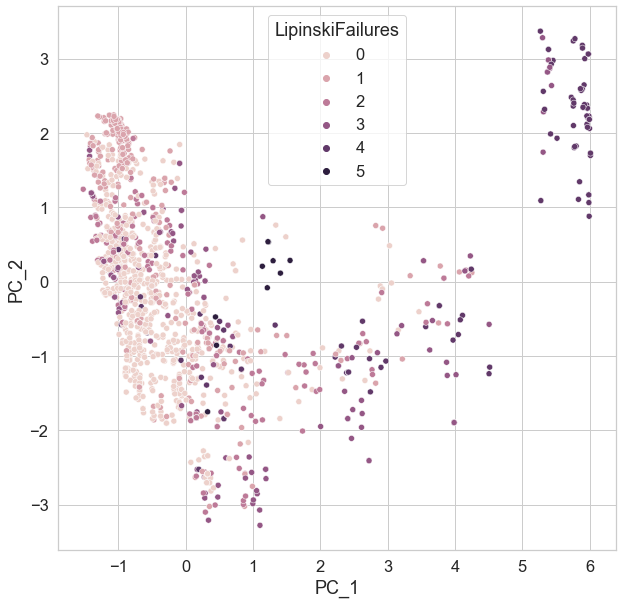

In [65]:
ax = sns.scatterplot(data=crds_df,x="PC_1",y="PC_2",hue="LipinskiFailures")


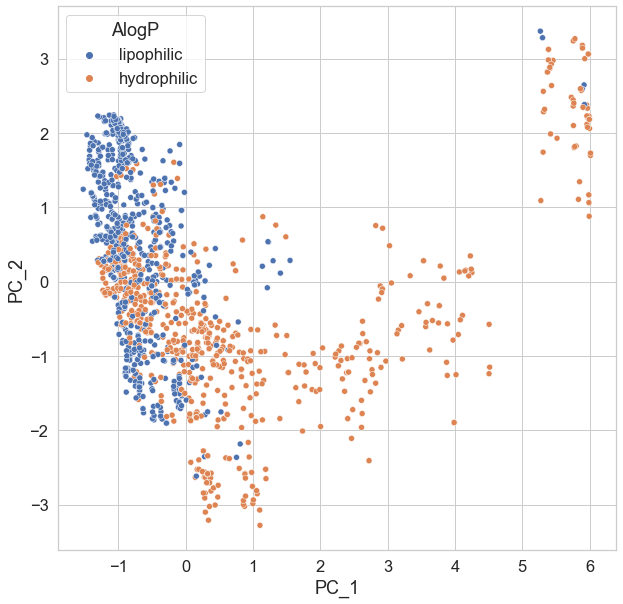

In [72]:
crds_df = pd.DataFrame(crds,columns=["PC_1","PC_2"])
crds_df['AlogP'] = list(wm_df.AlogP)
ax = sns.scatterplot(data=crds_df,x="PC_1",y="PC_2",hue="AlogP")


In [56]:
np.sum(pca.explained_variance_ratio_)


0.1998271495455869

In [57]:
%time crds_embedded = TSNE(n_components=2).fit_transform(crds)


CPU times: user 23.4 s, sys: 274 ms, total: 23.6 s
Wall time: 7.96 s


In [58]:
tsne_df = pd.DataFrame(crds_embedded,columns=["X","Y"])
tsne_df['LipinskiFailures'] = list(wm_df.LipinskiFailures)

tsne_df.head()


X          Y  LipinskiFailures
0  18.630724 -25.027802                 0
1  25.953026   6.080048                 0
2  15.707812 -34.511433                 0
3  19.313499   5.447445                 0
4  19.099434  -1.094059                 0

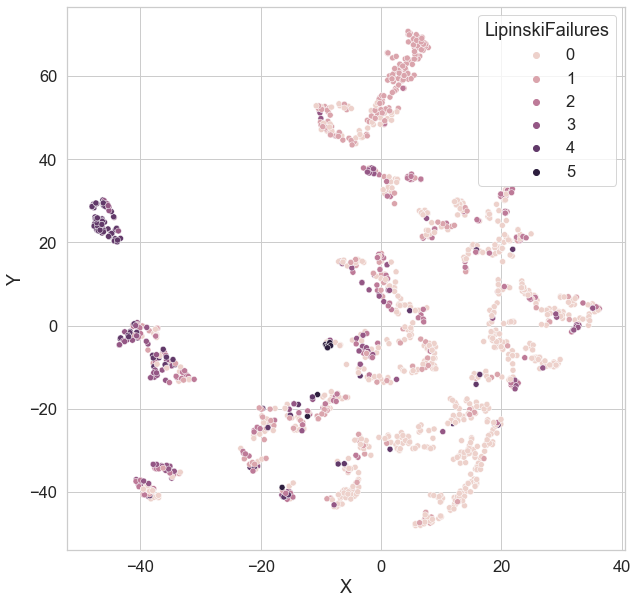

In [59]:
ax = sns.scatterplot(data=tsne_df,x="X",y="Y",hue="LipinskiFailures")


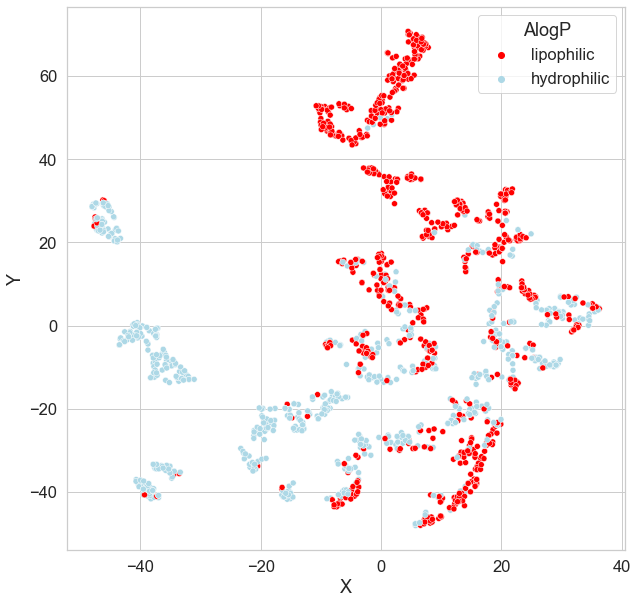

In [71]:
tsne_df = pd.DataFrame(crds_embedded,columns=["X","Y"])
tsne_df['AlogP'] = list(wm_df.AlogP)
ax = sns.scatterplot(data=tsne_df,x="X",y="Y",hue="AlogP", palette={'hydrophilic' :'lightblue','lipophilic':'red'})


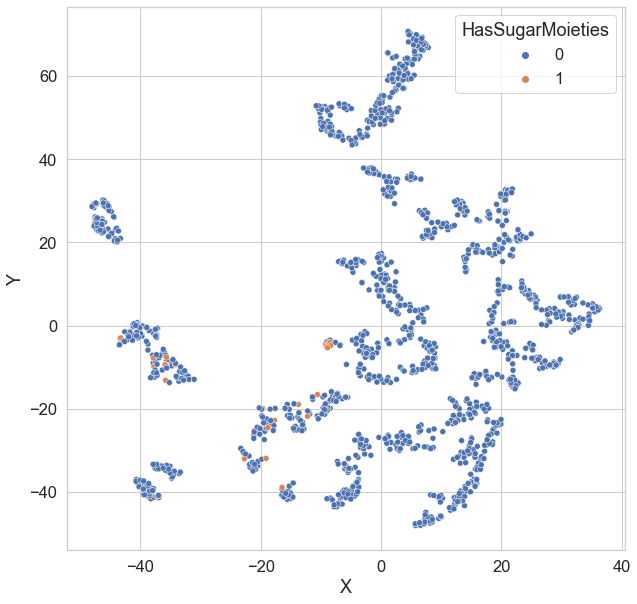

In [67]:
tsne_df = pd.DataFrame(crds_embedded,columns=["X","Y"])
tsne_df['HasSugarMoieties'] = list(wm_df.HasSugarMoieties)
ax = sns.scatterplot(data=tsne_df,x="X",y="Y",hue="HasSugarMoieties")


In [ ]:
 "":

## make watermelon x zinc DF

In [ ]:
wm_fp_list = []

for wm in db.wmolecules.find({}):
    rdmol = Chem.Mol(wm['rdmol'])
    mfp = AllChem.GetMorganFingerprintAsBitVect(rdmol, 2, nBits=2048,useFeatures=True)
    wm_fp_list.append(mfp)
    
print(len(wm_fp_list))
#create new df 

wm_df = pd.DataFrame({'fingerprints':wm_fp_list})
wm_df['provenance'] = "watermelon"
print (wm_df)

In [55]:
# adding zinc to the dataset
zinc_fp_list = []

for wm in db.zinc_active.find({}):
    rdmol = Chem.Mol(wm['rdmol'])
    mfp = AllChem.GetMorganFingerprintAsBitVect(rdmol, 2, nBits=2048,useFeatures=True)
    zinc_fp_list.append(mfp)
    
print(len(zinc_fp_list))
#create new df 

zinc_df = pd.DataFrame({'fingerprints':zinc_fp_list})
zinc_df['provenance'] = "zinc_active"
print (zinc_df)

306347
                                             fingerprints   provenance
0       [1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...  zinc_active
1       [1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...  zinc_active
2       [1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, ...  zinc_active
3       [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  zinc_active
4       [1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  zinc_active
...                                                   ...          ...
306342  [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  zinc_active
306343  [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  zinc_active
306344  [1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  zinc_active
306345  [1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  zinc_active
306346  [1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  zinc_active

[306347 rows x 2 columns]


In [67]:
wm_x_zinc_df = pd.concat([ zinc_df, wm_df]) 

In [68]:
wm_x_zinc_df['fingerprints']

0       [1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...
1       [1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...
2       [1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, ...
3       [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4       [1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
                              ...                        
1535    [1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...
1536    [1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1537    [1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1538    [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1539    [1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: fingerprints, Length: 307887, dtype: object

In [69]:
print (wm_x_zinc_df)

                                           fingerprints   provenance
0     [1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...  zinc_active
1     [1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...  zinc_active
2     [1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, ...  zinc_active
3     [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  zinc_active
4     [1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  zinc_active
...                                                 ...          ...
1535  [1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...   watermelon
1536  [1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   watermelon
1537  [1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   watermelon
1538  [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   watermelon
1539  [1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   watermelon

[307887 rows x 2 columns]


In [70]:
pca = PCA(n_components=2)

crds = pca.fit_transform(wm_x_zinc_df["fingerprints"].tolist())

In [71]:
crds_df = pd.DataFrame(crds,columns=["PC_1","PC_2"])
crds_df['provenance'] = list(wm_x_zinc_df.provenance)
crds_df.head()

PC_1      PC_2   provenance
0 -0.851989 -0.963774  zinc_active
1 -1.738448 -0.383241  zinc_active
2 -1.110699  0.138548  zinc_active
3  0.454732 -0.327927  zinc_active
4 -0.693231 -0.810983  zinc_active

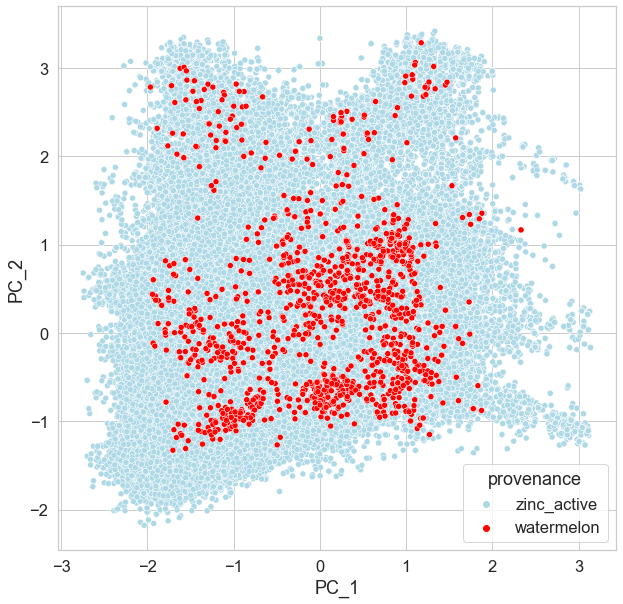

In [72]:
ax = sns.scatterplot(data=crds_df,x="PC_1",y="PC_2",hue="provenance",palette={'zinc_active' :'lightblue','watermelon':'red'})


In [73]:
np.sum(pca.explained_variance_ratio_)


0.1314542128572761

The PCA with two components explains only 19% of the overall variance in the watermelon dataset (when watermelon only, without ZINC) and 13% of watermelon + ZINC active, so maybe not the optimal approach.

An alternative is to use another dimensionality reduction method which will hopefully capture a larger fraction of the overall variance.  One such method is known as t-distributed stochastic neighbor embedding or t-sne.  In t-sne, we start with two distributions a distribution of distances between points in a high dimensional space (e.g. fingerprints) and a set of distances between points in a lower dimensional space (e.g. a 2D plot).  The t-sne method then uses a technique known as Kulbeck-Liebler Divergence (KL Divergence) to minimize the distances between the distributions.  In the end, the distribution of distances in the low dimensional space will hopefully match that of the high dimensional space.   

In [32]:
def evaluate_components(fp_list):
    res = []
    for n_comp in range(2,51):
        pca = PCA(n_components=n_comp)
        crds = pca.fit_transform(fp_list)
        var = np.sum(pca.explained_variance_ratio_)
        res.append([n_comp,var])
    return res


In [34]:

#res = evaluate_components(wm_fp_list)

[]

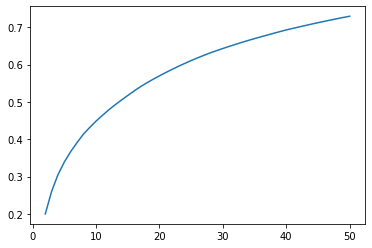

In [39]:
#plt.plot([item[0] for item in res], [item[1] for item in res])

Based on this, 50 principal components provide a quite good representation of the watermelon NP space (over 70% is explained)

In [74]:

%time crds_embedded = TSNE(n_components=2).fit_transform(crds)


CPU times: user 2h 16min 33s, sys: 3min 41s, total: 2h 20min 14s
Wall time: 48min 8s


In [77]:
tsne_df = pd.DataFrame(crds_embedded,columns=["X","Y"])
tsne_df['provenance'] = list(wm_x_zinc_df.provenance)

tsne_df.head()


X          Y   provenance
0  -0.746679 -14.573732  zinc_active
1  13.214890  -7.497393  zinc_active
2 -24.197618  -6.269097  zinc_active
3  11.967168  26.272001  zinc_active
4 -23.408659   2.788214  zinc_active

/Applications/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


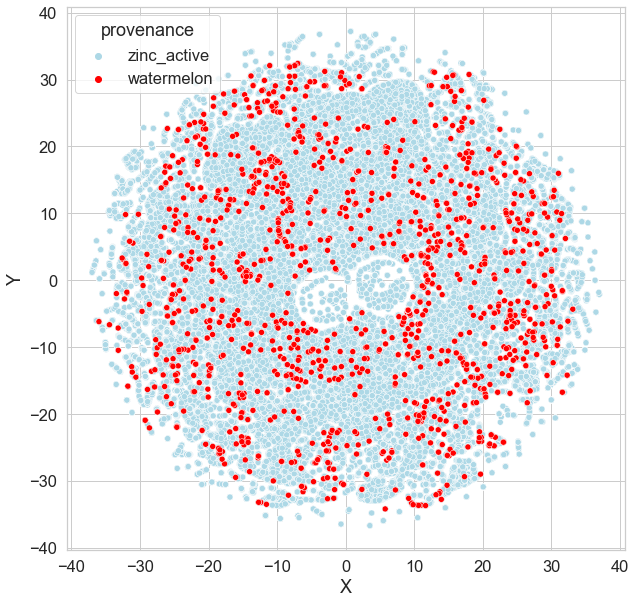

In [78]:

ax = sns.scatterplot(data=tsne_df,x="X",y="Y",hue="provenance",palette={'zinc_active' :'lightblue','watermelon':'red'})


In [80]:
#trying with more components
pca = PCA(n_components=30)

crds = pca.fit_transform(wm_x_zinc_df["fingerprints"].tolist())

%time crds_embedded = TSNE(n_components=2).fit_transform(crds)


CPU times: user 2h 54min 45s, sys: 13min 54s, total: 3h 8min 40s
Wall time: 1h 19min 4s


In [81]:
tsne_df = pd.DataFrame(crds_embedded,columns=["X","Y"])
tsne_df['provenance'] = list(wm_x_zinc_df.provenance)

tsne_df.head()


X          Y   provenance
0 -6.529037   6.105446  zinc_active
1  6.969872  14.536743  zinc_active
2  1.117159   2.346571  zinc_active
3  5.638535 -19.763618  zinc_active
4  6.213815  -9.085928  zinc_active

/Applications/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


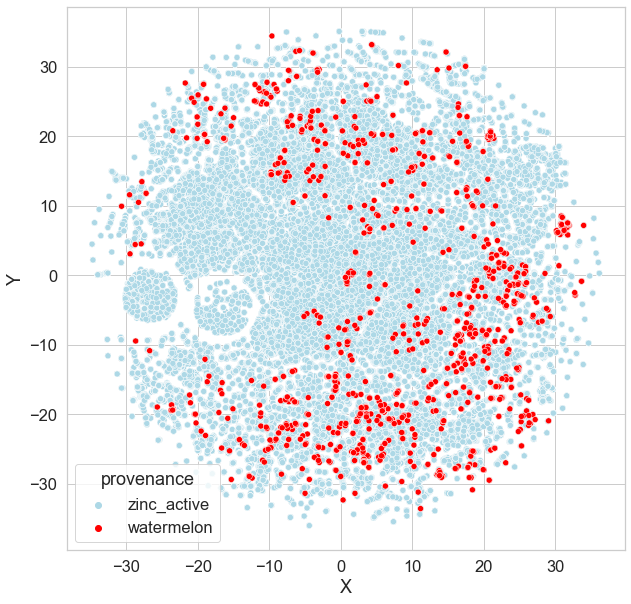

In [82]:
ax = sns.scatterplot(data=tsne_df,x="X",y="Y",hue="provenance",palette={'zinc_active' :'lightblue','watermelon':'red'})


In [83]:

pca = PCA(n_components=50)


crds = pca.fit_transform(wm_x_zinc_df["fingerprints"].tolist())

%time crds_embedded = TSNE(n_components=2).fit_transform(crds)


CPU times: user 3h 22min 10s, sys: 14min 28s, total: 3h 36min 38s
Wall time: 1h 26min 33s


In [84]:
tsne_df = pd.DataFrame(crds_embedded,columns=["X","Y"])
tsne_df['provenance'] = list(wm_x_zinc_df.provenance)

tsne_df.head()


X          Y   provenance
0  13.768315  -6.190479  zinc_active
1  -5.502027   2.525298  zinc_active
2   1.718772   1.723975  zinc_active
3  -9.620750 -12.859940  zinc_active
4  -6.100767 -17.289104  zinc_active

/Applications/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


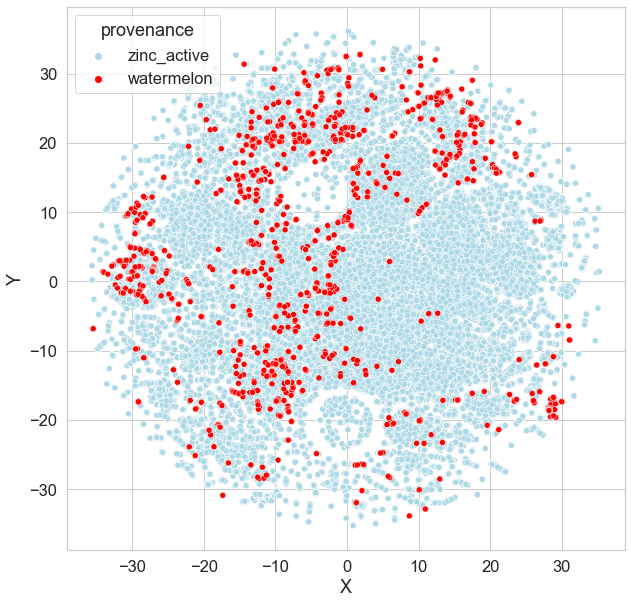

In [85]:
ax = sns.scatterplot(data=tsne_df,x="X",y="Y",hue="provenance",palette={'zinc_active' :'lightblue','watermelon':'red'})


In [94]:
pca = PCA(n_components=4)

crds = pca.fit_transform(wm_x_zinc_df["fingerprints"].tolist())

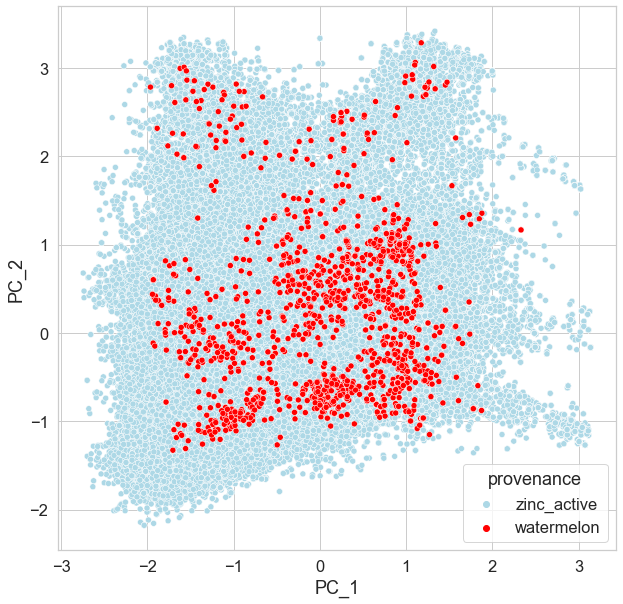

In [95]:
crds_df = pd.DataFrame(crds,columns=["PC_1","PC_2", "PC_3", "PC_4"])
crds_df['provenance'] = list(wm_x_zinc_df.provenance)
crds_df.head()

ax = sns.scatterplot(data=crds_df,x="PC_1",y="PC_2",hue="provenance",palette={'zinc_active' :'lightblue','watermelon':'red'})

## Watermelon x DrugBank

In [88]:
# adding drugbank to the dataset
drugbank_fp_list = []

#TODO bottom
for wm in db.drugbank.find({}):
    rdmol = Chem.Mol(wm['rdmol'])
    mfp = AllChem.GetMorganFingerprintAsBitVect(rdmol, 2, nBits=2048,useFeatures=True)
    drugbank_fp_list.append(mfp)
    
print(len(drugbank_fp_list))
#create new df 

drugbank_df = pd.DataFrame({'fingerprints': drugbank_fp_list})
drugbank_df['provenance'] = "drugbank"
print (drugbank_df)


wm_x_drugbank_df = pd.concat([ drugbank_df, wm_df]) 

9137
                                           fingerprints provenance
0     [1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...   drugbank
1     [1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...   drugbank
2     [1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...   drugbank
3     [1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...   drugbank
4     [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   drugbank
...                                                 ...        ...
9132  [1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   drugbank
9133  [1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...   drugbank
9134  [1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   drugbank
9135  [1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, ...   drugbank
9136  [1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...   drugbank

[9137 rows x 2 columns]


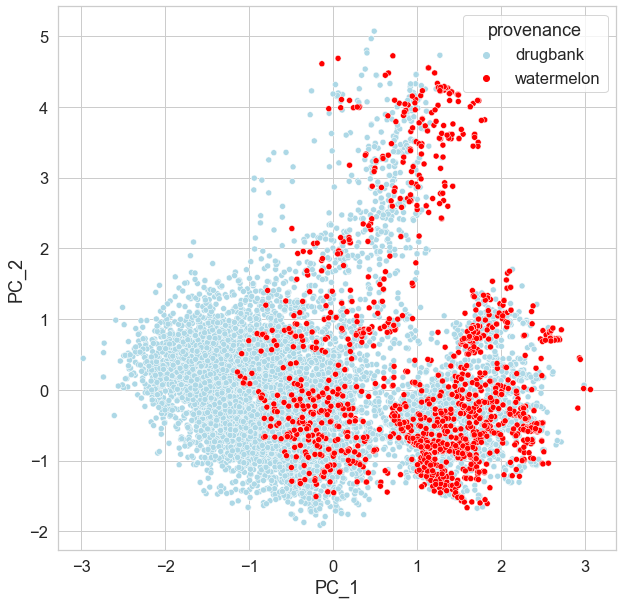

In [89]:
pca = PCA(n_components=2)

crds = pca.fit_transform(wm_x_drugbank_df["fingerprints"].tolist())

crds_df = pd.DataFrame(crds,columns=["PC_1","PC_2"])
crds_df['provenance'] = list(wm_x_drugbank_df.provenance)
crds_df.head()

ax = sns.scatterplot(data=crds_df,x="PC_1",y="PC_2",hue="provenance",palette={'drugbank' :'lightblue','watermelon':'red'})


In [90]:
np.sum(pca.explained_variance_ratio_)


0.10047216494765075

In [91]:
%time crds_embedded = TSNE(n_components=2).fit_transform(crds)


CPU times: user 3min 23s, sys: 10.3 s, total: 3min 33s
Wall time: 1min 54s


In [92]:


tsne_df = pd.DataFrame(crds_embedded,columns=["X","Y"])
tsne_df['provenance'] = list(wm_x_drugbank_df.provenance)

tsne_df.head()


X          Y provenance
0  -7.173902 -16.425613   drugbank
1  39.283966  10.706115   drugbank
2  -4.856858 -54.885235   drugbank
3 -41.554668 -60.206890   drugbank
4 -80.477295 -43.724739   drugbank

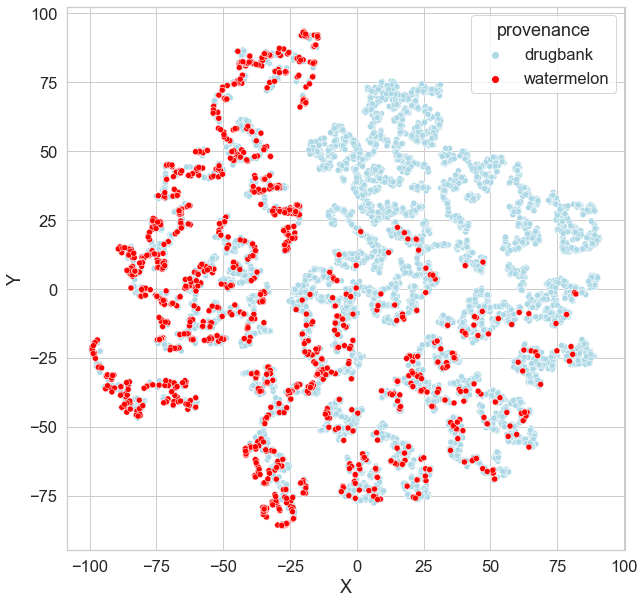

In [93]:
ax = sns.scatterplot(data=tsne_df,x="X",y="Y",hue="provenance",palette={'drugbank' :'lightblue','watermelon':'red'})


## visualisation of physico-chemical properties

In [97]:
print(list(wmdf.columns))

['compoundName', 'iupacName', 'cas', 'kegg', 'hmdb', 'pubchem', 'chebi', 'foodb', 'lipidmaps', 'molecularFormula', 'molecularWeight', 'afc_id', 'original_smiles', 'inchikey', 'Canonical_Smiles', 'contains_sugars', 'contains_ring_sugars', 'contains_linear_sugars', 'number_of_carbons', 'number_of_nitrogens', 'number_of_oxygens', 'number_of_rings', 'max_number_of_rings', 'min_number_of_rings', 'sugar_free_heavy_atom_number', 'sugar_free_total_atom_number', 'total_atom_number', 'bond_count', 'murko_framework', 'ertlFunctionalFragments', 'ertlFunctionalFragmentsPseudoSmiles', 'alogp', 'alogp2', 'amralogp', 'apol', 'bpol', 'eccentricConnectivityIndexDescriptor', 'fmfDescriptor', 'fsp3', 'fragmentComplexityDescriptor', 'numberSpiroAtoms', 'lipinskiRuleOf5Failures', 'xlogp', 'zagrebIndex', 'topoPSA', 'tpsaEfficiency']


In [155]:
#number entries

print(len(wmdf.index))

atom_type_dic = {}
mol_count_S = 0
mol_count_Se = 0
mol_count_As = 0
mol_count_Mo = 0

for index, row in wmdf.iterrows():
    mol = Chem.MolFromSmiles(row["Canonical_Smiles"])
    for atom in mol.GetAtoms():
        if atom.GetSymbol()== "S":
            mol_count_S+=1
        if atom.GetSymbol()== "Se":
            mol_count_Se+=1
        if atom.GetSymbol()== "As":
            mol_count_As+=1
        if atom.GetSymbol()== "Mo":
            mol_count_Mo+=1
        
        if atom.GetSymbol() in atom_type_dic:
            atom_type_dic[atom.GetSymbol()] = atom_type_dic[atom.GetSymbol()]+1
        else:
            atom_type_dic[atom.GetSymbol()]=1
print(atom_type_dic)
print(mol_count_S)
print(mol_count_Se)
print(mol_count_As)
print(mol_count_Mo)

1540
{'C': 25375, 'Cl': 9, 'N': 1788, 'O': 9172, 'P': 632, 'S': 158, 'Se': 1, 'As': 1}
158
1
1
0


In [98]:
wmdf["contains_sugars"].value_counts()

0    1511
1      29
Name: contains_sugars, dtype: int64

In [99]:
wmdf["contains_ring_sugars"].value_counts()

False    1515
True       25
Name: contains_ring_sugars, dtype: int64

In [140]:
sugar_wm = wmdf[wmdf["contains_sugars"]==1].copy()
sugar_wm["rdmol"] = ""

l = []

for index, row in sugar_wm.iterrows():

    try:
        m = Chem.MolFromSmiles(row["Canonical_Smiles"])

        tmp=AllChem.Compute2DCoords(m)

        row["rdmol"] = m
        l.append(m)
        

    except:
        print("oups")
        continue





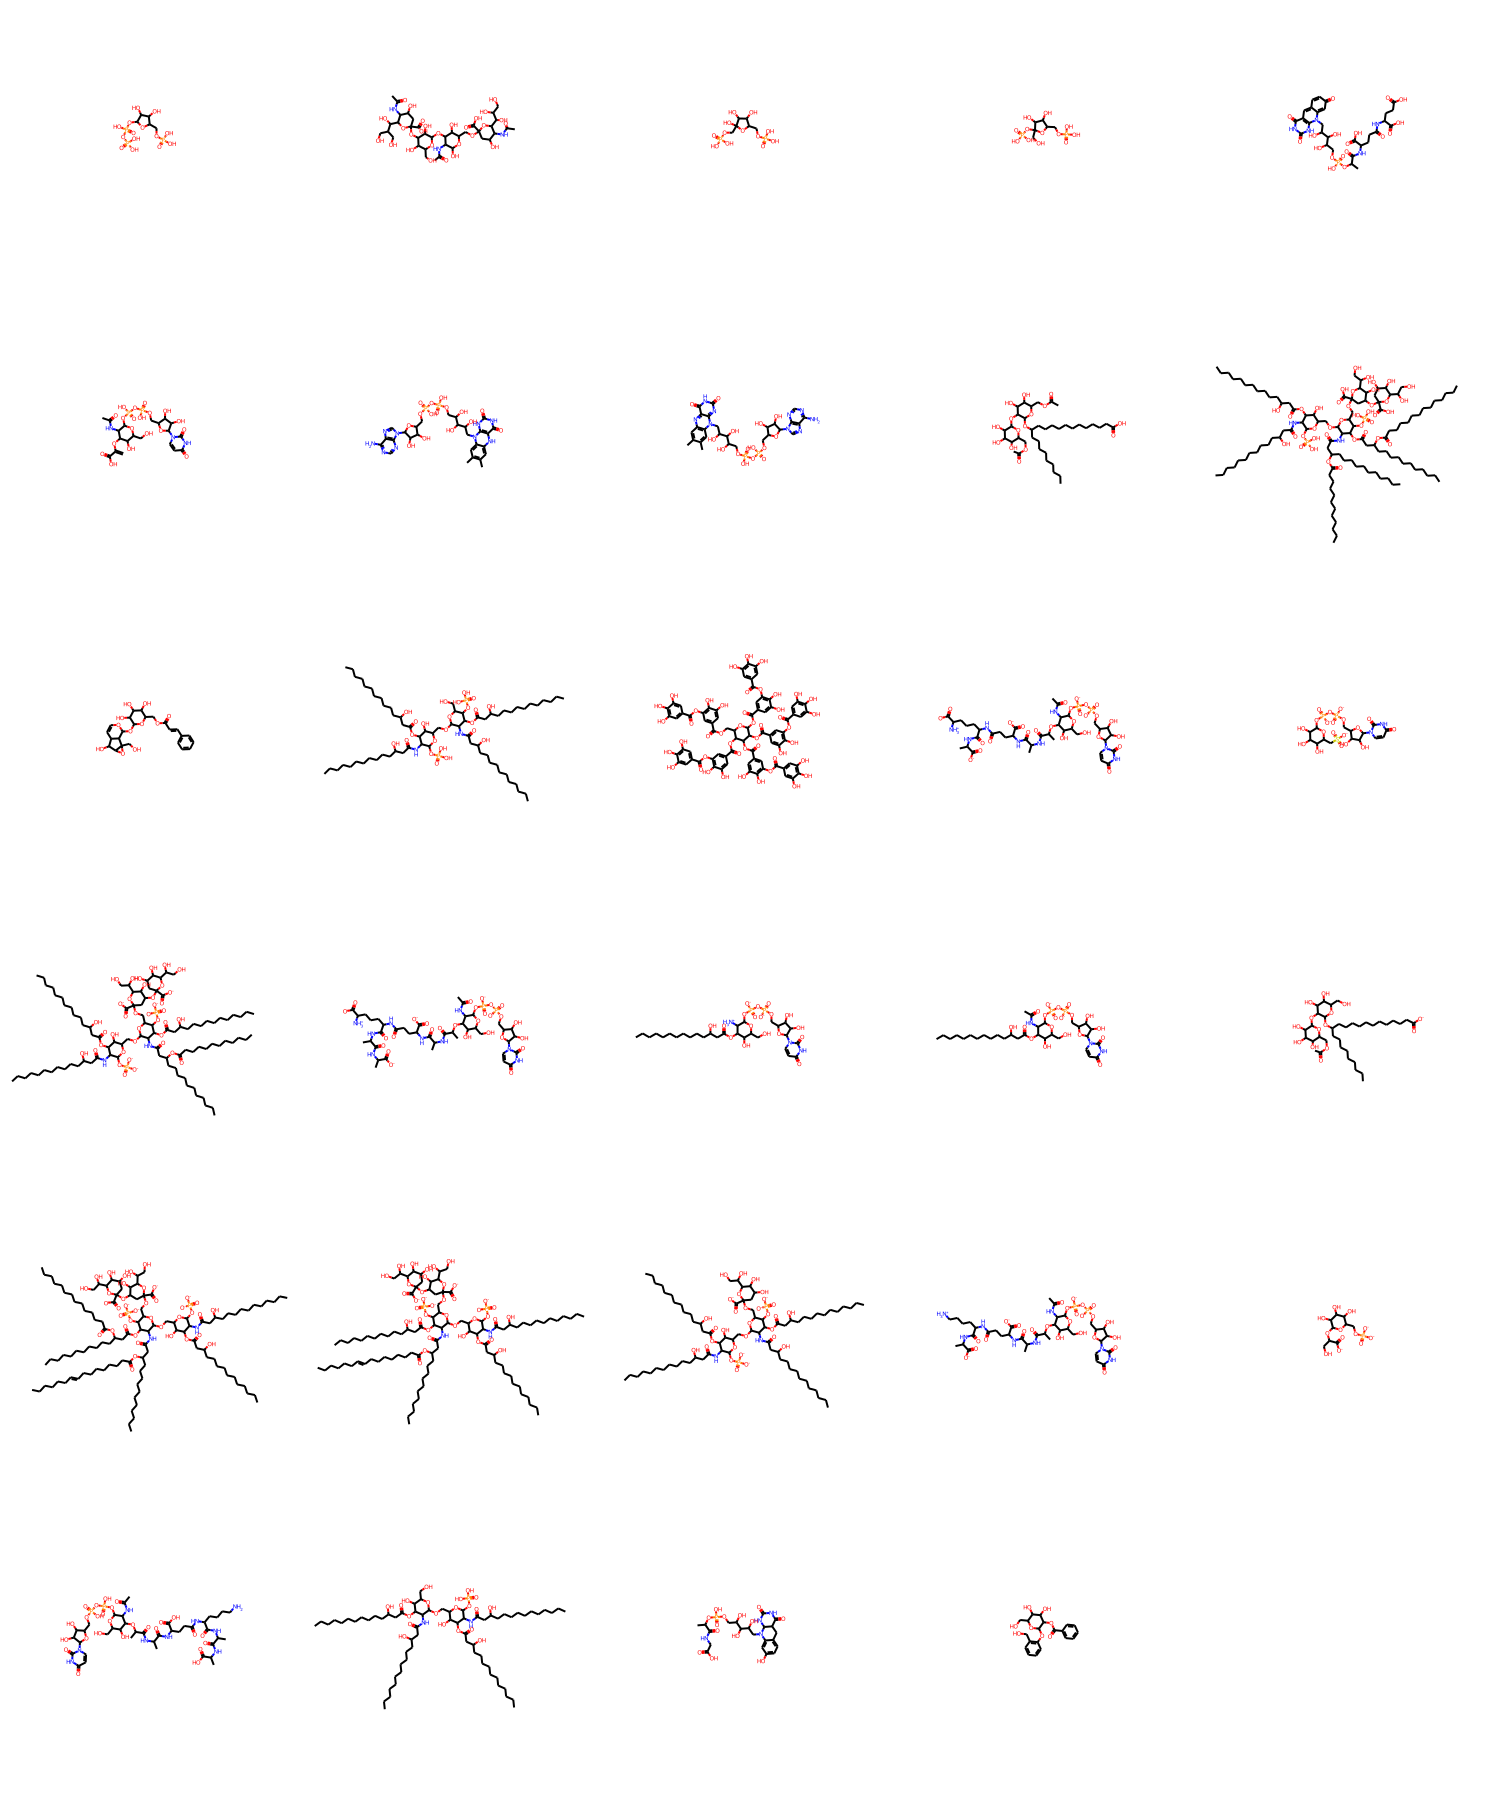

In [156]:
Draw.MolsToGridImage(l,molsPerRow=5,subImgSize=(300,300)) 


In [ ]:


alogp
sns.displot(penguins, x="flipper_length_mm", kind="kde", bw_adjust=2)


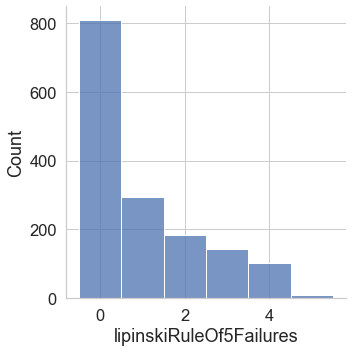

In [163]:
sns.displot(wmdf, x="lipinskiRuleOf5Failures", discrete=True)



In [165]:
print(len(wmdf[wmdf["lipinskiRuleOf5Failures"]==0].index) / len(wmdf.index))


0.5246753246753246


# NP classifier

In [86]:
import wget
from urllib.parse import quote
import urllib.request
from urllib.error import HTTPError
import json



In [96]:

fo = open("data/np_classes.tsv", "w")

fo.write("afc_id\tclass\tpathway\tsuperclass\n")

pathways_count = {}
mixed_pathways_molecules = {}

unclassified = []

for index, row in wmdf.iterrows():
    
    string_to_write=str(row["afc_id"])
    smiles = row["Canonical_Smiles"]
    url = 'https://npclassifier.ucsd.edu/classify?smiles=' + str(smiles)
    try:
        urllib.request.urlretrieve(url, 'np_classifications/' + str(row["afc_id"]))
    except (ConnectionRefusedError, HTTPError) as e:
        print("problem with " + smiles)
        unclassified.append(smiles)
        time.sleep(1)
    
    
    if row["afc_id"] not in os.listdir("np_classifications"):
        try:
            urllib.request.urlretrieve(url, 'np_classifications/' + str(row["afc_id"]))
        except (ConnectionRefusedError, HTTPError) as e:
            print("problem with " + smiles)

            time.sleep(1)
    else:
        f = open("np_classifications/" + str(row["afc_id"]))
        for l in f:
            # l is the only line in this document
            # l is a json format
            class_dict = json.loads(l)
            if len(class_dict['class_results']) > 0:
                string_to_write = string_to_write+"\t"+";".join(class_dict['class_results'])
            if len(class_dict['pathway_results']) > 0:
                string_to_write = string_to_write+"\t"+";".join(class_dict['pathway_results'])
                if len(class_dict['pathway_results']) == 1:
                    if class_dict['pathway_results'][0] in pathways_count:
                        pathways_count[class_dict['pathway_results'][0]]+=1
                    else:
                        pathways_count[class_dict['pathway_results'][0]] = 1
                else:
                    if str(class_dict['pathway_results']) in mixed_pathways_molecules:
                        mixed_pathways_molecules[str(class_dict['pathway_results'])]+=" "+str(row["afc_id"])
                    else:
                        mixed_pathways_molecules[str(class_dict['pathway_results'])] = str(row["afc_id"])
                    for p in class_dict['pathway_results']:
                        if class_dict['pathway_results'][0] in pathways_count:
                            pathways_count[p]+=1
                        else:
                            pathways_count[p] = 1
                        
                
            if len(class_dict['superclass_results']) > 0:
                string_to_write = string_to_write+"\t"+";".join(class_dict['superclass_results'])
                
            fo.write(string_to_write + "\n")

fo.close()

problem with C1([H])=C(C([H])=C(C(=C1[H])Cl)[N+](=O)[O-])[N+](=O)[O-]
problem with C1([H])=C(C([H])=C(C(=C1[H])Cl)[N+](=O)[O-])[N+](=O)[O-]
problem with C([H])([H])([H])[N+](C([H])([H])[H])(C([H])([H])[H])C([H])([H])C(=O)[O-]
problem with C([H])([H])([H])[N+](C([H])([H])[H])(C([H])([H])[H])C([H])([H])C(=O)[O-]
problem with C([H])([H])([H])[N+](C([H])([H])[H])(C([H])([H])[H])C([H])([H])C([H])=O
problem with C([H])([H])([H])[N+](C([H])([H])[H])(C([H])([H])[H])C([H])([H])C([H])=O
problem with C([H])([H])([H])[N+](C([H])([H])[H])(C([H])([H])[H])C([H])([H])C([H])([H])O[H]
problem with C([H])([H])([H])[N+](C([H])([H])[H])(C([H])([H])[H])C([H])([H])C([H])([H])O[H]
problem with C([H])([H])([H])[N+](C([H])([H])[H])(C1=C([H])C([H])=C([H])C([H])=C1[H])[O-]
problem with C([H])([H])([H])[N+](C([H])([H])[H])(C1=C([H])C([H])=C([H])C([H])=C1[H])[O-]
problem with C([H])([H])([H])[N+](C([H])([H])[H])(C([H])([H])[H])C([H])([H])C([H])([H])OP(=O)(O[H])O[H]
problem with C([H])([H])([H])[N+](C([H])([H])[H])(

problem with C1([H])=C(C(=C(C([H])=C1C(=O)OC2=C(C(=C([H])C(=C2[H])C(=O)OC([H])([H])C3([H])C([H])(C([H])(C([H])(C([H])(O3)OC(=O)C4=C([H])C(=C(C(=C4[H])O[H])O[H])OC(=O)C5=C([H])C(=C(C(=C5[H])O[H])O[H])O[H])OC(=O)C6=C([H])C(=C(C(=C6[H])O[H])O[H])OC(=O)C7=C([H])C(=C(C(=C7[H])O[H])O[H])O[H])OC(=O)C8=C([H])C(=C(C(=C8[H])O[H])O[H])OC(=O)C9=C([H])C(=C(C(=C9[H])O[H])O[H])O[H])OC(=O)C%10=C([H])C(=C(C(=C%10[H])O[H])O[H])OC(=O)C%11=C([H])C(=C(C(=C%11[H])O[H])O[H])O[H])O[H])O[H])O[H])O[H])O[H]
problem with C([H])([H])([H])C([H])(C(=O)N([H])C([H])(C([H])([H])C([H])([H])C(=O)N([H])C([H])(C([H])([H])C([H])([H])C([H])([H])C([H])(C(=O)[O-])[N+]([H])([H])[H])C(=O)N([H])C([H])(C([H])([H])[H])C(=O)[O-])C(=O)[O-])N([H])C(=O)C([H])(C([H])([H])[H])OC1([H])C([H])(C([H])(OC([H])(C([H])([H])O[H])C1([H])O[H])OP(=O)([O-])OP(=O)([O-])OC([H])([H])C2([H])C([H])(C([H])(C([H])(N3C([H])=C([H])C(=O)N([H])C3=O)O2)O[H])O[H])N([H])C(=O)C([H])([H])[H]
problem with C([H])([H])([H])C([H])(C(=O)N([H])C([H])(C([H])([H])C([H])([H

problem with C1([H])=C([H])C([H])=C(C([H])=C1[H])C([H])([H])S(=O)C([H])([H])C([H])(C(=O)[O-])[N+]([H])([H])[H]
problem with C1([H])=C([H])C([H])=C(C([H])=C1[H])C([H])([H])S(=O)C([H])([H])C([H])(C(=O)[O-])[N+]([H])([H])[H]
problem with C1([H])=C(C(=C(C([H])=C1C2=[O+]C3=C(C([H])=C2OC4([H])C([H])(C([H])(C([H])(C([H])(C([H])([H])O[H])O4)O[H])O[H])O[H])C(=C([H])C(=C3[H])O[H])O[H])O[H])O[H])O[H]
problem with C1([H])=C(C(=C(C([H])=C1C2=[O+]C3=C(C([H])=C2OC4([H])C([H])(C([H])(C([H])(C([H])(C([H])([H])O[H])O4)O[H])O[H])O[H])C(=C([H])C(=C3[H])O[H])O[H])O[H])O[H])O[H]
problem with C1([H])=C(C([H])=C([H])C(=C1[H])N2C([H])([H])C3([H])C([H])([H])N([H])C4=C(C(=O)N([H])C(=N4)N([H])[H])[N+]3=C2[H])C(=O)N([H])C([H])(C([H])([H])C([H])([H])C(=O)O[H])C(=O)O[H]
problem with C1([H])=C(C([H])=C([H])C(=C1[H])N2C([H])([H])C3([H])C([H])([H])N([H])C4=C(C(=O)N([H])C(=N4)N([H])[H])[N+]3=C2[H])C(=O)N([H])C([H])(C([H])([H])C([H])([H])C(=O)O[H])C(=O)O[H]
problem with C([H])([H])([H])[N+]1=C([H])N(C2=C1C(=O)N([H])C(=N2

OSError: [Errno 63] File name too long: 'np_classifications/C([H])([H])([H])C(C([H])([H])[H])(C([H])([H])C([H])([H])C(=O)[C@@](C([H])([H])[H])(C1([H])[C@@]([H])(C([H])([H])[C@@]2(C([H])([H])[H])[C@]3([H])C([H])([H])C([H])=C4[C@@]([H])(C([H])([H])[C@@]([H])(C(=O)C4(C([H])([H])[H])C([H])([H])[H])O[C@@]5([H])[C@@]([H])([C@]([H])([C@@]([H])([C@@]([H])(C([H])([H])O[H])O5)O[H])O[H])O[H])[C@]3(C([H])([H])[H])C(=O)C([H])([H])[C@]12C([H])([H])[H])O[H])O[H])O[H]'

In [ ]:
print(pathways_count)

In [ ]:
print(mixed_pathways_molecules)

In [ ]:
print(unclassified)

In [ ]:
len(pathways_count.keys())

In [ ]:
print(len(mixed_pathways_molecules.keys()))
print(len(unclassified))